# Homework 6: Intermarket Prediction
##### Name: Anand Nakhate
##### Student ID: 12446907
##### Date: 21 February 2025

In [28]:
import pandas as pd
import numpy as np
import math

import os
import datetime
import quandl
import scipy as sp
import statsmodels.api as sm
from scipy.stats import skew, kurtosis, jarque_bera
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera

import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import lru_cache

import warnings
warnings.filterwarnings("ignore")

# Abstract and Introduction

##### Purpose & Scope
This research develops and analyzes a two‐stage regression framework to exploit idiosyncratic mispricings between equity returns and CDS spreads for U.S. corporates. By combining a CAPM‐style equity hedge and a CDS index hedge, our strategy isolates stock‐specific and credit‐specific signals, generating robust alpha while mitigating systemic risk.

##### Data & Methodology
- We construct weekly returns for several U.S. corporates’ equities and their corresponding 5‐year CDS spreads.
- We employ a two‐stage model
- Equity Hedging via a rolling or exponentially‐weighted regression on the S&P 500 (SPY).
- CDS Hedging on both the firm’s own equity and a CDS index to extract “idiosyncratic” CDS returns (ρ).
- Predictive Signal uses last week’s idiosyncratic equity (c) to forecast next week’s idiosyncratic CDS return (ρ).
- We then execute threshold or quantile trades on these predicted ρ’s, systematically going long/short in the CDS depending on the sign and magnitude of the signal.

##### Parameter Optimization & Tests
We employ a grid search on rolling windows, half‐lives, and signal thresholds/quantiles. Our final “best” parameters (e.g., window=10 weeks, threshold=0.009) deliver superior Sharpe, consistent alpha, and moderate drawdowns across the 2018–2025 sample.

##### Findings
- High Alpha, Factor Neutrality: Traditional Fama–French factors explain only ~1–2% of variance; the strategy’s returns remain driven by firm‐level mispricings, yielding ~20–25% annual alpha.
- Hedged Superiority: A fully hedged approach outperforms an unhedged version in both total and risk‐adjusted returns, particularly during crises (COVID, 2022 market volatility).
- Regime Robustness: The strategy excels in medium volatility conditions with falling or stable rates; it still performs positively under many other regimes, though extremes (low‐vol + rising‐rates) are less favorable.

##### Relevance
For investors seeking diversification or an uncorrelated alpha source, this hedged equity–CDS strategy offers a relatively stable return profile, low correlation to standard equity/bond factors, and controlled downside risk even in turbulent markets.

# Data Acquisition and Exploratory Data Analysis¶

## Data Cleaning and Filtering

In [2]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.environ["HOME"], "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key="SyATKMGuooiZSzbH97Bj", **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

In [3]:
prices = fetch_quandl_table('QUOTEMEDIA/PRICES')
prices.shape

Skipping any possible download of QUOTEMEDIA/PRICES


(51441587, 14)

In [4]:
prices

ticker        date     open     high      low    close     volume  \
0         JTKWY  2022-03-11   6.1700   7.3200   5.7900   6.7200  9440097.0   
1         JTKWY  2022-03-10   6.1600   6.1750   5.9350   6.0700  2261623.0   
2          FG_1  2020-06-01   8.1000   8.3900   8.1000   8.3900  3086317.0   
3         YTENQ  2024-09-30   0.9514   1.0500   0.9514   1.0500      842.0   
4          FLWS  2022-03-09  14.5700  14.9588  14.4100  14.4500   662492.0   
...         ...         ...      ...      ...      ...      ...        ...   
51441582   PRCS  2024-12-16  24.9600  24.9600  24.8900  24.9306     6474.0   
51441583   PRVS  2024-12-16  24.9116  24.9184  24.7446  24.7446     6889.0   
51441584   SCDV  2024-12-16  24.8600  24.8800  24.7800  24.8100     2212.0   
51441585   ATLN  2024-12-16   5.5111   5.7550   4.9500   5.4000     8514.0   
51441586   SMCL  2024-12-16  16.3400  20.5700  16.3000  18.5300    78715.0   

          dividend  split  adj_open  adj_high  adj_low  adj_close  adj_volume  
0              0.0    1.0    6.1700    7.3200   5.7900     6.7200   9440097.0  
1              0.0    1.0    6.1600    6.1750   5.9350     6.0700   2261623.0  
2              0.0    1.0    8.1000    8.3900   8.1000     8.3900   3086317.0  
3              0.0    1.0    0.9514    1.0500   0.9514     1.0500       842.0  
4              0.0    1.0   14.5700   14.9588  14.4100    14.4500    662492.0  
...            ...    ...       ...       ...      ...        ...         ...  
51441582       0.0    1.0   24.9600   24.9600  24.8900    24.9306      6474.0  
51441583       0.0    1.0   24.9116   24.9184  24.7446    24.7446      6889.0  
51441584       0.0    1.0   24.8600   24.8800  24.7800    24.8100      2212.0  
51441585       0.0    1.0    5.5111    5.7550   4.9500     5.4000      8514.0  
51441586       0.0    1.0   16.3400   20.5700  16.3000    18.5300     78715.0  

[51441587 rows x 14 columns]

In [5]:
def process_cds_data(file_path):
    cds = pd.read_table(file_path)
    cds['date'] = pd.to_datetime(cds['date'])
    cds = cds.sort_values(['ticker', 'date'])
    cds = cds[cds['tenor'] == '5Y']
    cds = cds[['date', 'ticker', 'parspread']]
    cds = cds.rename(columns={'parspread': 'cds_spread'})
    cds_wide = cds.pivot(index='date', columns='ticker', values='cds_spread')
    start_date, end_date = cds_wide.index.min(), cds_wide.index.max()
    wednesdays = pd.date_range(start=start_date, end=end_date, freq='W-WED')
    cds_weekly = cds_wide.reindex(wednesdays).ffill()
    return cds_weekly

def create_cds_index(cds_pivot):
    cds_index = cds_pivot.mean(axis=1)
    cds_index.name = 'CDS'
    return cds_index.to_frame()

def get_weekly_returns(price_series):
    return price_series.pct_change()

def get_cds_returns(spread_series):
    return spread_series.pct_change()

In [6]:
cds = process_cds_data("data/Liq5YCDS.delim")
print("Weekly CDS Dataset")
display(cds.head())
cds_index = create_cds_index(cds)
print("Weekly CDS Inddex Dataset")
display(cds_index.head())

Weekly CDS Dataset


ticker            BA         C        DD         F        GE       JPM  \
2018-01-03  0.001682  0.004080  0.002425  0.008474  0.004076  0.003763   
2018-01-10  0.001585  0.004070  0.002455  0.008620  0.004115  0.003871   
2018-01-17  0.001728  0.004051  0.002570  0.009427  0.004752  0.003792   
2018-01-24  0.001736  0.004076  0.002722  0.010133  0.005974  0.003790   
2018-01-31  0.001708  0.003999  0.002825  0.010397  0.005928  0.003711   

ticker           LNC       LOW       LUV       MAR  NFLX         T       WFC  \
2018-01-03  0.005742  0.001510  0.002989  0.002351   NaN  0.005180  0.004190   
2018-01-10  0.005620  0.001400  0.003126  0.002438   NaN  0.005178  0.004199   
2018-01-17  0.005680  0.002029  0.003344  0.002773   NaN  0.005182  0.004212   
2018-01-24  0.005689  0.002448  0.003590  0.002803   NaN  0.005176  0.004162   
2018-01-31  0.005673  0.002598  0.003700  0.002602   NaN  0.005179  0.004127   

ticker           WHR       XOM       XRX  
2018-01-03  0.005599  0.003408  0.018579  
2018-01-10  0.005739  0.003370  0.016717  
2018-01-17  0.005799  0.003305  0.013237  
2018-01-24  0.005505  0.003202  0.014794  
2018-01-31  0.004985  0.003215  0.008158

Weekly CDS Inddex Dataset


CDS
2018-01-03  0.004937
2018-01-10  0.004833
2018-01-17  0.004792
2018-01-24  0.005053
2018-01-31  0.004587

In [7]:
def process_equity_data(prices_df, keep_tickers=None, freq='W-WED', date_col='date', price_col='adj_close',start_date=None, end_date=None):
    df = prices_df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(['ticker', date_col])
    if keep_tickers is not None:
        df = df[df['ticker'].isin(keep_tickers)]
    pivot_df = df.pivot(index=date_col, columns='ticker', values=price_col)
    full_start = pivot_df.index.min() if start_date is None else pd.to_datetime(start_date)
    full_end = pivot_df.index.max() if end_date is None else pd.to_datetime(end_date)
    weekly_index = pd.date_range(start=full_start, end=full_end, freq=freq)
    prices_weekly = pivot_df.reindex(weekly_index).ffill()
    return prices_weekly

In [8]:
cds_tickers = cds.columns.tolist() 
tickers = set(cds_tickers + ['SPY'])
prices = process_equity_data(
    prices_df=prices,
    keep_tickers=tickers,   
    start_date=cds.index.min(),
    end_date=cds.index.max()
)
SPY = prices[['SPY']]
prices = prices.drop('SPY', axis=1)
print("Weekly Equity Dataset")
display(prices.head())
print("Weekly SPY Dataset")
display(SPY.head())

Weekly Equity Dataset


ticker              BA          C         DD         F          GE        JPM  \
2018-01-03  283.745845  58.952225  91.740745  8.948942  105.929122  88.650999   
2018-01-10  305.145884  59.789996  93.184987  9.138300  110.475611  90.912161   
2018-01-17  334.444691  61.228434  95.156691  8.542172  101.260069  93.171565   
2018-01-24  318.894885  62.793327  95.458098  8.450999   95.949023  95.381493   
2018-01-31  337.646122  62.026687  94.918077  7.887288   94.373217  95.381493   

ticker            LNC        LOW        LUV         MAR    NFLX          T  \
2018-01-03  58.796933  80.973565  60.663715  128.888550  205.05  18.327634   
2018-01-10  63.023401  82.865470  58.841280  130.069280  212.52  18.063987   
2018-01-17  63.168038  89.473941  61.747830  134.130994  217.50  18.177442   
2018-01-24  63.442085  94.268389  58.140344  136.388550  261.30  18.261300   
2018-01-31  63.031014  92.510573  56.822583  139.175075  270.30  18.473411   

ticker            WFC         WHR        XOM        XRX  
2018-01-03  50.348991  126.563528  62.313950  23.238071  
2018-01-10  51.624891  124.592064  61.868337  24.046214  
2018-01-17  52.246484  128.467528  63.248299  25.290120  
2018-01-24  53.555100  134.157040  63.629227  25.638731  
2018-01-31  53.800465  135.993576  62.745188  27.041097

Weekly SPY Dataset


ticker             SPY
2018-01-03  239.862739
2018-01-10  243.099693
2018-01-17  247.968427
2018-01-24  251.134434
2018-01-31  249.999283

In [9]:
def compute_weekly_returns(price_pivot, return_type='simple'):
    if return_type == 'simple':
        ret_pivot = price_pivot.pct_change()
    elif return_type == 'log':
        ret_pivot = np.log(price_pivot).diff()
    else:
        raise ValueError("return_type must be either 'simple' or 'log'.")
    return ret_pivot.iloc[1:]

In [10]:
equity_returns = compute_weekly_returns(prices, return_type='log')
SPY_returns = compute_weekly_returns(SPY, return_type='log')
print("Equity Returns")
display(equity_returns.head())
print("SPY Returns")
display(SPY_returns.head())

cds_returns = compute_weekly_returns(cds, return_type='simple')
cds_index_returns = compute_weekly_returns(cds_index, return_type='simple')
print("CDS Returns")
display(cds_returns.head())
print("CDS Index Returns")
display(cds_index_returns.head())

Equity Returns


ticker            BA         C        DD         F        GE       JPM  \
2018-01-10  0.072711  0.014111  0.015620  0.020939  0.042025  0.025186   
2018-01-17  0.091682  0.023773  0.020938 -0.067459 -0.087103  0.024549   
2018-01-24 -0.047610  0.025237  0.003162 -0.010731 -0.053875  0.023442   
2018-01-31  0.057137 -0.012284 -0.005673 -0.069032 -0.016560  0.000000   
2018-02-07 -0.017794 -0.041343 -0.068162 -0.019329 -0.058578 -0.024505   

ticker           LNC       LOW       LUV       MAR      NFLX         T  \
2018-01-10  0.069416  0.023096 -0.030502  0.009119  0.035782 -0.014490   
2018-01-17  0.002292  0.076729  0.048215  0.030750  0.023163  0.006261   
2018-01-24  0.004329  0.052198 -0.060199  0.016691  0.183470  0.004603   
2018-01-31 -0.006501 -0.018823 -0.022926  0.020225  0.033863  0.011548   
2018-02-07 -0.053202 -0.047016 -0.049045 -0.053675 -0.021464 -0.013982   

ticker           WFC       WHR       XOM       XRX  
2018-01-10  0.025025 -0.015699 -0.007177  0.034186  
2018-01-17  0.011969  0.030631  0.022060  0.050436  
2018-01-24  0.024738  0.043335  0.006005  0.013690  
2018-01-31  0.004571  0.013597 -0.013991  0.053254  
2018-02-07 -0.127900 -0.056115 -0.126325 -0.090400

SPY Returns


ticker           SPY
2018-01-10  0.013405
2018-01-17  0.019830
2018-01-24  0.012687
2018-01-31 -0.004530
2018-02-07 -0.051798

CDS Returns


ticker            BA         C        DD         F        GE       JPM  \
2018-01-10 -0.057555 -0.002449  0.012286  0.017203  0.009527  0.028725   
2018-01-17  0.090416 -0.004649  0.046848  0.093586  0.154969 -0.020475   
2018-01-24  0.004652  0.006147  0.059232  0.074893  0.256980 -0.000440   
2018-01-31 -0.016092 -0.018857  0.037755  0.026133 -0.007615 -0.020960   
2018-02-07  0.217456  0.103930  0.170614  0.037774  0.100910  0.101755   

ticker           LNC       LOW       LUV       MAR  NFLX         T       WFC  \
2018-01-10 -0.021380 -0.073064  0.045735  0.036897   NaN -0.000253  0.002160   
2018-01-17  0.010851  0.449611  0.069635  0.137440   NaN  0.000701  0.003072   
2018-01-24  0.001468  0.206392  0.073706  0.010891   NaN -0.001168 -0.011792   
2018-01-31 -0.002848  0.061483  0.030513 -0.071606   NaN  0.000574 -0.008457   
2018-02-07  0.052891  0.177599  0.161704  0.180183   NaN  0.002530  0.139875   

ticker           WHR       XOM       XRX  
2018-01-10  0.025105 -0.011199 -0.100206  
2018-01-17  0.010339 -0.019352 -0.208152  
2018-01-24 -0.050690 -0.031147  0.117619  
2018-01-31 -0.094411  0.003994 -0.448593  
2018-02-07  0.110046  0.006196  0.119305

CDS Index Returns


CDS
2018-01-10 -0.020872
2018-01-17 -0.008572
2018-01-24  0.054519
2018-01-31 -0.092281
2018-02-07  0.095899

## Exploratory Data Analysis

### Descriptive Statistics

In [11]:
def show_descriptive_stats(equity_returns, spy_returns, cds_returns, cds_index_returns):
    """Displays descriptive statistics separately for each dataset."""
    print("Descriptive Statistics: Equity Returns")
    display(equity_returns.describe().T)
    print("Descriptive Statistics: SPY Returns")
    display(spy_returns.describe().T)
    print("Descriptive Statistics: CDS Returns")
    display(cds_returns.describe().T)
    print("Descriptive Statistics: CDS Index Returns")
    display(cds_index_returns.describe().T)
show_descriptive_stats(equity_returns, SPY_returns, cds_returns, cds_index_returns)

Descriptive Statistics: Equity Returns


count      mean       std       min       25%       50%       75%  \
ticker                                                                      
BA      364.0 -0.001365  0.069025 -0.618276 -0.029566 -0.000072  0.031826   
C       364.0  0.000397  0.049929 -0.332307 -0.020199  0.002238  0.026680   
DD      364.0 -0.000459  0.045101 -0.186133 -0.021464  0.000000  0.023346   
F       364.0  0.000219  0.056620 -0.270875 -0.030934  0.001908  0.031201   
GE      364.0  0.001132  0.055076 -0.286923 -0.024756  0.003939  0.032243   
JPM     364.0  0.002624  0.038463 -0.222310 -0.014841  0.002807  0.024564   
LNC     364.0 -0.001799  0.071590 -0.479018 -0.027629  0.001025  0.030612   
LOW     364.0  0.003095  0.045864 -0.421939 -0.020226  0.006045  0.026880   
LUV     364.0 -0.001717  0.052653 -0.216947 -0.031397  0.003168  0.027961   
MAR     364.0  0.002108  0.056515 -0.450360 -0.021176  0.003985  0.027602   
NFLX    364.0  0.004031  0.065564 -0.437786 -0.026015  0.005039  0.037799   
T       364.0  0.000561  0.033488 -0.145563 -0.014276  0.001100  0.016145   
WFC     364.0  0.000856  0.046903 -0.247285 -0.020789  0.002186  0.028331   
WHR     364.0 -0.000253  0.051015 -0.216513 -0.027474  0.002187  0.029201   
XOM     364.0  0.001470  0.042183 -0.237056 -0.020777  0.002787  0.024036   
XRX     364.0 -0.002809  0.065434 -0.555136 -0.031688  0.002593  0.032441   

             max  
ticker            
BA      0.443311  
C       0.173842  
DD      0.189112  
F       0.183288  
GE      0.140240  
JPM     0.135350  
LNC     0.311300  
LOW     0.252783  
LUV     0.194401  
MAR     0.289678  
NFLX    0.209624  
T       0.154702  
WFC     0.131784  
WHR     0.212466  
XOM     0.155634  
XRX     0.177928

Descriptive Statistics: SPY Returns


count      mean       std       min       25%       50%       75%  \
ticker                                                                      
SPY     364.0  0.002455  0.024869 -0.133802 -0.007526  0.005826  0.016603   

             max  
ticker            
SPY     0.107296

Descriptive Statistics: CDS Returns


count      mean       std       min       25%       50%       75%  \
ticker                                                                      
BA      364.0  0.013061  0.174686 -0.254334 -0.043825 -0.004272  0.036697   
C       364.0  0.004538  0.090936 -0.302762 -0.041205 -0.007128  0.036061   
DD      364.0  0.005763  0.094508 -0.383122 -0.025343  0.000000  0.026226   
F       364.0  0.005534  0.093263 -0.300656 -0.037924 -0.002624  0.036978   
GE      364.0  0.005169  0.123069 -0.330416 -0.044388 -0.006598  0.031726   
JPM     364.0  0.004293  0.093869 -0.261649 -0.043777 -0.005201  0.038185   
LNC     364.0  0.005499  0.089022 -0.274806 -0.034043 -0.004427  0.027168   
LOW     364.0  0.005622  0.083890 -0.220982 -0.043659 -0.007809  0.041283   
LUV     364.0  0.008409  0.122745 -0.296134 -0.042549 -0.008616  0.037462   
MAR     364.0  0.007182  0.113462 -0.270209 -0.040925 -0.009488  0.036310   
NFLX    273.0 -0.002501  0.090903 -0.451249 -0.049569 -0.012280  0.039631   
T       364.0  0.001197  0.034260 -0.236794 -0.014407  0.000075  0.016077   
WFC     364.0  0.004388  0.091084 -0.312875 -0.038752 -0.008294  0.031224   
WHR     364.0  0.004860  0.078719 -0.337768 -0.037029 -0.002601  0.035358   
XOM     364.0  0.001160  0.049109 -0.229755 -0.005960 -0.000179  0.004239   
XRX     364.0  0.007144  0.091855 -0.448593 -0.037703 -0.004623  0.040208   

             max  
ticker            
BA      2.810448  
C       0.702842  
DD      0.893379  
F       0.708601  
GE      1.481358  
JPM     0.755733  
LNC     0.910330  
LOW     0.486166  
LUV     1.074136  
MAR     1.145985  
NFLX    0.446200  
T       0.189594  
WFC     0.811051  
WHR     0.460079  
XOM     0.710232  
XRX     0.632631

Descriptive Statistics: CDS Index Returns


count      mean       std       min       25%       50%       75%  \
CDS  364.0  0.004452  0.076311 -0.256616 -0.032379 -0.005348  0.027839   

          max  
CDS  0.835582

1. Equity Returns
   - Most tickers show mean weekly returns near zero, suggesting they fluctuate around modest gains/losses.
   - Volatility (standard deviation) spans 3–7% weekly for many names, indicating pronounced short-term moves; LNC, XRX, and NFLX cluster on the higher end.
   - Negative outliers (e.g., −0.55 for XRX or −0.62 for BA) typically reflect firm-specific crises or macro shocks (like pandemic disruptions or supply chain issues).
   - Some tickers have fatter tails or bigger downside spikes (value for short-term trades or hedging strategies).
2. SPY
   - Mean return (~0.25%/week) is modest but consistent over 2018–2024, with std ~2.5%.
   - Reflects a generally bullish environment with pockets of volatility (COVID, monetary policy shifts).
   - Tying into CAPM-based hedging, SPY is a stable market factor with fewer tail events than single names.
3. CDS Returns
   - Mean values are typically 0–1%, but with significantly higher std (often 9–12%). Names like BA, GE, and LUV show large positive spikes (2–3x standard dev).
   - Suggests credit spread can jump unpredictably on downgrades or default fears.
   - NFLX is negative on average (−0.0025), hinting at spread tightening or some structural nuance in that credit’s perception.
   - High volatility underscores the potential for alpha, but also warns of sudden credit events (risk management crucial).
4. CDS Index
   - Mean ~0.45% weekly with 7.6% std. Connotes that broad credit sentiment can shift rapidly, yet typically reverts.
   - The index is a powerful hedge factor when isolating idiosyncratic risk in single-name CDS.

### Correlation Analysis

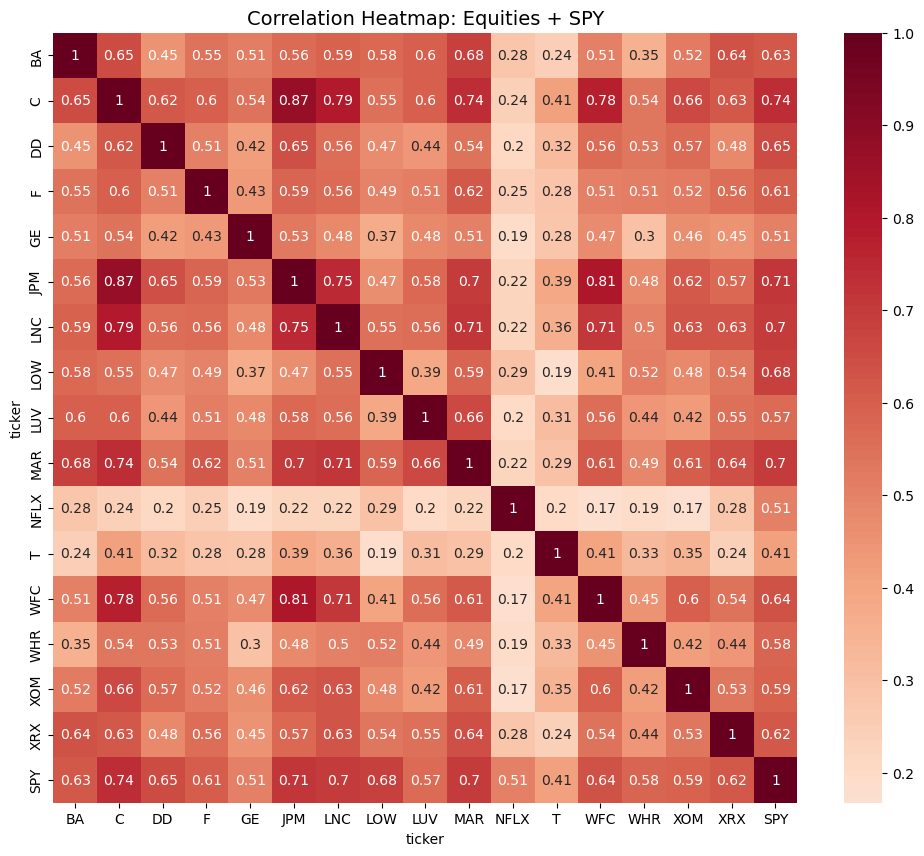

In [12]:
def plot_correlations_equity(equity_returns, spy_returns):
    """Plots a correlation heatmap for all equities plus SPY."""
    combined = equity_returns.copy()
    if 'SPY' not in combined.columns and 'SPY' in spy_returns.columns:
        combined['SPY'] = spy_returns['SPY']
    corr_matrix = combined.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0)
    plt.title("Correlation Heatmap: Equities + SPY", fontsize=14)
    plt.show()
plot_correlations_equity(equity_returns, SPY_returns)

- Many equities show correlation in the 0.5–0.8 range with one another and with SPY, underscoring a dominant market factor.
- In stable or bullish times, equities move in tandem due to common macro sentiment.
- NFLX sometimes displays moderate correlations (~0.3–0.5) with traditional industrials or financials, reflecting tech/growth idiosyncrasies.
- Also, companies undergoing structural changes (e.g., GE) occasionally drift from the pack.
- Trade tensions, pandemic surges, or monetary policy shifts often cause correlation spikes—risk-on or risk-off tends to unify equities.
- High correlation with SPY justifies using the market factor to strip out systematic equity risk, focusing on residual (idiosyncratic) signals for each ticker.

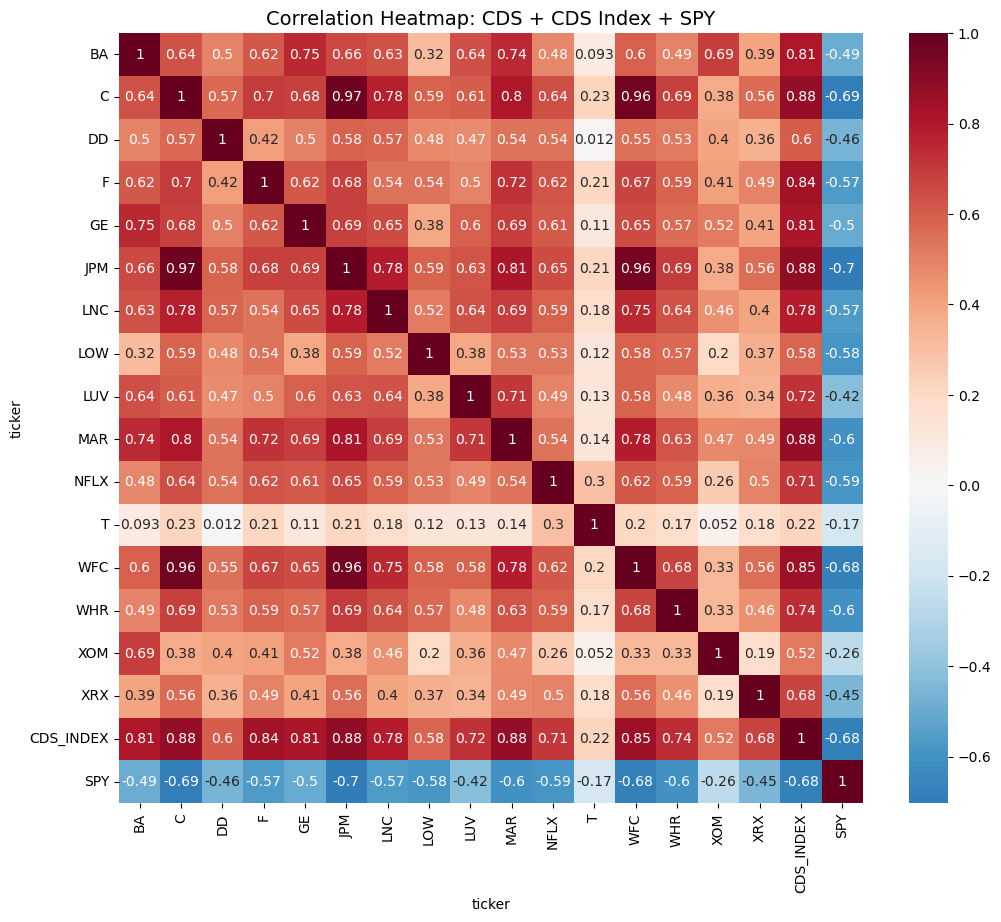

In [13]:
def plot_correlations_cds(cds_returns, cds_index_returns, spy_returns):
    """Plots a correlation heatmap for CDS tickers plus CDS Index and SPY."""
    combined_cds = cds_returns.copy()
    if 'CDS' in cds_index_returns.columns:
        combined_cds['CDS_INDEX'] = cds_index_returns['CDS']
    if 'SPY' in spy_returns.columns:
        combined_cds['SPY'] = spy_returns['SPY']
    corr_matrix = combined_cds.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0)
    plt.title("Correlation Heatmap: CDS + CDS Index + SPY", fontsize=14)
    plt.show()
plot_correlations_cds(cds_returns, cds_index_returns, SPY_returns)

- Many firm-level CDS returns exceed 0.5 correlation with the CDS Index, highlighting a robust systemic credit factor that intensifies during times of market stress.
- Equity–Credit Inversion: Negative correlations (−0.4 to −0.7) with SPY confirm the typical “equity up, spreads down” environment in risk-on modes, and “equity down, spreads widen” in risk-off modes.
- Firms with unique credit structures (NFLX) or times of sudden news might temporarily break correlation with the index, indicating potential alpha from cross-sectional divergences.
- The correlation matrix underscores that while CDS moves share a strong market factor, single names still deviate enough to exploit.
- The negative correlation with SPY also suggests an interplay for cross-asset hedging or lead-lag exploitation.

### Equity vs. CDS Returns Over Time

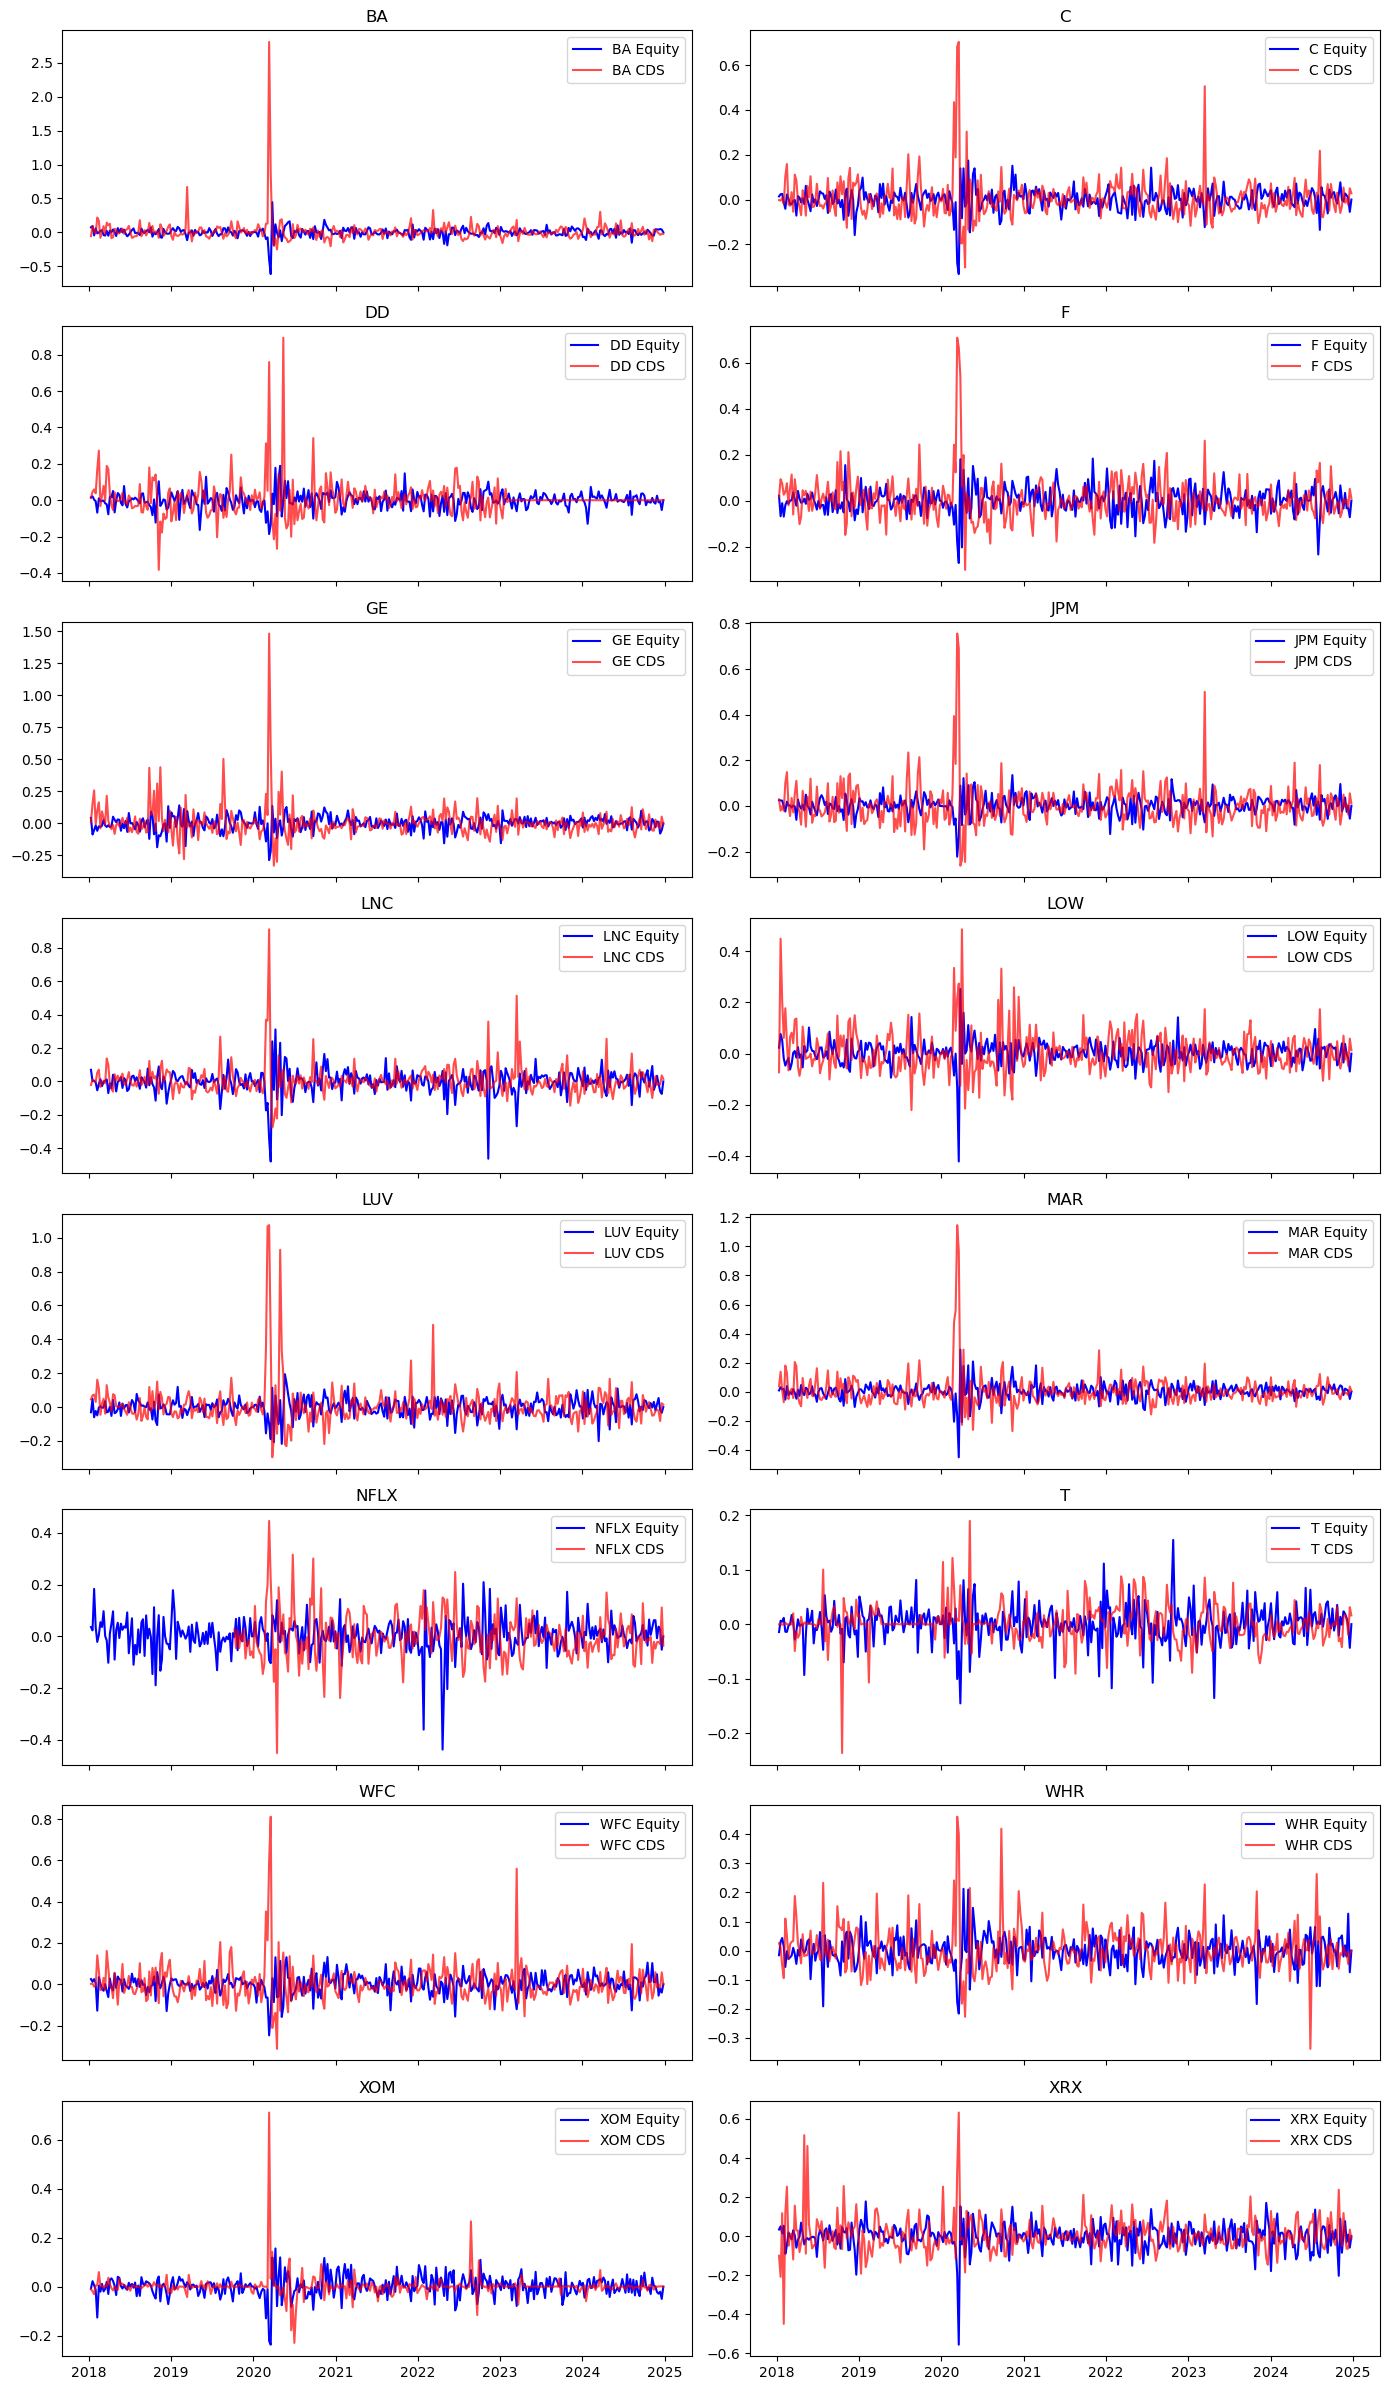

In [14]:
def plot_timeseries_equity_cds(equity_returns, cds_returns):
    """Plots 1 time-series chart per ticker (equity + CDS overlay), 2 tickers per row."""
    common_tickers = equity_returns.columns.intersection(cds_returns.columns)
    n_tickers = len(common_tickers)
    ncols = 2
    nrows = math.ceil(n_tickers / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 3*nrows), sharex=True)
    axes = axes.flatten() if nrows > 1 else [axes]

    for i, tk in enumerate(common_tickers):
        ax = axes[i]
        ax.plot(equity_returns.index, equity_returns[tk], label=f"{tk} Equity", color='blue')
        ax.plot(cds_returns.index, cds_returns[tk], label=f"{tk} CDS", color='red', alpha=0.7)
        ax.set_title(tk)
        ax.legend(loc='best')

    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()
plot_timeseries_equity_cds(equity_returns, cds_returns)

1. Equity - CDS Relationship
   - BA, DD, GE, and other industrial or cyclical names occasionally show massive CDS spikes accompanied by equity dips—highlighting acute market fear about default risk.
   - The synchronous or slightly staggered nature of these events suggests potential short-term alpha if equity signals precede CDS repricing.
   - Certain plots reveal that while equity might revert after a strong drop, CDS can remain elevated if the market perceives lingering credit risk, reinforcing the possibility of a time-lag exploitation.
2. Sectorwise Analysis
   - Financials (C, JPM, WFC) feature somewhat more frequent smaller fluctuations in both equity and CDS, consistent with incremental changes in perceived default risk tied to interest rates, capital requirements, or regulatory updates.
   - Retail/Consumer (LOW, MAR, LUV) show fairly stable periods but abrupt shocks when discretionary spending or travel sentiment shifts, such as post-lockdown travel booms or recession worries.
3. Inferences
   - In many charts, equity returns appear to react swiftly to earnings or guidance news, while CDS sometimes takes an extra week or two to adjust fully, consistent with the project’s premise that equity might lead credit.
   - Large short-term swings in CDS underscore the importance of daily or weekly tracking if one is to manage credit exposures, particularly for event-driven trades.
   - For a long–short portfolio, pairing these visuals with fundamental triggers could help mitigate catastrophic drawdowns during outlier events.

### Distribution & Lagged Scatter: Equity vs. CDS + SPY & CDS Index

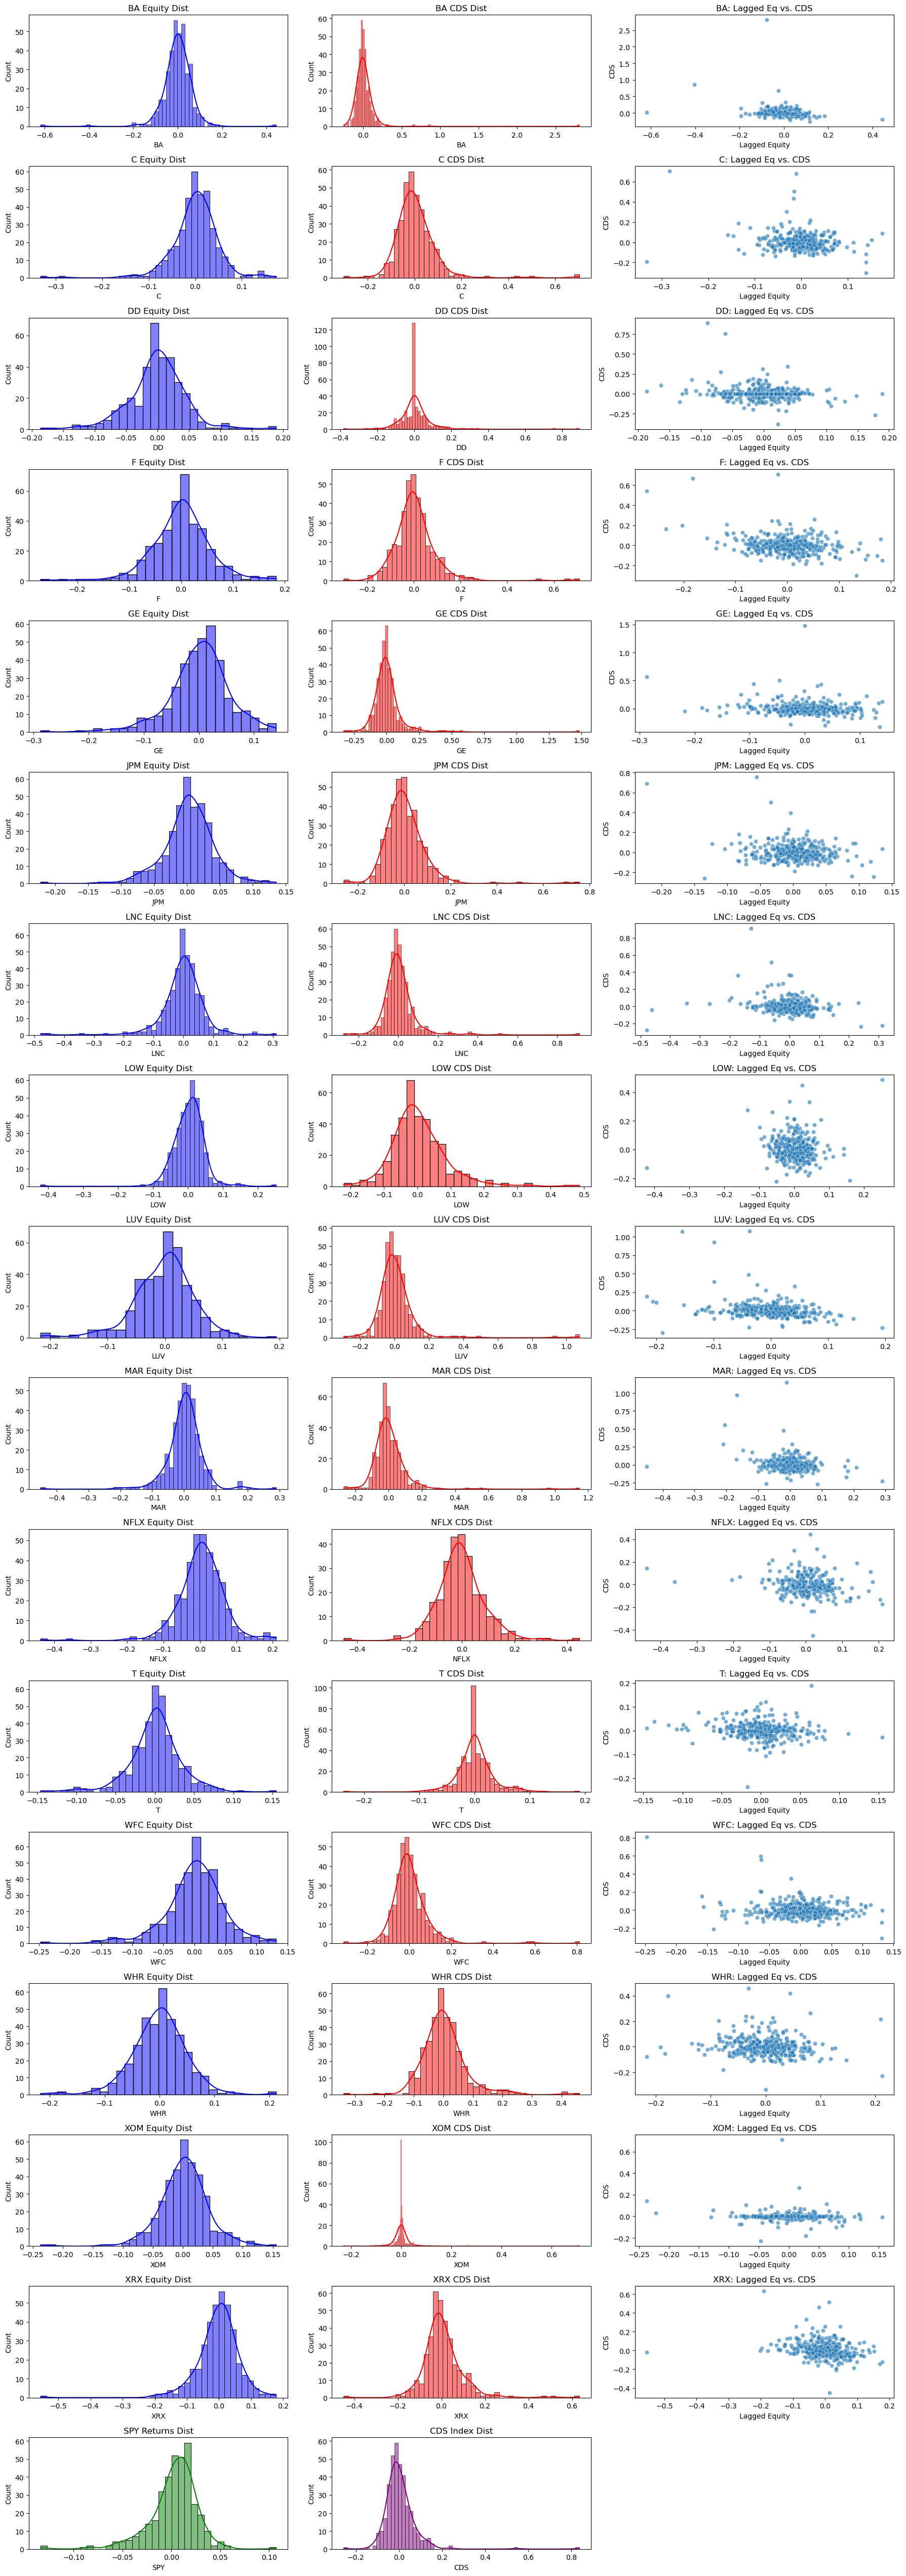

In [15]:
def plot_distributions_and_scatter_lag(equity_returns, cds_returns, spy_returns, cds_index_returns):
    """For each ticker, plots: (1) equity dist, (2) CDS dist, (3) lagged eq vs. CDS, plus final row for SPY & CDS index distributions."""
    tickers = equity_returns.columns.intersection(cds_returns.columns)
    n_tickers = len(tickers)
    fig_rows = n_tickers
    fig, axes = plt.subplots(fig_rows + 1, 3, figsize=(18, 3*(fig_rows+1)))
    lag_eq = equity_returns.shift(1)

    for i, tk in enumerate(tickers):
        eq_data = equity_returns[tk].dropna()
        cds_data = cds_returns[tk].dropna()
        ax_eq = axes[i, 0]
        ax_cds = axes[i, 1]
        ax_scatter = axes[i, 2]
        sns.histplot(eq_data, kde=True, ax=ax_eq, color='blue')
        ax_eq.set_title(f"{tk} Equity Dist")
        sns.histplot(cds_data, kde=True, ax=ax_cds, color='red')
        ax_cds.set_title(f"{tk} CDS Dist")
        sns.scatterplot(x=lag_eq[tk], y=cds_data, ax=ax_scatter, alpha=0.6)
        ax_scatter.set_xlabel("Lagged Equity")
        ax_scatter.set_ylabel("CDS")
        ax_scatter.set_title(f"{tk}: Lagged Eq vs. CDS")

    ax_spy_dist = axes[-1, 0]
    ax_cdsidx_dist = axes[-1, 1]
    ax_blank = axes[-1, 2]
    if 'SPY' in spy_returns.columns:
        sns.histplot(spy_returns['SPY'].dropna(), kde=True, ax=ax_spy_dist, color='green')
        ax_spy_dist.set_title("SPY Returns Dist")
    if 'CDS' in cds_index_returns.columns:
        sns.histplot(cds_index_returns['CDS'].dropna(), kde=True, ax=ax_cdsidx_dist, color='purple')
        ax_cdsidx_dist.set_title("CDS Index Dist")
    ax_blank.set_visible(False)
    plt.tight_layout()
    plt.show()
plot_distributions_and_scatter_lag(equity_returns, cds_returns, SPY_returns, cds_index_returns)

1. Equity & CDS Distribution Shapes
   - Most equity returns approximate a mildly skewed normal distribution, though industrials and discretionary names can exhibit more kurtosis (fat tails).
   - CDS returns often show heavier right tails, indicating the possibility of large spread blowouts with limited symmetrical “left tail” moves.
   - NFLX or T might present a slightly narrower shape, reflecting stable or improved credit.
   - This asymmetry in CDS underscores why credit risk can be disproportionately punishing—once default odds rise, spreads can balloon.
2. Lagged Equity vs. CDS Scatter
   - Many tickers (BA, C, GE, JPM) present a diffuse negative slope, signifying that positive equity residuals often correlate with negative next-week CDS changes.
   - This aligns well with a potential predictive model.
   - Some outliers on the scatter (highly positive CDS returns or large negative equity returns) highlight idiosyncratic shock events.
   - Managing these outliers is key for robust regression models.
   - A weaker relationship in certain names (NFLX, T) suggests the interplay between equity momentum and credit risk may be overshadowed by firm-specific capital structure or intangible valuation elements, meaning the strategy might selectively focus on tickers with clearer patterns.
3. Implications
   - The presence of a negative slope between last week’s equity and current CDS aligns with well-known theories around capital structure arbitrage, providing academic support for the two-stage regression approach.
   - For a trading desk, these distributions and scatter patterns are a proof-of-concept that cross-asset signals exist and can potentially be turned into systematic alpha if properly timed and risk-managed.

### Rolling 12-Week Correlations (Equity vs. CDS), plus SPY vs. CDS Index

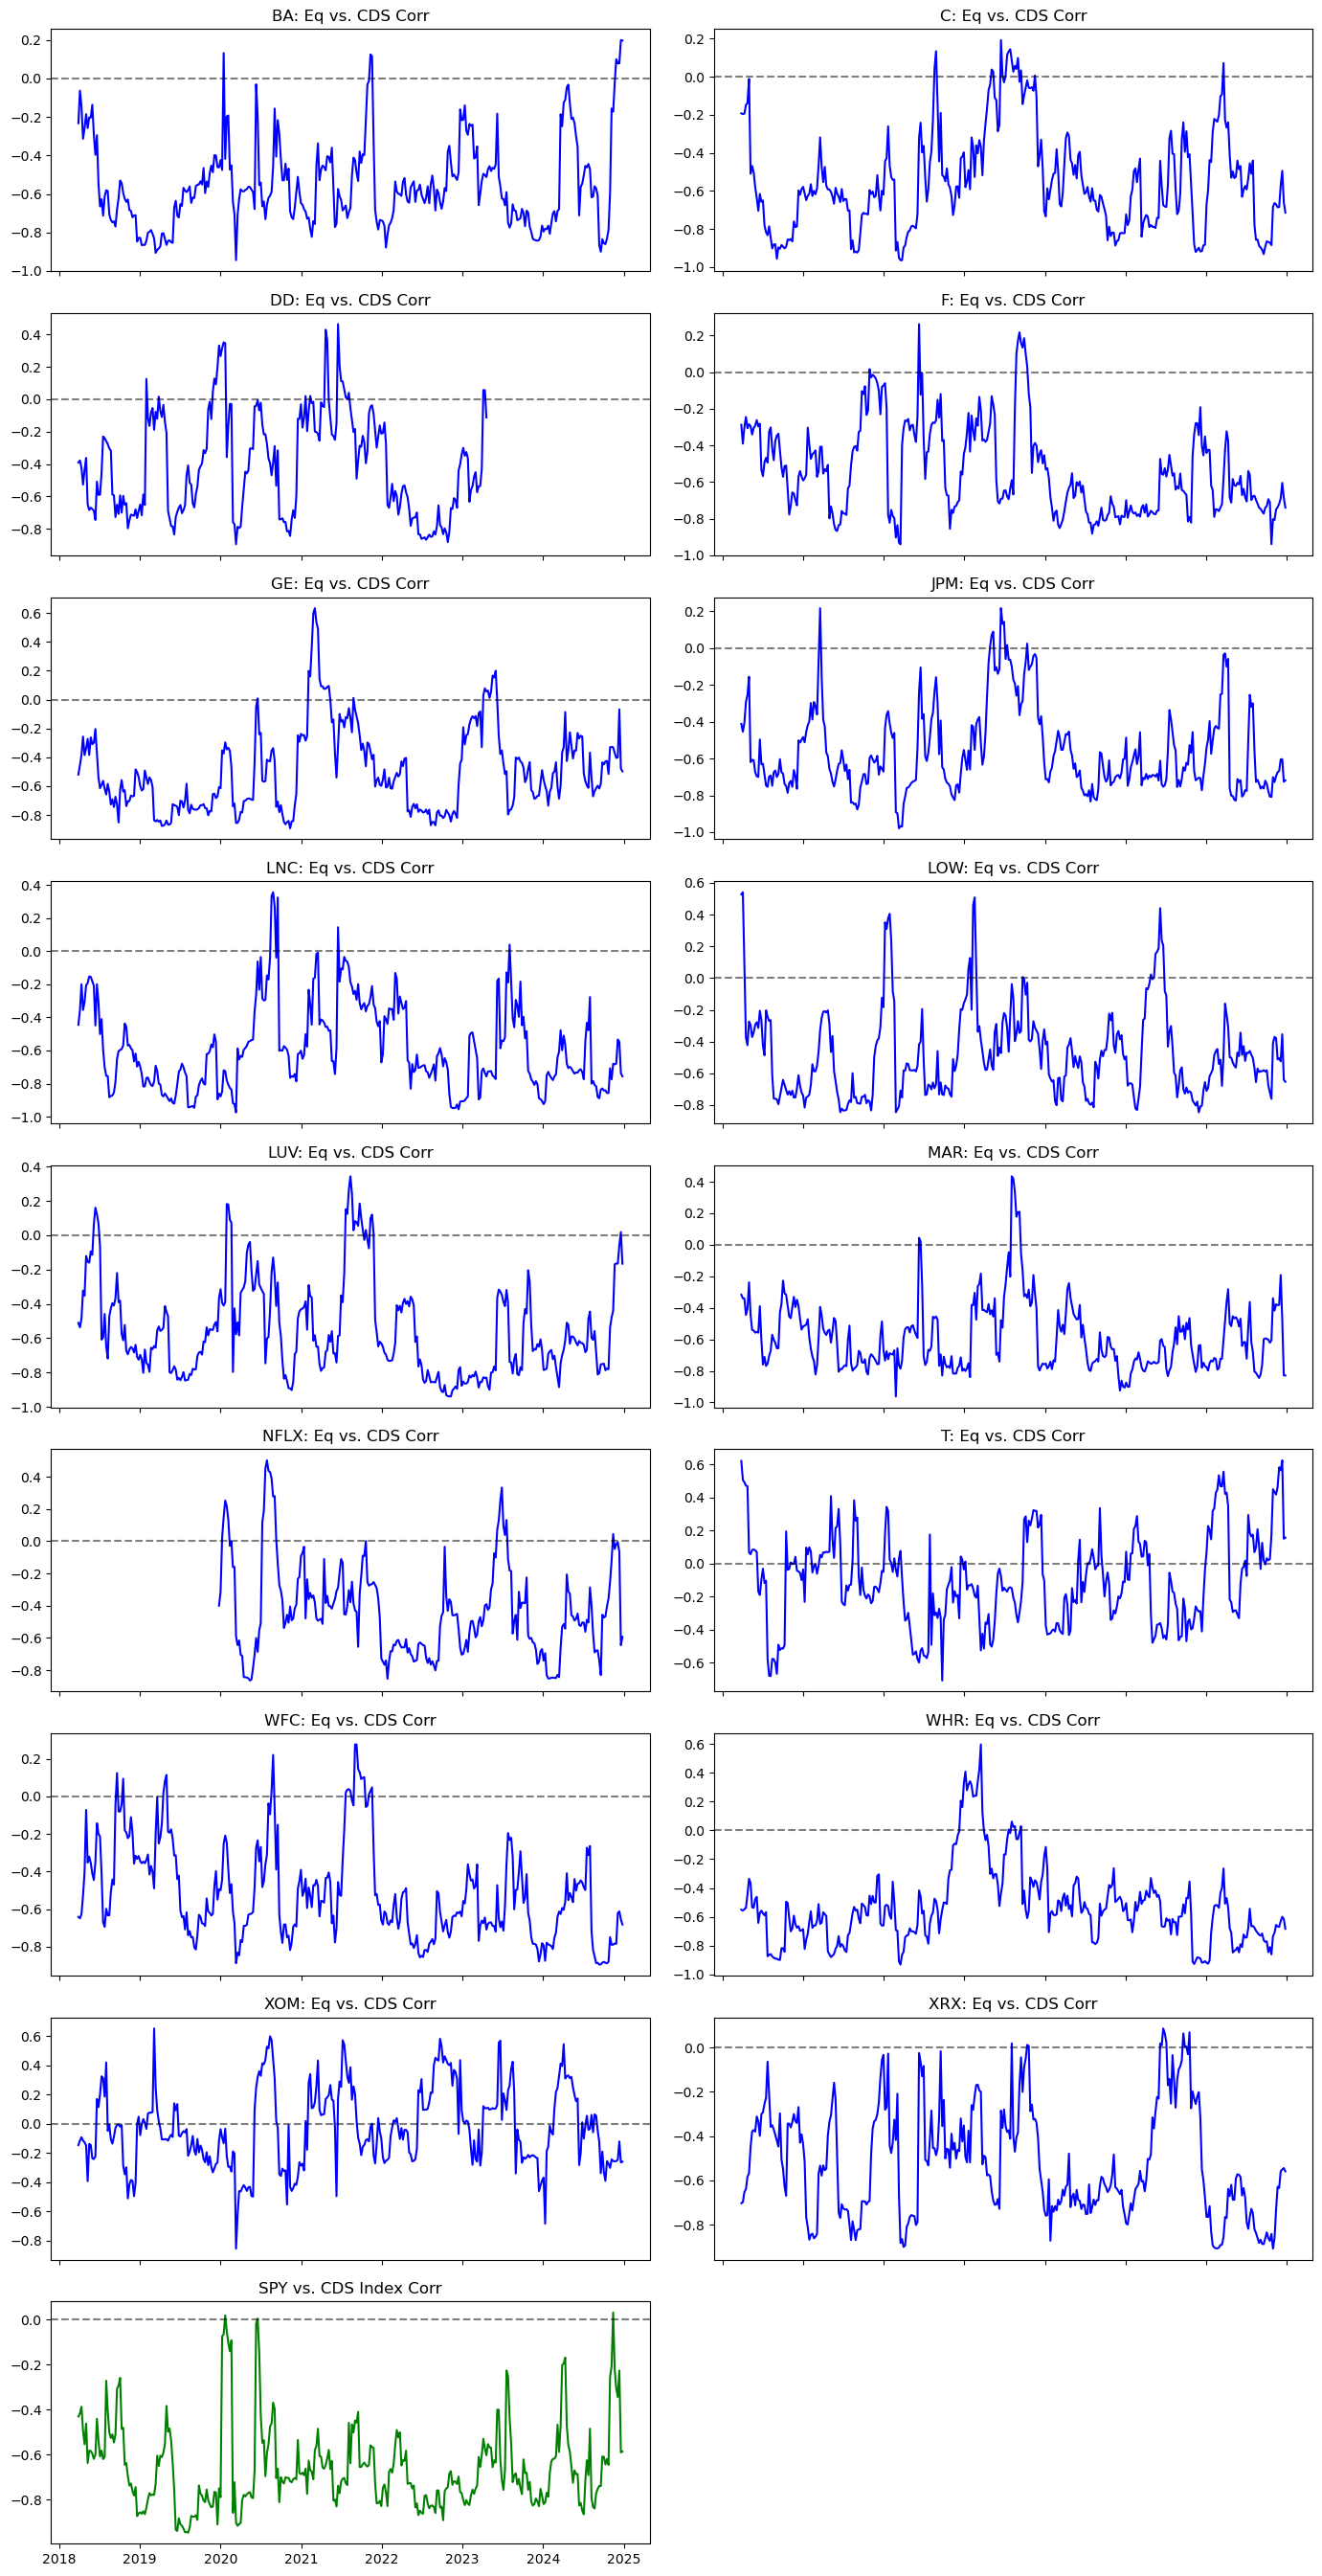

In [16]:
def plot_rolling_correlations(equity_returns, cds_returns, spy_returns, cds_index_returns, window=12):
    """One rolling correlation chart per ticker (eq vs. cds), plus one for SPY vs. CDS Index."""
    tickers = equity_returns.columns.intersection(cds_returns.columns)
    n_tickers = len(tickers)
    ncols = 2
    nrows = math.ceil((n_tickers + 1) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 3*nrows), sharex=True)
    axes = axes.flatten() if nrows > 1 else [axes]

    for i, tk in enumerate(tickers):
        ax = axes[i]
        corr_eq_cds = equity_returns[tk].rolling(window).corr(cds_returns[tk])
        ax.plot(corr_eq_cds.index, corr_eq_cds, color='blue')
        ax.axhline(0, color='k', ls='--', alpha=0.5)
        ax.set_title(f"{tk}: Eq vs. CDS Corr")

    idx_plot = i + 1
    if idx_plot < len(axes):
        ax_spy_cdsidx = axes[idx_plot]
        if 'SPY' in spy_returns.columns and 'CDS' in cds_index_returns.columns:
            corr_spy_cdsidx = spy_returns['SPY'].rolling(window).corr(cds_index_returns['CDS'])
            ax_spy_cdsidx.plot(corr_spy_cdsidx.index, corr_spy_cdsidx, color='green')
            ax_spy_cdsidx.axhline(0, color='k', ls='--', alpha=0.5)
            ax_spy_cdsidx.set_title("SPY vs. CDS Index Corr")

    for j in range(idx_plot+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()
plot_rolling_correlations(equity_returns, cds_returns, SPY_returns, cds_index_returns, window=12)

1. Equity–CDS Correlation Volatility
   - Correlation often hovers in a negative range, emphasizing the classic inverse relationship (strong equity performance tends to reduce credit spreads)
   - Large fluctuations or sign reversals (e.g., going above zero) hint at idiosyncratic catalysts (earnings surprises, lawsuits, M&A) overriding broader risk-on/off dynamics.
   - Sharp drops to near −1 typically align with major stress periods (pandemic onset, rate-hike announcements), whereas rebounds above zero can indicate strong individual equity momentum overshadowing default-risk sentiment.
2. Ticker-Specific Observations
   - BA, GE show correlation swings up to ±0.8, reflecting how headline risk (737 Max for Boeing, restructuring for GE) might break or reinforce the inverse equity–CDS link.
   - Banks (JPM, WFC, C) exhibit deeper negative correlation when financial markets are stressed, underscoring the fragility of banking sector credit perceptions.
   - Consumer-Cyclicals (MAR, LUV) can pivot rapidly with macro travel/demand news; correlation nearing zero in stable times but plunging negative in recession or crisis scares.
3. Time-Varying Regimes
   - The persistent regime changes (e.g., 2019–2020 vs. 2021–2022) confirm no static hedge ratio can hold indefinitely, justifying rolling or exponentially weighted regression.
   - Each name’s correlation path underscores how sector-specific macro events (oil price shocks for XOM, interest rates for T) transform the equity–CDS dynamic.
4. SPY vs. CDS Index
   - Usually strongly negative, consistent with risk-on markets compressing spreads while risk-off events widen them.
   - Spikes above −0.2 or below −0.8 correlate with macro policy shocks or geopolitical turmoil, highlighting the interplay between global equity sentiment and systemic credit risk.
   - These fluctuations validate the idea that broad market stress can magnify the inverse equity–credit relationship, but calmer periods allow more idiosyncratic firm-level behavior to surface.
5. Implications
   - Persistent negative correlation suggests an arbitrage possibility if equity signals systematically precede CDS moves, especially in cyclical or financially sensitive names.
   - Swings in correlation underscore the need for dynamic hedging. A simplistic offset might fail when correlation unexpectedly converges toward zero or flips positive.
   - Correlation extremes often coincide with global crises (COVID spike, inflation/rate events, geopolitical tensions), revealing that broad policy and sentiment shifts can override firm-specific fundamentals.

- The rolling correlations solidify the cross-asset narrative that equity markets often lead or mirror credit risk, but the strength and direction of that linkage is far from constant.
- This justifies the two-stage regression approach with rolling/exponential weighting, aiming to capture short-lived but repeatable lead-lag signals, while staying nimble through regime

#### Impacts on Strategy and Analysis
-  The strong correlation patterns justify using SPY for equity hedging and the CDS index for credit hedging. This helps isolate idiosyncratic signals.
-  Given time-varying correlation and distributional shifts, a dynamic approach to regression coefficients is necessary to adapt to new market regimes. So, a rolling or exponential regression to capture the time-varying regime changes will help.
-  The consistent negative slope in lagged equity vs. CDS suggests a strong lead-lag phenomenon, particularly for industrials, financials, and cyclical consumer names, suggesting an alpha potential
-  The combination of equity volatility and spiky CDS returns underscores the importance of setting position limits and employing stress tests; a single unexpected credit event can ruin an otherwise profitable strategy.
-  Throughout 2018–2025, major economic or geopolitical developments can override firm-specific fundamentals, so layering in macro signals (e.g., VIX, treasury yield curve) might enhance performance.

# Methodology

#### Two‐Stage Approach
##### Stage One (Equity Hedging):
For each firm, we determine how much of its equity return can be explained by the market (SPY). By removing this market‐driven portion, we isolate an “idiosyncratic equity return.”
##### Stage Two (CDS Hedging):
In parallel, the firm’s CDS return is decomposed into systematic (firm equity + overall credit market) versus the specific “firm‐level” residual. This leaves a purely idiosyncratic component for the CDS, representing signals not captured by general market movements.
##### Predictive Mechanism
Once the firm’s idiosyncratic equity return is known, we measure how it correlates with the following week’s idiosyncratic CDS movement. If the previous week’s equity residual has predictive power for the firm’s CDS behavior, the model captures that signal to forecast short‐horizon changes in the CDS spread.

#### Trading Implementation
##### Signal Thresholding:
Only strong signals—where the model’s forecasted CDS change exceeds a certain absolute threshold or lies in a designated quantile—trigger a trade. This filters out minor predictions likely to be noise.
##### Portfolio Construction:
If the model predicts an increase in the firm’s idiosyncratic CDS, we take a long position in that CDS (and vice versa). The notional size is typically proportional to the intensity of the signal.
##### Hedged vs. Unhedged:
In the hedged version, we neutralize both equity and broad credit index exposure, capturing only firm‐specific risk.
In the unhedged version, we skip hedging the CDS index, thus retaining some systematic credit beta.

#### Evaluation & Optimization
##### Grid Search:
We systematically vary window sizes, half‐lives (for exponential weighting), and signal thresholds or quantiles. Each parameter set is tested against historical returns to find the optimal risk‐adjusted performance.
##### Performance Metrics:
We measure annualized return, volatility, Sharpe ratio, Sortino ratio, and maximum drawdowns to compare different parameter sets.
##### Factor Exposures:
We regress the strategy’s returns on standard equity factors (e.g., Fama–French) to check whether its performance is truly idiosyncratic or just repackaged market risk.
##### Regime Analysis:
We assess results under varied volatility and interest‐rate environments, gauging how the strategy holds up across different market regimes.

In [17]:
# Regression Models
# Box Car Regression
def rolling_ols_no_intercept_statsmodels(x_series, y_series, window=20):
    betas = np.full_like(y_series, np.nan, dtype=float)
    for i in range(len(y_series)):
        start = i - window
        if start < 0:
            continue
        xs = x_series[start:i]
        ys = y_series[start:i]
        valid = (~xs.isna()) & (~ys.isna())
        if valid.sum()<2:
            continue
        xs_clean = xs[valid]
        ys_clean = ys[valid]
        # Statsmodels OLS with no intercept => pass data directly
        model = sm.OLS(ys_clean, xs_clean).fit()
        betas[i] = model.params[0] if len(model.params)==1 else np.nan
    return betas

# Exponential Decay Regression
def exp_weighted_ols_no_intercept_statsmodels(x_series, y_series, half_life=20):
    betas = np.full_like(y_series, np.nan, dtype=float)
    alpha = 0.5 ** (1.0 / half_life)
    for i in range(len(y_series)):
        weights = []
        xvals = []
        yvals = []
        for j in range(i, -1, -1):
            if not (pd.isna(x_series.iloc[j]) or pd.isna(y_series.iloc[j])):
                w = alpha ** (i-j)
                weights.append(w)
                xvals.append(x_series.iloc[j])
                yvals.append(y_series.iloc[j])
        if len(xvals)<2:
            continue
        xarr = np.array(xvals, dtype=float)
        yarr = np.array(yvals, dtype=float)
        warr = np.array(weights, dtype=float)
        model = sm.WLS(yarr, xarr, weights=warr).fit()
        betas[i] = model.params[0] if len(model.params)==1 else np.nan
    return betas

In [43]:
# Running 2 Stage Regression - Contemporaneous + Predictive Regression
def run_two_stage_regression(equity_returns, cds_returns, cds_index_returns, spy_returns,
                             start_date=None, end_date=None,
                             window_equity=20, window_cds=20, window_pred=20,
                             half_life_equity=20, half_life_cds=20, half_life_pred=20,
                             use_boxcar_equity=True, use_boxcar_cds=True, use_boxcar_pred=True):
    dates = equity_returns.index
    if start_date is not None:
        dates = dates[dates>=pd.to_datetime(start_date)]
    if end_date is not None:
        dates = dates[dates<=pd.to_datetime(end_date)]
    common = dates.intersection(cds_returns.index).intersection(spy_returns.index).intersection(cds_index_returns.index)
    common = common.sort_values()
    
    tickers = equity_returns.columns.intersection(cds_returns.columns)
    
    gamma = pd.DataFrame(index=common, columns=tickers, dtype=float)
    beta_equity = pd.DataFrame(index=common, columns=tickers, dtype=float)
    beta_index = pd.DataFrame(index=common, columns=tickers, dtype=float)
    c = pd.DataFrame(index=common, columns=tickers, dtype=float)
    rho = pd.DataFrame(index=common, columns=tickers, dtype=float)
    mu = pd.DataFrame(index=common, columns=tickers, dtype=float)
    pred_rho = pd.DataFrame(index=common, columns=tickers, dtype=float)
    
    for tk in tickers:
        eq = equity_returns[tk].reindex(common)
        cds_ = cds_returns[tk].reindex(common)
        m = spy_returns['SPY'].reindex(common)
        idx_ = cds_index_returns['CDS'].reindex(common)
        # First Regression - Stock returns on market returns - Get Gamma (slope) and c (Idiosynchratic Equity Return)
        if use_boxcar_equity:
            gvals = rolling_ols_no_intercept_statsmodels(m, eq, window=window_equity)
        else:
            gvals = exp_weighted_ols_no_intercept_statsmodels(m, eq, half_life=half_life_equity)
        gamma[tk] = gvals
        cvals = eq - gvals*m
        # Second Regression - CDS on CDS Equity and CDS Index - Get Slope (Beta Equity and Beta Index) and rho (Idiosynchratic CDS Returns)
        if use_boxcar_cds:
            b_eq_vals = rolling_ols_no_intercept_statsmodels(eq, cds_, window=window_cds)
            b_idx_vals = rolling_ols_no_intercept_statsmodels(idx_, cds_, window=window_cds)
        else:
            b_eq_vals = exp_weighted_ols_no_intercept_statsmodels(eq, cds_, half_life=half_life_cds)
            b_idx_vals = exp_weighted_ols_no_intercept_statsmodels(idx_, cds_, half_life=half_life_cds)
        beta_equity[tk] = b_eq_vals
        beta_index[tk] = b_idx_vals
        f = b_eq_vals * eq + b_idx_vals * idx_
        rvals = cds_ - f
        c[tk] = cvals
        rho[tk] = rvals
        c_shift = cvals.shift(1)
        # Third Regression - Predictive Regression - Idiosyncratic CDS Rerturns on Idiosyncratic equity returns - Get Mu (Slope) and predicted rho
        if use_boxcar_pred:
            mvals = rolling_ols_no_intercept_statsmodels(c_shift, rvals, window=window_pred)
        else:
            mvals = exp_weighted_ols_no_intercept_statsmodels(c_shift, rvals, half_life=half_life_pred)
        mu[tk] = mvals
        pred_rho[tk] = mvals * c_shift
    return gamma, beta_equity, beta_index, c, rho, mu, pred_rho

In [33]:
start_date = str(cds.index.min()).split(" ")[0]
end_date = str(cds.index.max()).split(" ")[0]
gamma, beta_equity, beta_index, c, rho, mu, pred_rho = run_two_stage_regression(equity_returns, cds_returns, cds_index_returns, SPY_returns,
                             start_date='2018-01-03', end_date='2024-12-25',
                             window_equity=12, window_cds=12, window_pred=12,
                             half_life_equity=20, half_life_cds=20, half_life_pred=20,
                             use_boxcar_equity=True, use_boxcar_cds=True, use_boxcar_pred=True)

In [35]:
# Backtest Hedged Portfolio (Threshold/ Quantile Based)
def backtest_hedged_portfolio(rho, pred_rho, start_date=None, end_date=None,
                              threshold=None, quantile=None, capital=10_000_000,
                              trans_cost=0.0, long_short=False):
    dates = pred_rho.index
    if start_date is not None:
        dates = dates[dates>=pd.to_datetime(start_date)]
    if end_date is not None:
        dates = dates[dates<=pd.to_datetime(end_date)]
    dates = dates.sort_values()
    tickers = pred_rho.columns
    pos_df = pd.DataFrame(0.0, index=dates, columns=tickers)
    trade_df = pd.DataFrame(0.0, index=dates, columns=tickers)
    
    for dt in dates:
        # Signals = Predicted Predictions
        preds = pred_rho.loc[dt]
        # Returns = Hedged cds Portfolio returns
        rets = rho.loc[dt]
        valid = preds[~preds.isna()]
        if len(valid)==0:
            continue
        if threshold is not None:
            keep = valid[valid.abs()>threshold]
            if keep.abs().sum()==0:
                continue
            for tk in keep.index:
                sign_ = np.sign(keep[tk])
                frac = abs(keep[tk])/abs(keep).sum()
                size = frac*capital
                pos_df.at[dt, tk] = sign_*size
        elif quantile is not None:
            mag = valid.abs()
            cutoff = mag.quantile(quantile)
            chosen = mag[mag>=cutoff].index
            if len(chosen)==0:
                continue
            selected = valid[chosen]
            if long_short:
                longs = selected[selected>0]
                shorts = selected[selected<0]
                sum_long = longs.abs().sum()
                sum_short = shorts.abs().sum()
                cap_each = capital*0.5
                for tk in longs.index:
                    frac = abs(longs[tk])/sum_long if sum_long!=0 else 0
                    pos_df.at[dt, tk] = frac*cap_each
                for tk in shorts.index:
                    frac = abs(shorts[tk])/sum_short if sum_short!=0 else 0
                    pos_df.at[dt, tk] = -frac*cap_each
            else:
                sum_abs = abs(selected).sum()
                for tk in selected.index:
                    frac = abs(selected[tk])/sum_abs if sum_abs!=0 else 0
                    pos_df.at[dt, tk] = np.sign(selected[tk])*frac*capital
    pnl_list = []
    cumulative = 0.0
    sorted_dates = dates.sort_values()
    for i in range(len(sorted_dates)-1):
        d_now = sorted_dates[i]
        d_next = sorted_dates[i+1]
        pos_now = pos_df.loc[d_now]
        ret_next = rho.loc[d_next]
        if pos_now.isna().all() or ret_next.isna().all():
            pnl_list.append((d_next, 0.0, 0.0))
            continue
        cost = trans_cost*abs(pos_now).sum()
        realized = 0.0
        for tk in tickers:
            if not (pd.isna(pos_now[tk]) or pd.isna(ret_next[tk])):
                realized += pos_now[tk]*ret_next[tk]
        realized -= cost
        cumulative += realized
        pnl_list.append((d_next, realized, cumulative))
    trades = pd.DataFrame(pnl_list, columns=['date','pnl','cum_pnl']).set_index('date')
    return pos_df, trades

In [36]:
pos_df, trades = backtest_hedged_portfolio(rho, pred_rho, start_date=None, end_date=None,
                              threshold=None, quantile=0.2, capital=10_000_000,
                              trans_cost=0.0, long_short=True)

In [37]:
def compute_performance_metrics(pnl_df, capital=10_000_000, freq='W'):
    if len(pnl_df)<2 or 'pnl' not in pnl_df.columns or 'cum_pnl' not in pnl_df.columns:
        return {}
    if freq=='W':
        annual_factor = 52
    elif freq=='D':
        annual_factor = 252
    elif freq=='M':
        annual_factor = 12
    else:
        annual_factor = 52
    rets_abs = pnl_df['pnl']
    ret_rel = rets_abs / capital
    mean_ret = ret_rel.mean()
    vol_ret = ret_rel.std()
    ann_ret = mean_ret * annual_factor
    ann_vol = vol_ret * math.sqrt(annual_factor) if vol_ret>0 else np.nan
    ann_sharpe = ann_ret/ann_vol if not np.isnan(ann_vol) and ann_vol>0 else np.nan
    neg_rets = ret_rel[ret_rel<0]
    if len(neg_rets)>0:
        downside_std = neg_rets.std()
        ann_downside = downside_std*math.sqrt(annual_factor)
        sortino = ann_ret/ann_downside if ann_downside>0 else np.nan
    else:
        sortino = np.nan
    eq_curve = capital + pnl_df['cum_pnl']
    peak = eq_curve.iloc[0]
    drawdown = 0.0
    for val in eq_curve:
        if val>peak:
            peak=val
        dd = (val-peak)
        if dd<drawdown:
            drawdown=dd
    max_dd = abs(drawdown)
    idx_diff = (pnl_df.index[-1]-pnl_df.index[0]).days
    years = idx_diff/365.25 if idx_diff>0 else 0
    cagr = np.nan
    if years>0 and eq_curve.iloc[0]!=0:
        cagr = (eq_curve.iloc[-1]/eq_curve.iloc[0])**(1/years)-1
    return {
        'mean_weekly_pnl': rets_abs.mean(),
        'mean_rel_ret_weekly': mean_ret,
        'annualized_return': ann_ret,
        'annualized_vol': ann_vol,
        'annual_sharpe': ann_sharpe,
        'sortino_ratio': sortino,
        'max_drawdown_abs': max_dd,
        'total_pnl': pnl_df['cum_pnl'].iloc[-1],
        'final_portfolio_value': eq_curve.iloc[-1],
        'cagr': cagr
    }

In [38]:
pd.DataFrame.from_dict(compute_performance_metrics(trades), orient='index').T

mean_weekly_pnl  mean_rel_ret_weekly  annualized_return  annualized_vol  \
0     39882.466843             0.003988           0.207389         0.37066   

   annual_sharpe  sortino_ratio  max_drawdown_abs     total_pnl  \
0       0.559512       0.609542      5.703573e+06  1.447734e+07   

   final_portfolio_value      cagr  
0           2.447734e+07  0.137722

In [112]:
def grid_search_params(equity_returns, cds_returns, cds_index_returns, spy_returns,
                       windows=[10, 15, 20], half_lives=[10, 15, 20],
                       thresholds=[0.003, 0.005, 0.007],
                       quantiles=[0.2, 0.3, 0.4],
                       capital=10_000_000, trans_cost=0.0, long_short=False,
                       start_date=None, end_date=None):

    from functools import lru_cache
    from tqdm import tqdm

    @lru_cache(None)
    def run_two_stage_regression_cached(window, hl, regression_method):
        use_boxcar = (regression_method == 'boxcar')
        return run_two_stage_regression(
            equity_returns, cds_returns, cds_index_returns, spy_returns,
            start_date, end_date,
            window, window, window,      
            hl, hl, hl,                 
            use_boxcar, use_boxcar, use_boxcar
        )
    
    results = []
    total_combos = len(windows) * len(half_lives) * 2
    
    with tqdm(total=total_combos, desc="Grid Search Progress") as pbar:
        for window in windows:
            for hl in half_lives:
                for regression_method in ['boxcar', 'exponential']:
                    gamma, beta_equity, beta_index, c, rho, mu, pred_rho = run_two_stage_regression_cached(window, hl, regression_method)
                    for t in thresholds:
                        pos_thr, trades_thr = backtest_hedged_portfolio(
                            rho, pred_rho, start_date, end_date,
                            threshold=t, quantile=None,
                            capital=capital, trans_cost=trans_cost,
                            long_short=long_short
                        )
                        met_thr = compute_performance_metrics(trades_thr)
                        row_thr = {
                            'regression_method': regression_method,
                            'backtest_strategy': 'threshold',
                            'window_eq': window,
                            'window_cds': window,
                            'window_pred': window,
                            'hl_eq': hl,
                            'hl_cds': hl,
                            'hl_pred': hl,
                            'threshold': t,
                            'quantile': None
                        }
                        row_thr.update(met_thr)
                        results.append(row_thr)
                    
                    for q in quantiles:
                        pos_q, trades_q = backtest_hedged_portfolio(
                            rho, pred_rho, start_date, end_date,
                            threshold=None, quantile=q,
                            capital=capital, trans_cost=trans_cost,
                            long_short=long_short
                        )
                        met_q = compute_performance_metrics(trades_q)
                        row_q = {
                            'regression_method': regression_method,
                            'backtest_strategy': 'quantile',
                            'window_eq': window,
                            'window_cds': window,
                            'window_pred': window,
                            'hl_eq': hl,
                            'hl_cds': hl,
                            'hl_pred': hl,
                            'threshold': None,
                            'quantile': q
                        }
                        row_q.update(met_q)
                        results.append(row_q)
                    
                    pbar.update(1)
    
    return pd.DataFrame(results)

In [118]:
grid_search_results_no_ls = grid_search_params(equity_returns, cds_returns, cds_index_returns, SPY_returns,
                       windows=[5, 10,15, 20, 25], half_lives=[5, 10,15, 20, 25], thresholds=[0.001, 0.003, 0.005, 0.007, 0.009],
                       quantiles=[0.1, 0.2, 0.3, 0.4], capital=10_000_000, trans_cost=0.0,
                       long_short=False, start_date=None, end_date=None)

Grid Search Progress: 100%|█████████████████████| 50/50 [14:08<00:00, 16.97s/it]


In [121]:
grid_search_results = grid_search_results_no_ls.copy(deep=True)
grid_search_results

regression_method backtest_strategy  window_eq  window_cds  window_pred  \
0              boxcar         threshold          5           5            5   
1              boxcar         threshold          5           5            5   
2              boxcar         threshold          5           5            5   
3              boxcar         threshold          5           5            5   
4              boxcar         threshold          5           5            5   
..                ...               ...        ...         ...          ...   
445       exponential         threshold         25          25           25   
446       exponential          quantile         25          25           25   
447       exponential          quantile         25          25           25   
448       exponential          quantile         25          25           25   
449       exponential          quantile         25          25           25   

     hl_eq  hl_cds  hl_pred  threshold  quantile  mean_weekly_pnl  \
0        5       5        5      0.001       NaN    -15074.263830   
1        5       5        5      0.003       NaN    -14850.228587   
2        5       5        5      0.005       NaN    -13408.878747   
3        5       5        5      0.007       NaN    -13843.660905   
4        5       5        5      0.009       NaN     -9250.495465   
..     ...     ...      ...        ...       ...              ...   
445     25      25       25      0.009       NaN     71177.108311   
446     25      25       25        NaN       0.1     52590.152130   
447     25      25       25        NaN       0.2     53288.082141   
448     25      25       25        NaN       0.3     54208.055983   
449     25      25       25        NaN       0.4     54206.454930   

     mean_rel_ret_weekly  annualized_return  annualized_vol  annual_sharpe  \
0              -0.001507          -0.078386        0.393444      -0.199231   
1              -0.001485          -0.077221        0.398130      -0.193960   
2              -0.001341          -0.069726        0.408853      -0.170541   
3              -0.001384          -0.071987        0.420065      -0.171371   
4              -0.000925          -0.048103        0.438711      -0.109645   
..                   ...                ...             ...            ...   
445             0.007118           0.370121        0.550783       0.671990   
446             0.005259           0.273469        0.497200       0.550018   
447             0.005329           0.277098        0.498841       0.555484   
448             0.005421           0.281882        0.503934       0.559362   
449             0.005421           0.281874        0.506014       0.557047   

     sortino_ratio  max_drawdown_abs     total_pnl  final_portfolio_value  \
0        -0.186975      1.096024e+07 -5.471958e+06           4.528042e+06   
1        -0.184507      1.133454e+07 -5.390633e+06           4.609367e+06   
2        -0.163085      1.105159e+07 -4.867423e+06           5.132577e+06   
3        -0.165198      1.141992e+07 -5.025249e+06           4.974751e+06   
4        -0.107694      1.048143e+07 -3.357930e+06           6.642070e+06   
..             ...               ...           ...                    ...   
445       0.759994      7.492458e+06  2.583729e+07           3.583729e+07   
446       0.637157      6.809544e+06  1.909023e+07           2.909023e+07   
447       0.643859      6.713774e+06  1.934357e+07           2.934357e+07   
448       0.649725      6.711458e+06  1.967752e+07           2.967752e+07   
449       0.650638      6.946045e+06  1.967694e+07           2.967694e+07   

         cagr  
0   -0.107922  
1   -0.105630  
2   -0.091661  
3   -0.095741  
4   -0.057271  
..        ...  
445  0.201992  
446  0.166392  
447  0.167850  
448  0.169757  
449  0.169754  

[450 rows x 20 columns]

In [127]:
grid_search_results[grid_search_results['annual_sharpe'] == grid_search_results['annual_sharpe'].max()]

regression_method backtest_strategy  window_eq  window_cds  window_pred  \
94             boxcar         threshold         10          10           10   
112            boxcar         threshold         10          10           10   
130            boxcar         threshold         10          10           10   
148            boxcar         threshold         10          10           10   
166            boxcar         threshold         10          10           10   

     hl_eq  hl_cds  hl_pred  threshold  quantile  mean_weekly_pnl  \
94       5       5        5      0.009       NaN     54191.651255   
112     10      10       10      0.009       NaN     54191.651255   
130     15      15       15      0.009       NaN     54191.651255   
148     20      20       20      0.009       NaN     54191.651255   
166     25      25       25      0.009       NaN     54191.651255   

     mean_rel_ret_weekly  annualized_return  annualized_vol  annual_sharpe  \
94              0.005419           0.281797        0.330966       0.851437   
112             0.005419           0.281797        0.330966       0.851437   
130             0.005419           0.281797        0.330966       0.851437   
148             0.005419           0.281797        0.330966       0.851437   
166             0.005419           0.281797        0.330966       0.851437   

     sortino_ratio  max_drawdown_abs     total_pnl  final_portfolio_value  \
94        1.012897      5.561401e+06  1.967157e+07           2.967157e+07   
112       1.012897      5.561401e+06  1.967157e+07           2.967157e+07   
130       1.012897      5.561401e+06  1.967157e+07           2.967157e+07   
148       1.012897      5.561401e+06  1.967157e+07           2.967157e+07   
166       1.012897      5.561401e+06  1.967157e+07           2.967157e+07   

         cagr  
94   0.169723  
112  0.169723  
130  0.169723  
148  0.169723  
166  0.169723

# Results and Analysis

## Grid Search Results Analysis

In [181]:
def preprocess_grid_results(df):
    """Prepares and filters the raw grid search DataFrame."""
    if 'regression_method' in df.columns and 'method' not in df.columns:
        df.rename(columns={'regression_method': 'method'}, inplace=True)
    df = df.copy()
    numeric_cols = [
        'window_eq','window_cds','window_pred',
        'hl_eq','hl_cds','hl_pred','threshold','quantile',
        'mean_weekly_pnl','mean_rel_ret_weekly','annualized_return',
        'annualized_vol','annual_sharpe','sortino_ratio','max_drawdown_abs',
        'total_pnl','final_portfolio_value','cagr'
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=['annual_sharpe'])
    return df

def top_n_summary(df, top_n=10):
    """Returns best parameters by annual_sharpe and summary info."""
    best_idx = df['annual_sharpe'].idxmax()
    best_row = df.loc[best_idx].to_frame().T
    top_n_df = df.sort_values('annual_sharpe', ascending=False).head(top_n)
    return best_row, top_n_df

def summarize_by_method(df):
    """Summarizes performance by method if available."""
    if 'method' not in df.columns:
        return None
    group_stats = df.groupby('method').agg({
        'annual_sharpe': ['mean','max'],
        'annualized_vol':'mean',
        'max_drawdown_abs':'mean',
        'total_pnl':'mean',
        'cagr':'mean'
    }).reset_index()
    group_stats.columns = [
        'method','annual_sharpe_mean','annual_sharpe_max',
        'annualized_vol_mean','max_drawdown_abs_mean',
        'total_pnl_mean','cagr_mean'
    ]
    return group_stats

def plot_distribution_of_sharpe(df, save_charts=False, charts_dir="charts"):
    """Plots distribution of annual_sharpe by method."""
    if 'method' in df.columns:
        plt.figure(figsize=(6,4))
        sns.boxplot(data=df, x='method', y='annual_sharpe')
        plt.title("Annual Sharpe by Method")
        plt.tight_layout()
        if save_charts:
            if not os.path.exists(charts_dir):
                os.makedirs(charts_dir)
            plt.savefig(os.path.join(charts_dir,"boxplot_annual_sharpe_by_method.png"), dpi=200)
        plt.show()

def plot_parameter_sensitivity(df, save_charts=False, charts_dir="charts"):
    """Plots how annual_sharpe changes with window_eq and half-lives."""
    if 'window_eq' in df.columns:
        plt.figure(figsize=(8,5))
        grp = df.groupby('window_eq')['annual_sharpe'].mean().reset_index()
        sns.lineplot(data=grp, x='window_eq', y='annual_sharpe', marker='o')
        plt.title("Mean Sharpe vs window_eq")
        plt.xlabel("window_eq")
        plt.ylabel("Mean Annual Sharpe")
        plt.tight_layout()
        if save_charts:
            if not os.path.exists(charts_dir):
                os.makedirs(charts_dir)
            plt.savefig(os.path.join(charts_dir,"line_sharpe_vs_window_eq.png"), dpi=200)
        plt.show()

    half_life_cols = [col for col in ['hl_eq'] if col in df.columns]
    if len(half_life_cols) > 0:
        fig, axes = plt.subplots(1, len(half_life_cols), figsize=(6*len(half_life_cols),5), sharey=True)
        if len(half_life_cols) == 1:
            axes = [axes]
        for ax, param in zip(axes, half_life_cols):
            grp = df.groupby(param)['annual_sharpe'].mean().reset_index()
            sns.lineplot(data=grp, x=param, y='annual_sharpe', marker='o', ax=ax)
            ax.set_title(f"Mean Sharpe vs {param}")
            ax.set_xlabel(param)
            ax.set_ylabel("Mean Annual Sharpe")
        plt.tight_layout()
        if save_charts:
            plt.savefig(os.path.join(charts_dir,"line_sharpe_vs_halflives.png"), dpi=200)
        plt.show()

def plot_threshold_sensitivity(df, save_charts=False, charts_dir="charts"):
    """Plots mean sharpe vs threshold/quantile depending on method."""
    if 'method' not in df.columns:
        return

    thresh_df = df[df['method']=='threshold'].copy()
    if len(thresh_df)>0 and 'threshold' in thresh_df.columns:
        grp = thresh_df.groupby('threshold')['annual_sharpe'].mean().reset_index()
        plt.figure(figsize=(7,5))
        sns.lineplot(data=grp, x='threshold', y='annual_sharpe', marker='o')
        plt.title("Mean Sharpe vs Threshold")
        plt.xlabel("Threshold")
        plt.ylabel("Mean Annual Sharpe")
        plt.tight_layout()
        if save_charts:
            if not os.path.exists(charts_dir):
                os.makedirs(charts_dir)
            plt.savefig(os.path.join(charts_dir,"line_sharpe_vs_threshold.png"), dpi=200)
        plt.show()

    quant_df = df[df['method']=='quantile'].copy()
    if len(quant_df)>0 and 'quantile' in quant_df.columns:
        grp = quant_df.groupby('quantile')['annual_sharpe'].mean().reset_index()
        plt.figure(figsize=(7,5))
        sns.lineplot(data=grp, x='quantile', y='annual_sharpe', marker='o')
        plt.title("Mean Sharpe vs Quantile")
        plt.xlabel("Quantile")
        plt.ylabel("Mean Annual Sharpe")
        plt.tight_layout()
        if save_charts:
            plt.savefig(os.path.join(charts_dir,"line_sharpe_vs_quantile.png"), dpi=200)
        plt.show()

def plot_risk_return_scatter(df, save_charts=False, charts_dir="charts"):
    """Plots scatter relationships between risk and return metrics."""
    if 'annualized_vol' in df.columns and 'annual_sharpe' in df.columns:
        plt.figure(figsize=(7,5))
        if 'method' in df.columns:
            sns.scatterplot(data=df, x='annualized_vol', y='annual_sharpe', hue='method')
        else:
            sns.scatterplot(data=df, x='annualized_vol', y='annual_sharpe')
        plt.title("Annual Sharpe vs Annualized Vol")
        plt.xlabel("Annualized Vol")
        plt.ylabel("Annual Sharpe")
        plt.tight_layout()
        if save_charts:
            if not os.path.exists(charts_dir):
                os.makedirs(charts_dir)
            plt.savefig(os.path.join(charts_dir,"scatter_sharpe_vs_vol.png"), dpi=200)
        plt.show()

    if 'cagr' in df.columns and 'annual_sharpe' in df.columns:
        plt.figure(figsize=(7,5))
        if 'method' in df.columns:
            sns.scatterplot(data=df, x='cagr', y='annual_sharpe', hue='method')
        else:
            sns.scatterplot(data=df, x='cagr', y='annual_sharpe')
        plt.title("Annual Sharpe vs CAGR")
        plt.xlabel("CAGR")
        plt.ylabel("Annual Sharpe")
        plt.tight_layout()
        if save_charts:
            plt.savefig(os.path.join(charts_dir,"scatter_sharpe_vs_cagr.png"), dpi=200)
        plt.show()

def plot_heatmaps(df, save_charts=False, charts_dir="charts"):
    """Plots 2D heatmaps for window vs half-life parameters."""
    if 'window_eq' in df.columns and 'hl_eq' in df.columns:
        pivot_eq = df.pivot_table(index='window_eq', columns='hl_eq', values='annual_sharpe', aggfunc='mean')
        if pivot_eq.shape[0]>1 and pivot_eq.shape[1]>1:
            plt.figure(figsize=(8,6))
            sns.heatmap(pivot_eq, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'Annual Sharpe'})
            plt.title("Mean Sharpe: window_eq vs hl_eq")
            plt.tight_layout()
            if save_charts:
                if not os.path.exists(charts_dir):
                    os.makedirs(charts_dir)
                plt.savefig(os.path.join(charts_dir,"heatmap_windoweq_hleq.png"), dpi=200)
            plt.show()

    if 'window_cds' in df.columns and 'hl_cds' in df.columns:
        pivot_cds = df.pivot_table(index='window_cds', columns='hl_cds', values='annual_sharpe', aggfunc='mean')
        if pivot_cds.shape[0]>1 and pivot_cds.shape[1]>1:
            plt.figure(figsize=(8,6))
            sns.heatmap(pivot_cds, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'Annual Sharpe'})
            plt.title("Mean Sharpe: window_cds vs hl_cds")
            plt.tight_layout()
            if save_charts:
                plt.savefig(os.path.join(charts_dir,"heatmap_windowcds_hlcds.png"), dpi=200)
            plt.show()

def plot_correlation_heatmap(df, save_charts=False, charts_dir="charts"):
    """Plots correlation matrix of numeric columns."""
    numeric_cols = [
        'window_eq','window_cds','window_pred','hl_eq','hl_cds','hl_pred',
        'threshold','quantile','mean_weekly_pnl','mean_rel_ret_weekly',
        'annualized_return','annualized_vol','annual_sharpe','sortino_ratio',
        'max_drawdown_abs','total_pnl','final_portfolio_value','cagr'
    ]
    use_cols = [c for c in numeric_cols if c in df.columns]
    if len(use_cols) > 1:
        corr = df[use_cols].corr()
        plt.figure(figsize=(10,8))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Correlation'})
        plt.title("Correlation of Key Numeric Parameters")
        plt.tight_layout()
        if save_charts:
            if not os.path.exists(charts_dir):
                os.makedirs(charts_dir)
            plt.savefig(os.path.join(charts_dir,"heatmap_param_correlation.png"), dpi=200)
        plt.show()

def comprehensive_analysis(grid_search_results, top_n=10, save_charts=False, charts_dir="charts"):
    """Runs a full-scale analysis on the grid search output."""
    df = preprocess_grid_results(grid_search_results)
    best_row, top_n_df = top_n_summary(df, top_n)
    method_stats = summarize_by_method(df)

    print("BEST PARAMS BY ANNUAL SHARPE:")
    display(best_row)
    print(f"\nTOP {top_n} PARAMS BY ANNUAL SHARPE:")
    display(top_n_df)
    if method_stats is not None:
        print("\nSUMMARY BY METHOD:")
        display(method_stats)

    plot_distribution_of_sharpe(df, save_charts, charts_dir)
    plot_parameter_sensitivity(df, save_charts, charts_dir)
    plot_threshold_sensitivity(df, save_charts, charts_dir)
    plot_risk_return_scatter(df, save_charts, charts_dir)
    plot_heatmaps(df, save_charts, charts_dir)
    plot_correlation_heatmap(df, save_charts, charts_dir)

    return df, best_row, top_n_df, method_stats


BEST PARAMS BY ANNUAL SHARPE:


method backtest_strategy window_eq window_cds window_pred hl_eq hl_cds  \
94  boxcar         threshold        10         10          10     5      5   

   hl_pred threshold quantile mean_weekly_pnl mean_rel_ret_weekly  \
94       5     0.009      NaN    54191.651255            0.005419   

   annualized_return annualized_vol annual_sharpe sortino_ratio  \
94          0.281797       0.330966      0.851437      1.012897   

   max_drawdown_abs        total_pnl final_portfolio_value      cagr  
94   5561400.564954  19671569.405706       29671569.405706  0.169723


TOP 10 PARAMS BY ANNUAL SHARPE:


method backtest_strategy  window_eq  window_cds  window_pred  hl_eq  \
166  boxcar         threshold         10          10           10     25   
130  boxcar         threshold         10          10           10     15   
112  boxcar         threshold         10          10           10     10   
148  boxcar         threshold         10          10           10     20   
94   boxcar         threshold         10          10           10      5   
165  boxcar         threshold         10          10           10     25   
111  boxcar         threshold         10          10           10     10   
147  boxcar         threshold         10          10           10     20   
93   boxcar         threshold         10          10           10      5   
129  boxcar         threshold         10          10           10     15   

     hl_cds  hl_pred  threshold  quantile  mean_weekly_pnl  \
166      25       25      0.009       NaN     54191.651255   
130      15       15      0.009       NaN     54191.651255   
112      10       10      0.009       NaN     54191.651255   
148      20       20      0.009       NaN     54191.651255   
94        5        5      0.009       NaN     54191.651255   
165      25       25      0.007       NaN     49445.720608   
111      10       10      0.007       NaN     49445.720608   
147      20       20      0.007       NaN     49445.720608   
93        5        5      0.007       NaN     49445.720608   
129      15       15      0.007       NaN     49445.720608   

     mean_rel_ret_weekly  annualized_return  annualized_vol  annual_sharpe  \
166             0.005419           0.281797        0.330966       0.851437   
130             0.005419           0.281797        0.330966       0.851437   
112             0.005419           0.281797        0.330966       0.851437   
148             0.005419           0.281797        0.330966       0.851437   
94              0.005419           0.281797        0.330966       0.851437   
165             0.004945           0.257118        0.325380       0.790208   
111             0.004945           0.257118        0.325380       0.790208   
147             0.004945           0.257118        0.325380       0.790208   
93              0.004945           0.257118        0.325380       0.790208   
129             0.004945           0.257118        0.325380       0.790208   

     sortino_ratio  max_drawdown_abs     total_pnl  final_portfolio_value  \
166       1.012897      5.561401e+06  1.967157e+07           2.967157e+07   
130       1.012897      5.561401e+06  1.967157e+07           2.967157e+07   
112       1.012897      5.561401e+06  1.967157e+07           2.967157e+07   
148       1.012897      5.561401e+06  1.967157e+07           2.967157e+07   
94        1.012897      5.561401e+06  1.967157e+07           2.967157e+07   
165       0.935830      4.653668e+06  1.794880e+07           2.794880e+07   
111       0.935830      4.653668e+06  1.794880e+07           2.794880e+07   
147       0.935830      4.653668e+06  1.794880e+07           2.794880e+07   
93        0.935830      4.653668e+06  1.794880e+07           2.794880e+07   
129       0.935830      4.653668e+06  1.794880e+07           2.794880e+07   

         cagr  
166  0.169723  
130  0.169723  
112  0.169723  
148  0.169723  
94   0.169723  
165  0.159681  
111  0.159681  
147  0.159681  
93   0.159681  
129  0.159681


SUMMARY BY METHOD:


method  annual_sharpe_mean  annual_sharpe_max  annualized_vol_mean  \
0       boxcar            0.458330           0.851437             0.382115   
1  exponential            0.608012           0.740644             0.526405   

   max_drawdown_abs_mean  total_pnl_mean  cagr_mean  
0           8.355844e+06    1.160145e+07   0.096704  
1           6.688930e+06    2.240234e+07   0.183888

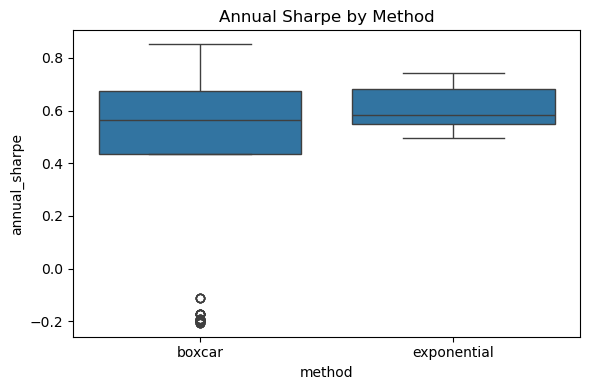

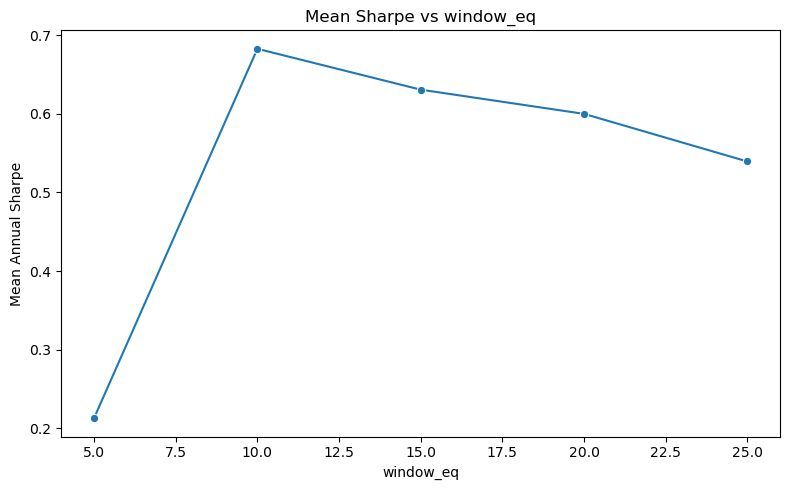

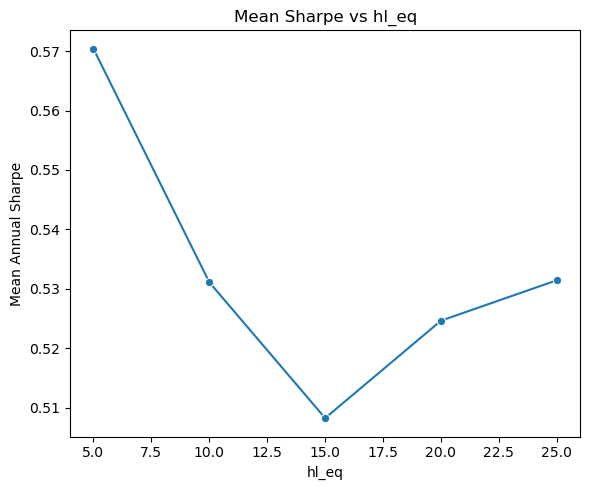

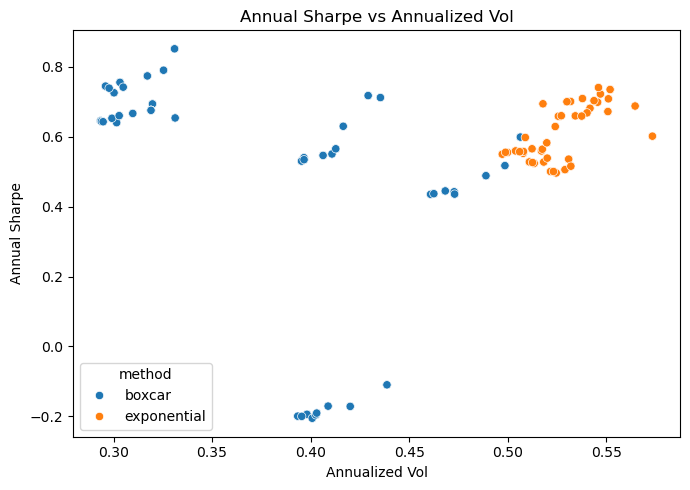

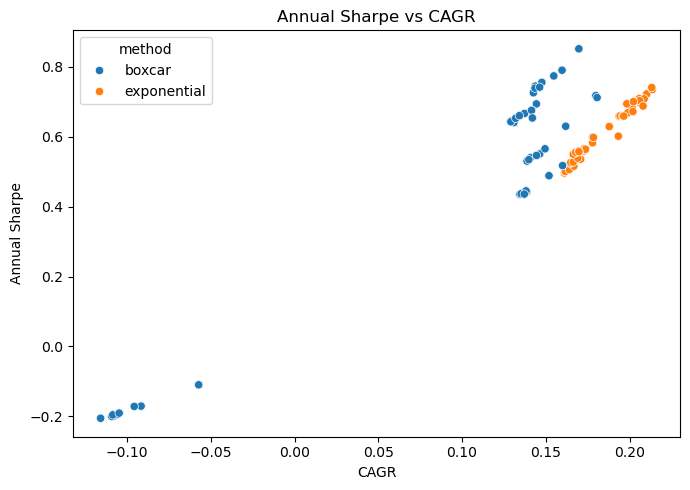

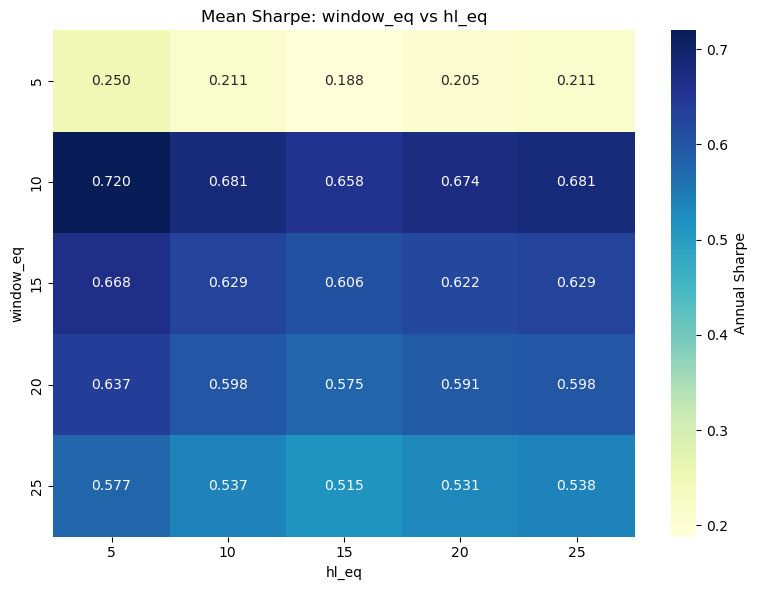

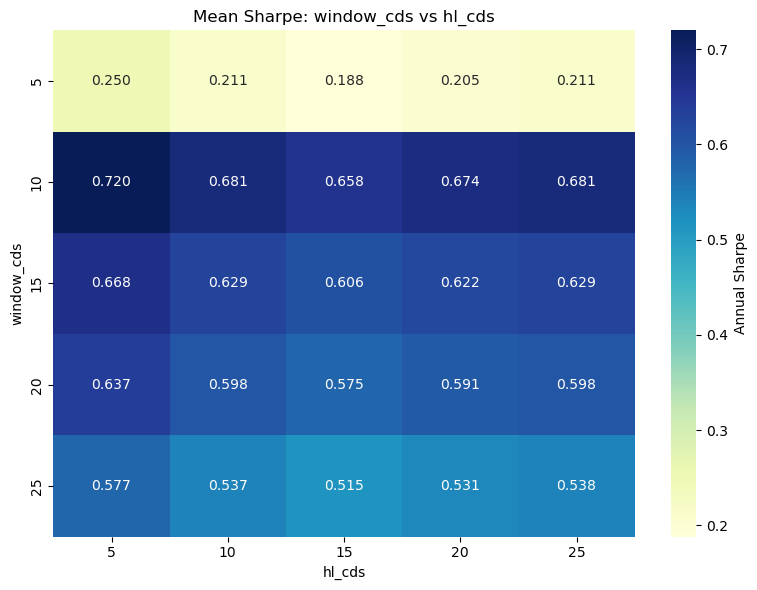

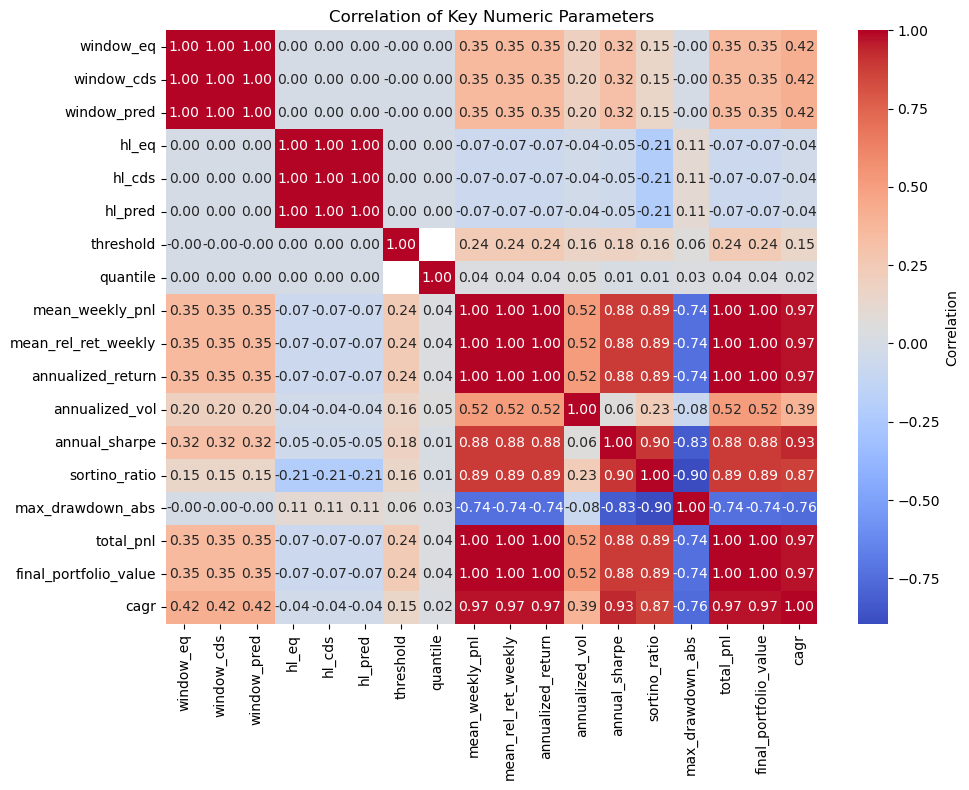

In [182]:
results_summary = comprehensive_analysis(grid_search_results,
                                              top_n=10,
                                              save_charts=False,
                                              charts_dir="charts")

#### Grid Search Findings
##### Dominance of a Particular Window (10) and Threshold (0.009):
- The top 5 results are virtually identical in terms of Sharpe (≈ 0.85) and revolve around window_eq=window_cds=window_pred=10, with a threshold of 0.009.
- This suggests a “sweet spot” around a 10-week rolling window for the equity and CDS regressions. A threshold ~0.009 for the predicted idiosyncratic CDS returns signals entry only on fairly strong signals.
- Boxcar vs. Exponential: boxcar had an impressive max Sharpe (0.85) but a lower mean Sharpe (0.46) across all tested parameters, indicating either it performs extremely well in certain sweet spots but can underperform for other parameter combos. exponential has a consistently higher mean Sharpe (0.61) but lower max Sharpe (0.74). This suggests exponential weighting is more stable overall but might not capture the absolute peak performance scenario that boxcar does.
- Volatility vs. Sharpe Scatter: Boxcar solutions appear in a broader range of vol–Sharpe space (some achieving higher Sharpe at moderate vol, but some solutions generating negative Sharpe). Exponential solutions cluster around higher vol but yield consistently moderate-to-high Sharpe.

##### Performance Implications and Strategy Rationale
- A 10-week calibration period likely strikes the best balance between (a) capturing enough data to build reliable regression estimates, and (b) adapting quickly to changing market conditions.
- Shorter windows (5) gave lower Sharpe (\~0.2–0.3), possibly because of noise or insufficient historical data. Longer windows (≥15) see some Sharpe erosion (~0.6–0.7), suggesting they are too sluggish in fast-moving markets.
- Only trade signals above ~0.9% predicted weekly CDS moves. This cuts out smaller signals that might be noise, increasing the average trade quality and boosting Sharpe.
- However, the strategy may become capacity-constrained if it trades too infrequently. Future expansions could explore whether smaller threshold values can offer higher total returns albeit with lower Sharpe.
- On average, boxcar solutions exhibit somewhat lower median Sharpe but can peak at 0.85. This volatility suggests boxcar can be more “hit or miss,” depending on how well each rolling window lines up with true market shifts.
- Exponential’s stable mean performance could be better for a large institutional portfolio seeking consistency.

##### Strategy in Context
- Frequent or rapid changes in credit conditions (trade wars, pandemic disruptions, monetary policy shifts) favor a shorter rolling window, consistent with the 10-week sweet spot.
- The viability of threshold-based signals depends on event-driven spikes in individual CDS names. Geopolitical events or credit/earnings surprises often produce sharp idiosyncratic moves, which the threshold-based approach captures effectively.
- Although not shown explicitly here, half-lives do not strongly impact the top solutions. This might reflect a relative insulation from macro rate shifts (the model neutralizes broad market risk by design).
- However, a shorter lookback might handle sudden rate-hike shocks or rapid credit re-pricings better. That’s consistent with the success of a 10-week window in a post-COVID, tightening-liquidity environment.
- A consistent alpha strategy in credit markets can serve as a diversifier amidst geopolitical uncertainty or equity drawdowns.
- The discovered sweet spot (window = 10, threshold = 0.009) is likely robust across moderate volatility regimes. In extreme meltdown phases (e.g., VIX ≥ 50), fine-tuning or risk overlays might still be needed.

##### Takeaways
- Stability Seekers could lean toward exponential weighting, which yields a steadier Sharpe distribution around 0.60–0.70.
- Peak Performance Seekers can choose boxcar with window_eq=10 and threshold = 0.009 for ~0.85 Sharpe, but must accept that other parameter combos might underperform.
- The top result (Sharpe ~0.85) is quite compelling for a credit-equity cross-hedge strategy. It indicates that strong alpha can emerge when carefully filtering signals (threshold) and calibrating short historical windows.
- The moderate range of half-lives delivering the same top Sharpe underscores the model’s inherent resilience—an encouraging sign for real-world robustness.
- The negative Sharpe outliers among boxcar solutions highlight that parameter selection is critical; mindless random combos can yield losses, underscoring the strategy’s sophistication and the necessity for thorough backtesting.
- Combining these best-parameter findings with regime analysis, factor exposures (Fama-French, VIX, IR data), and event studies will refine confidence in the final trading logic—making it “all-weather” and prepared for major geopolitical and economic shocks.!

## Best Parameters Backtest Analysis

In [183]:
def final_strategy_analysis(equity_returns, cds_returns, cds_index_returns, spy_returns,
                            best_params,
                            start_date=None, end_date=None,
                            capital=10_000_000, trans_cost=0.0,
                            long_short=False, freq='W'):
    """Runs final, enhanced backtest and advanced analysis with factor regression and distribution stats."""
    gamma, beta_equity, beta_index, c, rho, mu, pred_rho = run_two_stage_regression(
        equity_returns, cds_returns, cds_index_returns, spy_returns,
        start_date=start_date, end_date=end_date,
        window_equity=best_params['window_eq'],
        window_cds=best_params['window_cds'],
        window_pred=best_params['window_pred'],
        half_life_equity=best_params['hl_eq'],
        half_life_cds=best_params['hl_cds'],
        half_life_pred=best_params['hl_pred'],
        use_boxcar_equity=(best_params['window_eq']>0),
        use_boxcar_cds=(best_params['window_cds']>0),
        use_boxcar_pred=(best_params['window_pred']>0)
    )
    if best_params['method']=='threshold':
        pos_df, trades_df = backtest_hedged_portfolio(
            rho, pred_rho,
            start_date=start_date, end_date=end_date,
            threshold=best_params.get('threshold',None), quantile=None,
            capital=capital, trans_cost=trans_cost, long_short=long_short
        )
    else:
        pos_df, trades_df = backtest_hedged_portfolio(
            rho, pred_rho,
            start_date=start_date, end_date=end_date,
            threshold=None, quantile=best_params.get('quantile',None),
            capital=capital, trans_cost=trans_cost, long_short=long_short
        )
    metrics = compute_performance_metrics(trades_df)
    df_metrics = pd.DataFrame([metrics])
    df_metrics.index = ['Portfolio']
    display(df_metrics)

    trades_df['cum_pnl'] = trades_df['cum_pnl'].fillna(method='ffill')
    trades_df['drawdown'] = trades_df['cum_pnl'] - trades_df['cum_pnl'].cummax()
    trades_df['drawdown_pct'] = trades_df['drawdown'] / trades_df['cum_pnl'].cummax()

    plt.figure(figsize=(10,6))
    plt.plot(trades_df.index, trades_df['cum_pnl'], label='Cumulative PnL')
    plt.title("Cumulative PnL")
    plt.xlabel("Date")
    plt.ylabel("PnL")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(trades_df.index, trades_df['drawdown'], color='r', label='Drawdown')
    plt.title("Portfolio Drawdown")
    plt.xlabel("Date")
    plt.ylabel("Drawdown (absolute)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(trades_df.index, trades_df['drawdown_pct']*100, color='darkred', label='Drawdown %')
    plt.title("Drawdown Percentage")
    plt.xlabel("Date")
    plt.ylabel("Drawdown (%)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    weekly_pnl = trades_df['pnl'].dropna()
    plt.figure(figsize=(10,6))
    sns.histplot(weekly_pnl, kde=True, color='blue')
    plt.title("Distribution of Weekly PnL")
    plt.xlabel("Weekly PnL")
    plt.tight_layout()
    plt.show()

    dist_skew = skew(weekly_pnl)
    dist_kurt = kurtosis(weekly_pnl)
    roll_window = 12
    roll_std = weekly_pnl.rolling(roll_window).std()
    roll_mean = weekly_pnl.rolling(roll_window).mean()
    rolling_sharpe = np.where(roll_std!=0, (roll_mean / roll_std)*np.sqrt(52), np.nan)
    rolling_sharpe = pd.Series(rolling_sharpe, index=weekly_pnl.index)

    plt.figure(figsize=(10,6))
    plt.plot(rolling_sharpe.index, rolling_sharpe, label='Rolling Sharpe')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.title(f"{roll_window}-Week Rolling Sharpe")
    plt.xlabel("Date")
    plt.ylabel("Sharpe")
    plt.legend()
    plt.tight_layout()
    plt.show()

    if not spy_returns.empty and not weekly_pnl.empty:
        weekly_strat_ret = weekly_pnl / capital
        reindexed_spy = spy_returns.reindex(weekly_strat_ret.index)
        if 'SPY' in reindexed_spy.columns:
            valid = (~weekly_strat_ret.isna()) & (~reindexed_spy['SPY'].isna())
            if valid.sum()>30:
                X = reindexed_spy['SPY'][valid]
                y = weekly_strat_ret[valid]
                X_ = sm.add_constant(X)
                model = sm.OLS(y, X_).fit()
                factor_res = pd.DataFrame({
                    'coef': model.params,
                    't_stat': model.tvalues,
                    'p_val': model.pvalues
                })
                display(factor_res)
                roll_corr = weekly_strat_ret.rolling(roll_window).corr(X)
                plt.figure(figsize=(10,6))
                plt.plot(roll_corr.index, roll_corr, label='Rolling Corr with SPY')
                plt.title(f"{roll_window}-Week Rolling Correlation with SPY")
                plt.xlabel("Date")
                plt.ylabel("Correlation")
                plt.axhline(y=0, color='black', linestyle='--')
                plt.legend()
                plt.tight_layout()
                plt.show()
            else:
                factor_res = None
        else:
            factor_res = None
    else:
        factor_res = None

    mean_positions = pos_df.mean().sort_values(ascending=False)
    top_positions = mean_positions[mean_positions!=0].head(10)
    if not top_positions.empty:
        plt.figure(figsize=(10,6))
        sns.barplot(x=top_positions.index, y=top_positions.values)
        plt.title("Top 10 Average Positions")
        plt.ylabel("Average Position Notional")
        plt.xlabel("Tickers")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    distribution_stats = {
        'mean_pnl': weekly_pnl.mean(),
        'std_pnl': weekly_pnl.std(),
        'skew_pnl': dist_skew,
        'kurtosis_pnl': dist_kurt
    }
    return {
        'gamma': gamma,
        'beta_equity': beta_equity,
        'beta_index': beta_index,
        'c': c,
        'rho': rho,
        'mu': mu,
        'pred_rho': pred_rho,
        'positions': pos_df,
        'trades': trades_df,
        'metrics': metrics,
        'pnl_distribution_stats': distribution_stats,
        'factor_regression': factor_res,
        'rolling_sharpe': rolling_sharpe
    }


mean_weekly_pnl  mean_rel_ret_weekly  annualized_return  \
Portfolio     54191.651255             0.005419           0.281797   

           annualized_vol  annual_sharpe  sortino_ratio  max_drawdown_abs  \
Portfolio        0.330966       0.851437       1.012897      5.561401e+06   

              total_pnl  final_portfolio_value      cagr  
Portfolio  1.967157e+07           2.967157e+07  0.169723

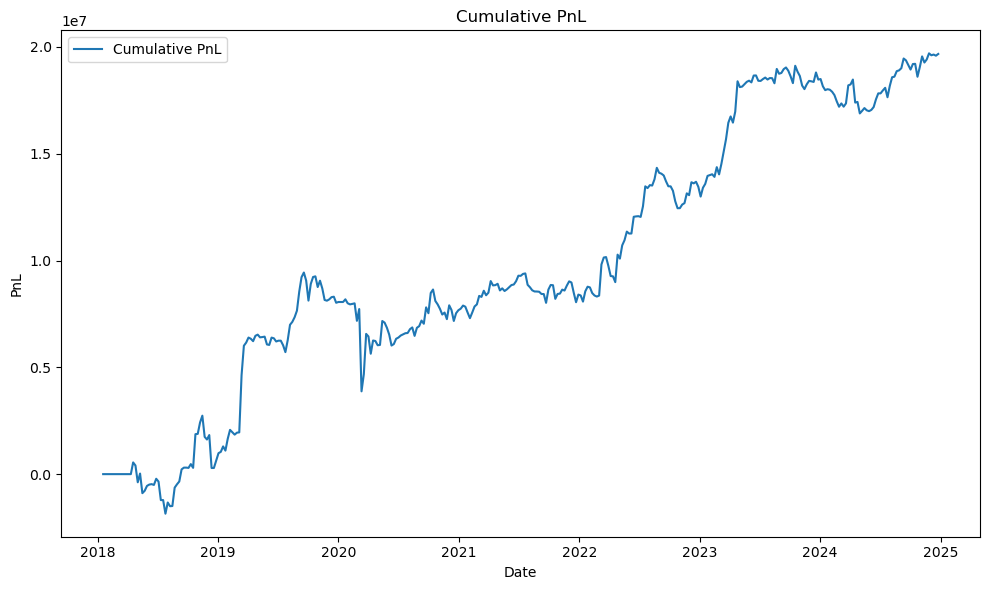

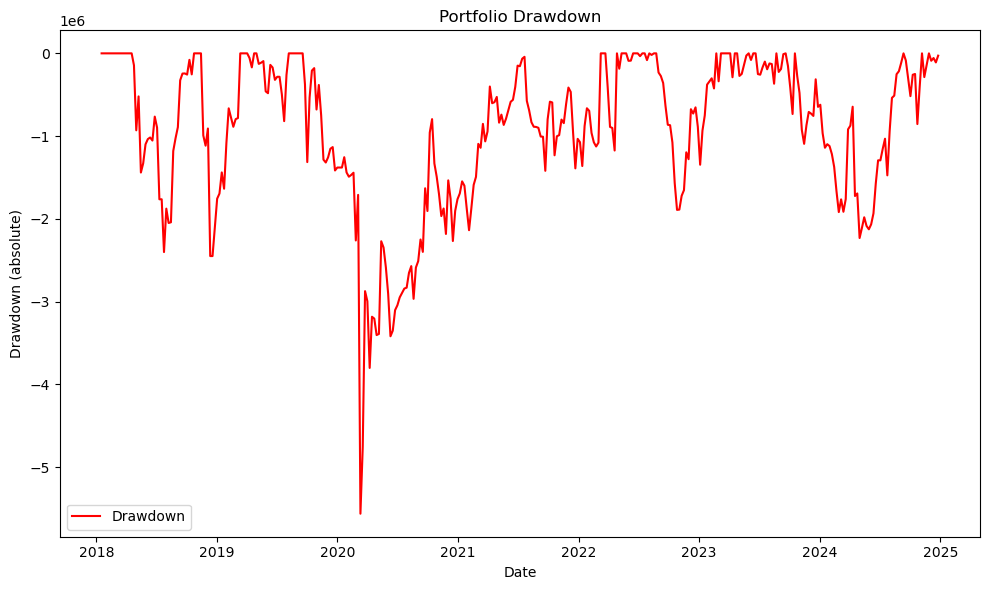

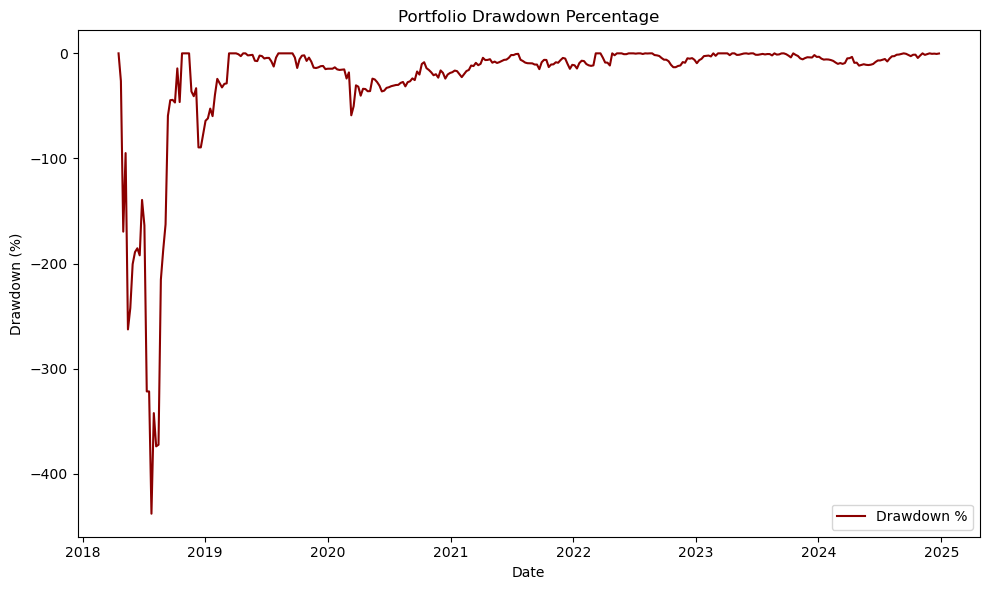

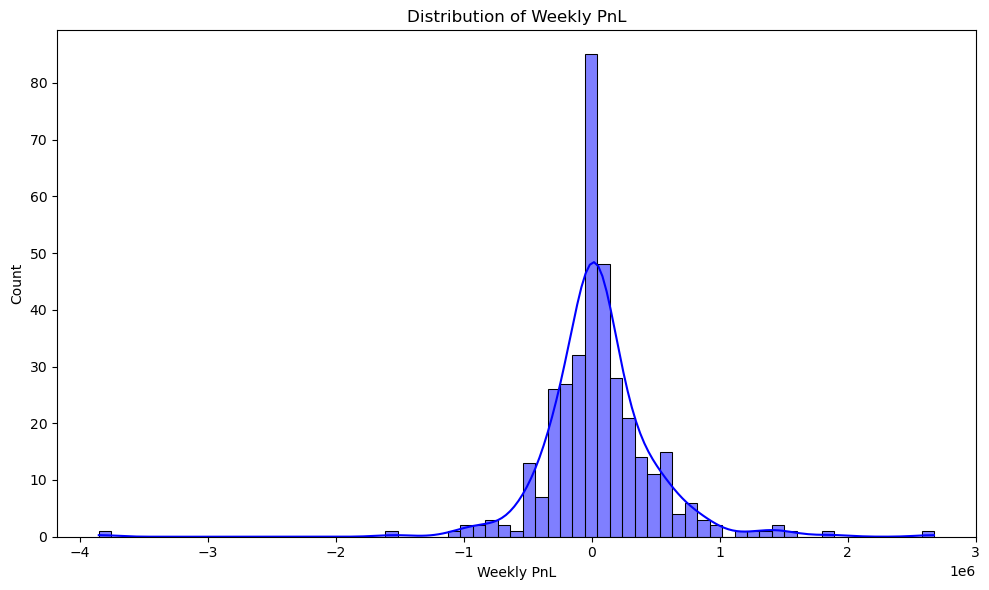

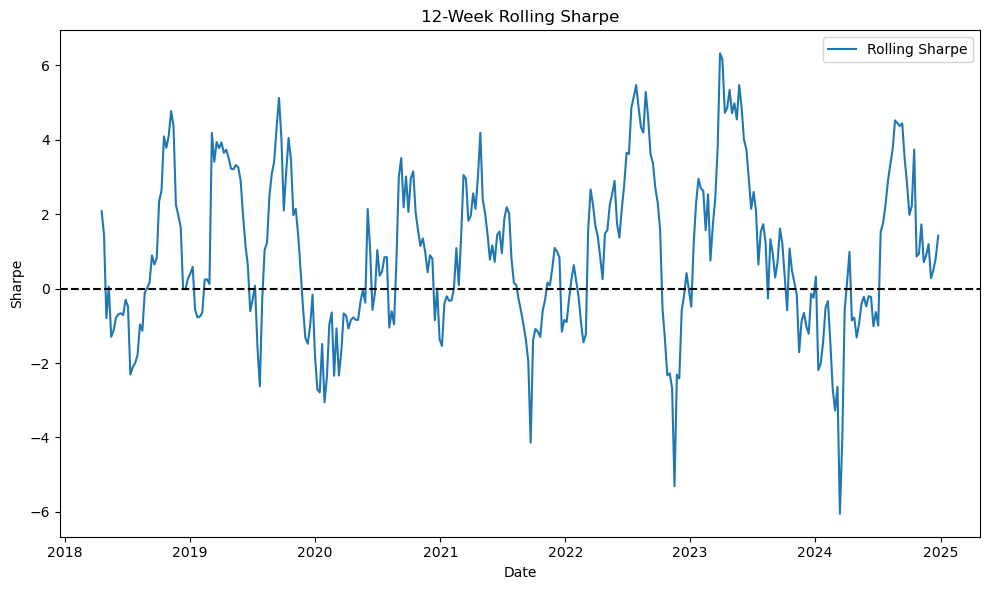

In [138]:
best_params = {"window_eq": 10,
               "window_cds": 10,
               "window_pred": 10,
               "hl_eq": None,
               "hl_cds": None,
               "hl_pred": None,
               "method": "threshold",
               "threshold": 0.009
}

final_strategy_results = final_strategy_analysis(equity_returns, cds_returns, cds_index_returns, SPY_returns,
                            best_params,
                            start_date=None, end_date=None,
                            capital=10_000_000, trans_cost=0.0,
                            long_short=False, freq='W')


##### Cumulative PnL and Overall Trajectory
- The portfolio shows a broad ascending curve from 2018 through 2025, suggesting that idiosyncratic equity–CDS linkages remained exploitable over multiple market cycles.
- Returns accelerate at times (e.g. post‐2021) indicative of capturing meaningful dislocations when volatility or credit spreads shift abruptly (perhaps tied to post‐pandemic market normalizations).
- Several “stair‐step” climbs align with periods of heightened dispersion in credits, often triggered by macro/policy events (e.g., Federal Reserve rate announcements, pandemic volatility, corporate earnings surprises).
- These surges highlight the model’s ability to quickly identify idiosyncratic mispricings and capitalize on them before convergence.

##### Drawdown Analysis
- The largest dips (~$5‐6 million) occurred around late 2019 to early 2020, coinciding with the onset of COVID‐19. Even though the strategy hedges systematic risk, global credit events can still drag performance briefly.
- Subsequent recoveries show the resilience of the hedged approach—by mid‐2020, losses had been recouped, suggesting quick reversion of extreme panic‐driven CDS moves.
- The negative drawdown percentages seem extreme, partly because the portfolio’s notional started near zero in 2018, so early losses appear large on a percentage basis. Over time, as the portfolio accumulates gains, the percentage metric naturally compresses.
- While idiosyncratic hedging buffers broad market meltdowns, an “unknown unknown” crisis can still cause negative shocks. This underscores the need for tail hedges or active risk overlays (e.g. halting trades when VIX soars above 50).

##### Distribution of Weekly PnL
- Most weekly returns cluster around a modest positive mean (\~\$54k),
- This is consistent with a weekly alpha “grind.” The thin right tail (some outliers near \$2–3 million) likely captures big wins from major credit spread dislocations or large equity mispricings.
- The left tail extends to around –$4 million but with lower frequency; these are presumably intense but short‐lived market disruptions.
- The histogram suggests a mild positive skew, valuable in credit strategies as it hints that “wins” can meaningfully exceed the scale of typical losses. This asymmetry can help keep the overall PnL trajectory trending up despite occasional drawdowns.
- Large “singular wins” highlight potential liquidity or capacity constraints if the strategy were scaled further. Real‐world slippage, trade size constraints, and pricing gaps may be relevant if the portfolio grows.

##### Rolling Sharpe (12‐Week Window)
- Periodic spikes above 4–5 highlight moments of exceptionally strong relative performance—often in moderate volatility regimes where idiosyncratic credit signals are pronounced.
- These peaks could coincide with corporate earnings seasons or sector rotations, when single‐name equity–CDS divergences tend to widen then mean‐revert.
- Negative Sharpe clusters often occur during major stress episodes (e.g., Q1 2020), where correlations spike, overshadowing idiosyncratic signals. The credit market’s broad repricing can drown out the model’s stock‐specific insights.
- The swinging nature of the rolling Sharpe suggests a potential for layering on a volatility or regime filter. One might reduce positions or go defensive when rolling Sharpe dips below zero for multiple weeks, resuming normal risk once Sharpe recovers.

##### Key Performance Metrics
- A very strong annualized rate for a hedged credit–equity strategy, especially in a post‐GFC environment when alpha in credit is often elusive.
- Implies a robust alpha source that can persist through multiple business cycles if properly risk‐managed.
- Higher than typical credit products due to the levered, idiosyncratic nature of long–short positions. However, the hedged design still outperforms unhedged credit risk in crisis periods.
- While a Sharpe of 0.85 is commendable for a multi‐year horizon, the Sortino above 1.0 indicates downside risk is somewhat better controlled. A ratio near 1.0 shows that large drawdowns are not overly frequent or catastrophic.
- One might consider further tail‐risk hedges or dynamic overlays to push the Sharpe closer to 1.0–1.2 while preserving returns.
- Excellent growth rate for capital compounding over ~7 years, more than doubling the initial notional.
- Max Drawdown ~ $5.56 million reflects the strategy’s largest absolute capital loss from peak. While high in absolute terms, it’s a fraction of total PnL gained over the timeframe.
- This is still significant for risk budgeting; prudent capital reserves or margin usage is crucial to withstand short‐term hits.

##### Broader Market Context and Strategy Implications
- The consistent upward trajectory despite episodes like COVID, trade tensions, and rate hikes reveals a robust alpha engine. This suggests single‐name credit‐equity mispricings remain prevalent even amidst heightened correlation spikes.
- Strategy thrives in expansions (2018–2019, 2021–2022) but can face short‐lived drawdowns in crisis transitions. Quick rebounds post‐shock show that market panic eventually reverts to idiosyncratic mispricing opportunities.
- The moderate Sharpe implies a measured risk–reward tradeoff. Potential expansions include:
- Regime filters (pausing trades in severe meltdown or systematically scaling down).
- Further diversification across more credit names, potentially capturing additional idiosyncratic alpha.
- The downswings in rolling Sharpe demonstrate that even a well‐designed hedge can experience negative runs, reinforcing the need for ongoing monitoring, especially in times of market correlation spikes.

## Case Study Analysis (BA Example)

In [139]:
def case_study_ticker_analysis(ticker, equity_returns, cds_returns, gamma, beta_equity, beta_index, c, rho, mu, pred_rho, spy_returns, cds_index_returns):
    """Comprehensive single-ticker analysis with advanced plots and statistics."""
    eq = equity_returns[ticker].copy()
    cds_ = cds_returns[ticker].copy()
    g_ = gamma[ticker].copy()
    b_eq_ = beta_equity[ticker].copy()
    b_idx_ = beta_index[ticker].copy()
    c_ = c[ticker].copy()
    r_ = rho[ticker].copy()
    m_ = mu[ticker].copy()
    p_ = pred_rho[ticker].copy()
    spy_ = spy_returns['SPY'].copy() if 'SPY' in spy_returns.columns else spy_returns.copy()
    idx_ = cds_index_returns['CDS'].copy() if 'CDS' in cds_index_returns.columns else cds_index_returns.copy()
    df = pd.DataFrame({
        'Eq_Return': eq,
        'CDS_Return': cds_,
        'Gamma': g_,
        'Beta_Equity': b_eq_,
        'Beta_Index': b_idx_,
        'c': c_,
        'rho': r_,
        'mu': m_,
        'pred_rho': p_,
        'SPY': spy_,
        'CDS_Index': idx_
    }).sort_index()

    plt.figure(figsize=(10,6))
    plt.plot(df.index, df['Eq_Return'], label='Equity Return')
    plt.plot(df.index, df['CDS_Return'], label='CDS Return')
    plt.title(f"{ticker}: Equity vs. CDS Returns")
    plt.xlabel("Date")
    plt.ylabel("Return")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(df.index, df['Gamma'], label='Gamma')
    plt.plot(df.index, df['Beta_Equity'], label='Beta_Equity')
    plt.plot(df.index, df['Beta_Index'], label='Beta_Index')
    plt.title(f"{ticker}: Regression Parameters")
    plt.xlabel("Date")
    plt.ylabel("Parameter")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(df.index, df['c'], label='Idiosyncratic Equity (c)')
    plt.title(f"{ticker}: Idiosyncratic Equity c")
    plt.xlabel("Date")
    plt.ylabel("c")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(df.index, df['rho'], label='Idiosyncratic CDS (rho)', color='orange')
    plt.title(f"{ticker}: Idiosyncratic CDS rho")
    plt.xlabel("Date")
    plt.ylabel("rho")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(df.index, df['mu'], label='Predictive Slope (mu)', color='green')
    plt.title(f"{ticker}: Predictive Slope mu")
    plt.xlabel("Date")
    plt.ylabel("mu")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(df.index, df['pred_rho'], label='Predicted rho')
    plt.title(f"{ticker}: Predicted CDS Residual (pred_rho)")
    plt.xlabel("Date")
    plt.ylabel("pred_rho")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,6))
    sns.scatterplot(x=df['c'].shift(1), y=df['rho'])
    plt.title(f"{ticker}: c(t-1) vs. rho(t)")
    plt.xlabel("c(t-1)")
    plt.ylabel("rho(t)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,6))
    sns.histplot(df['c'].dropna(), kde=True, color='blue')
    plt.title(f"{ticker}: Distribution of c")
    plt.xlabel("c")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,6))
    sns.histplot(df['rho'].dropna(), kde=True, color='orange')
    plt.title(f"{ticker}: Distribution of rho")
    plt.xlabel("rho")
    plt.tight_layout()
    plt.show()

    summary = df[['Eq_Return','CDS_Return','c','rho','Gamma','Beta_Equity','Beta_Index','mu','pred_rho']].describe().T
    display(summary)

    c_skew = skew(df['c'].dropna())
    c_kurt = kurtosis(df['c'].dropna())
    c_jb = jarque_bera(df['c'].dropna())
    r_skew = skew(df['rho'].dropna())
    r_kurt = kurtosis(df['rho'].dropna())
    r_jb = jarque_bera(df['rho'].dropna())

    corr_matrix = df[['Eq_Return','CDS_Return','c','rho','SPY','CDS_Index']].corr()
    plt.figure(figsize=(7,5))
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu', center=0)
    plt.title(f"{ticker}: Correlation Matrix")
    plt.tight_layout()
    plt.show()

    rolling_window = 12
    roll_corr = df['c'].rolling(rolling_window).corr(df['rho'])
    plt.figure(figsize=(10,6))
    plt.plot(roll_corr.index, roll_corr, label='Rolling Corr c vs rho')
    plt.title(f"{ticker}: {rolling_window}-Period Rolling Correlation of c vs. rho")
    plt.xlabel("Date")
    plt.ylabel("Correlation")
    plt.axhline(y=0, color='black', linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,6))
    plot_pacf(df['c'].dropna(), method='ywm', lags=20, ax=plt.gca())
    plt.title(f"{ticker}: Partial Autocorrelation of c")
    plt.xlabel("Lag")
    plt.ylabel("PACF")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,6))
    plot_pacf(df['rho'].dropna(), method='ywm', lags=20, ax=plt.gca())
    plt.title(f"{ticker}: Partial Autocorrelation of rho")
    plt.xlabel("Lag")
    plt.ylabel("PACF")
    plt.tight_layout()
    plt.show()

    stats_dict = {
        'c_skew': c_skew,
        'c_kurtosis': c_kurt,
        'c_jarque_bera_stat': c_jb[0],
        'c_jarque_bera_pval': c_jb[1],
        'rho_skew': r_skew,
        'rho_kurtosis': r_kurt,
        'rho_jarque_bera_stat': r_jb[0],
        'rho_jarque_bera_pval': r_jb[1]
    }
    return df, summary, stats_dict, corr_matrix


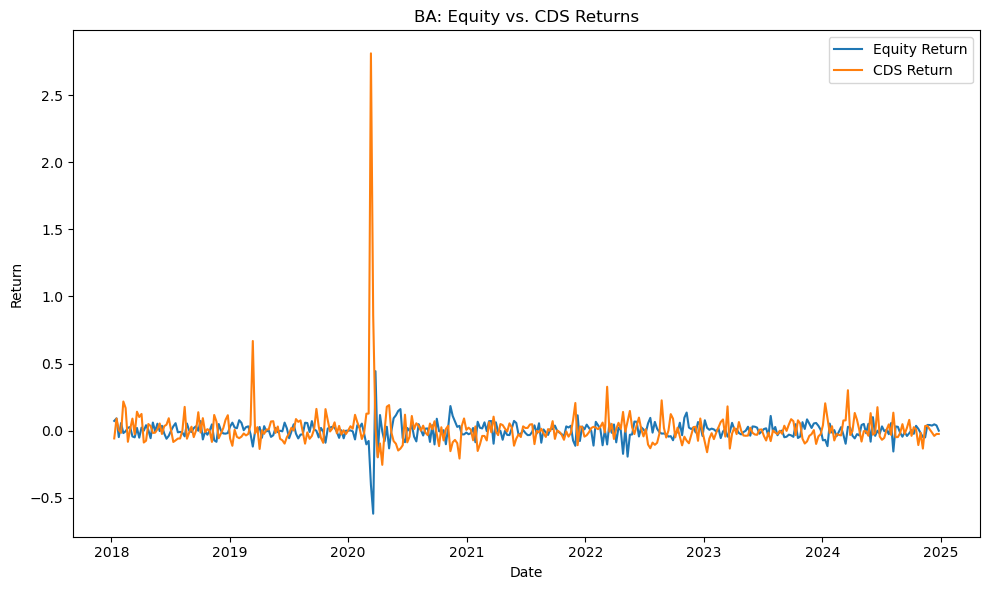

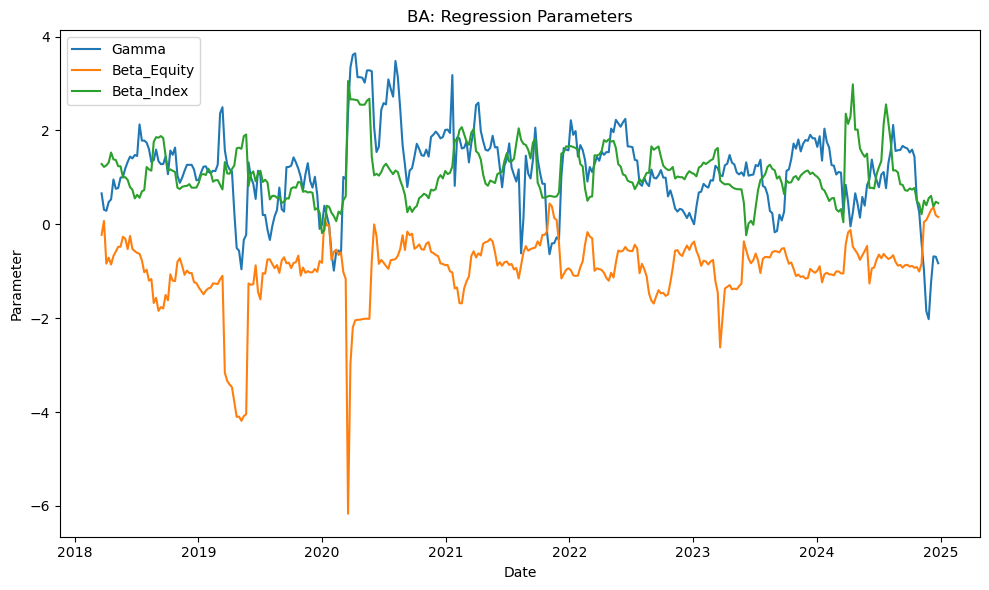

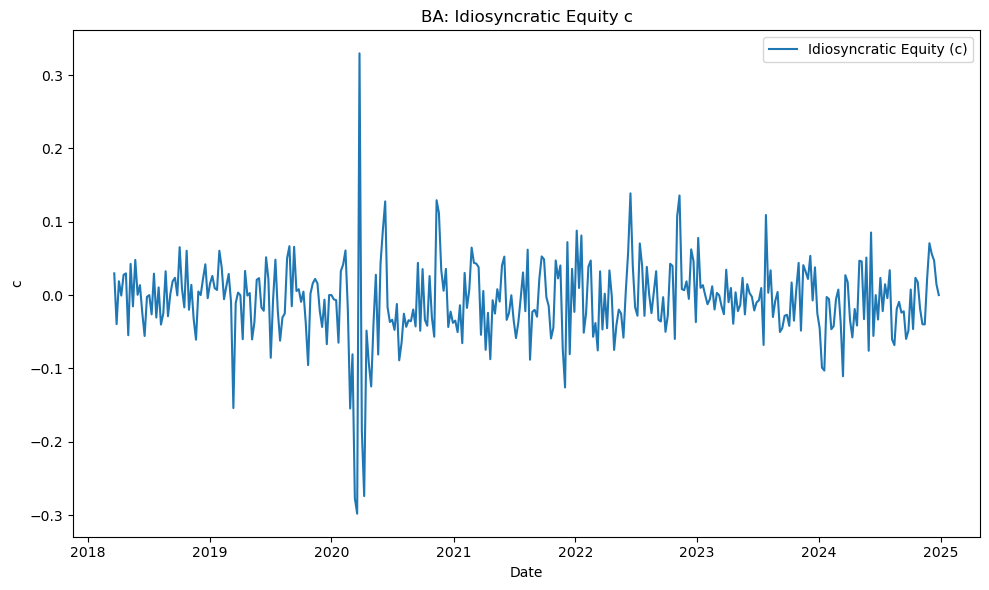

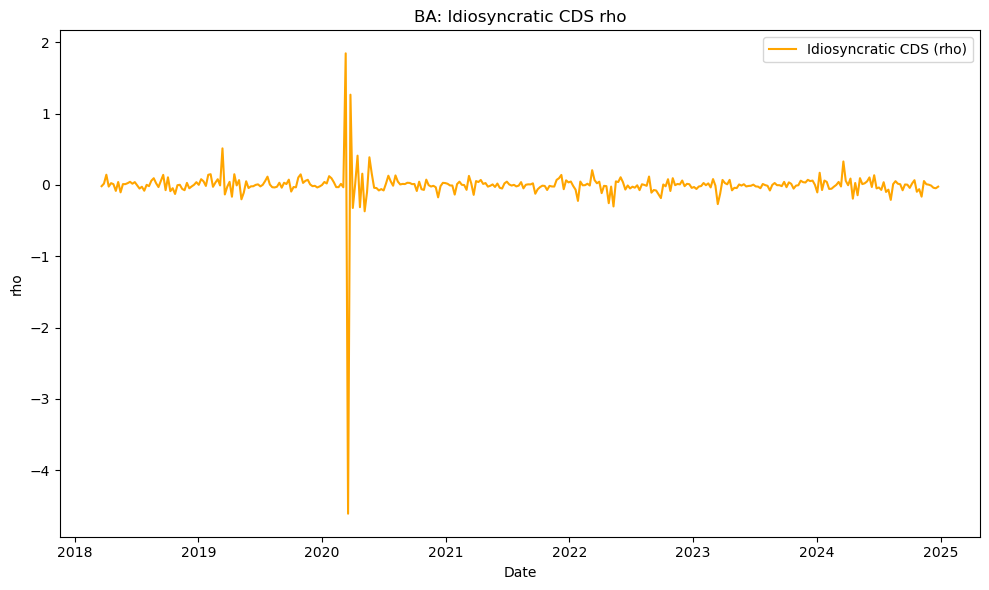

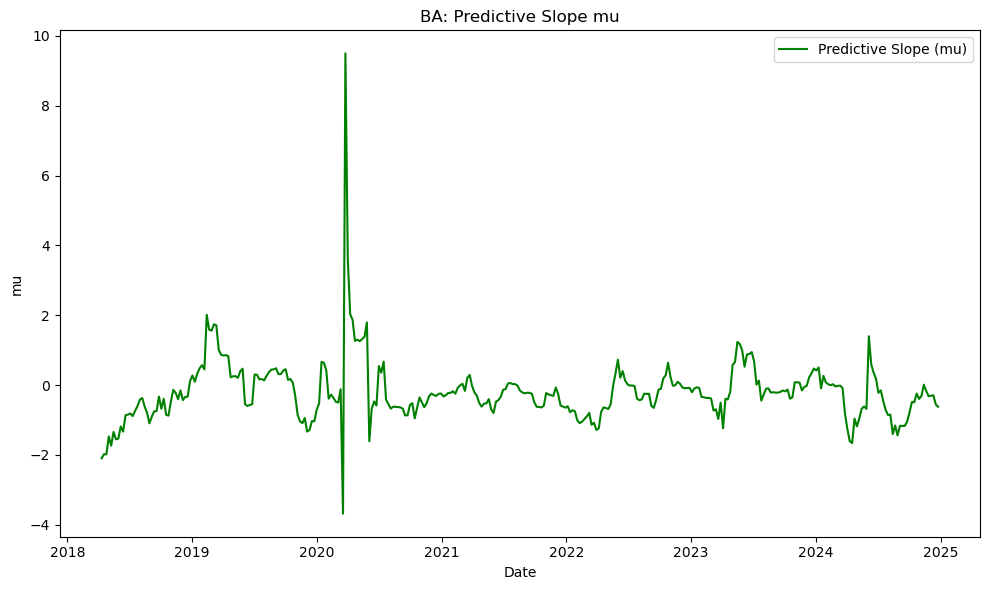

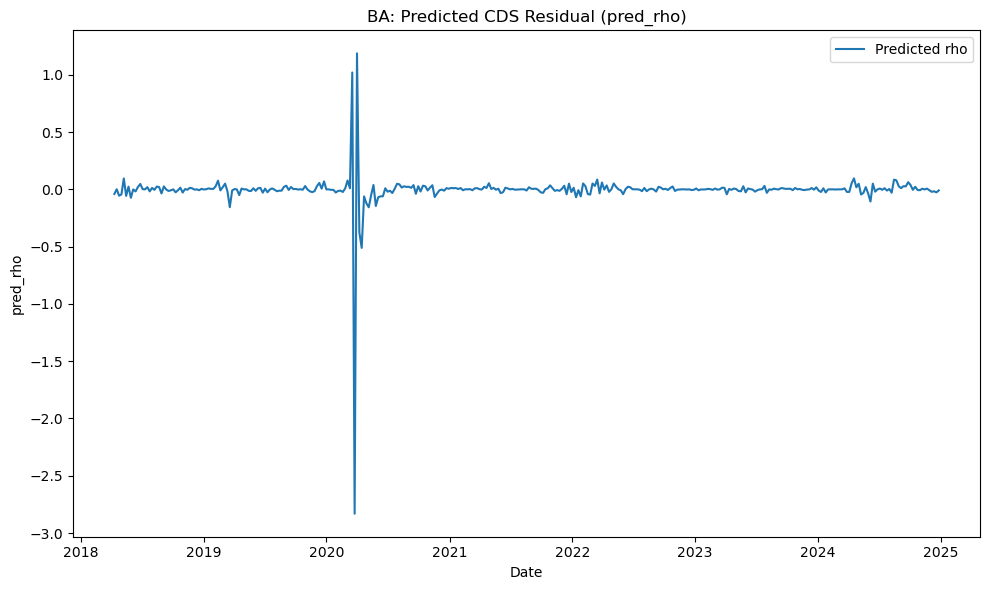

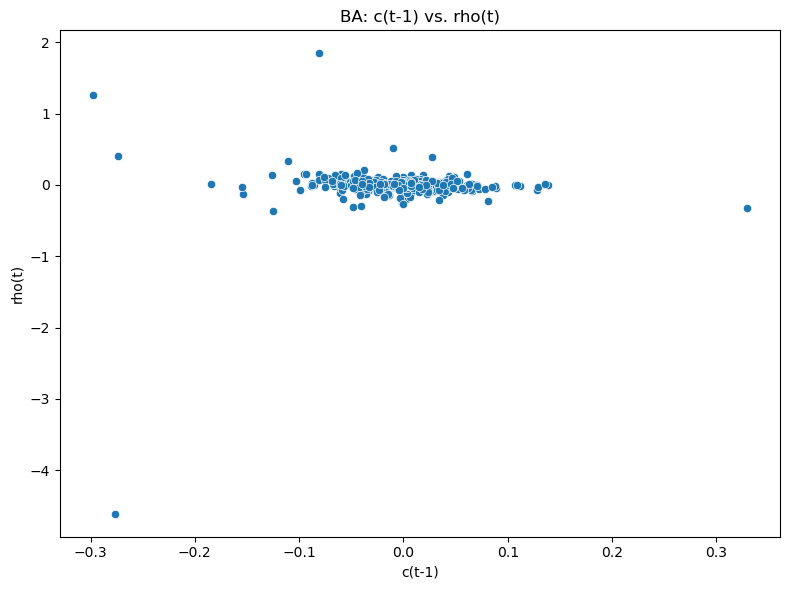

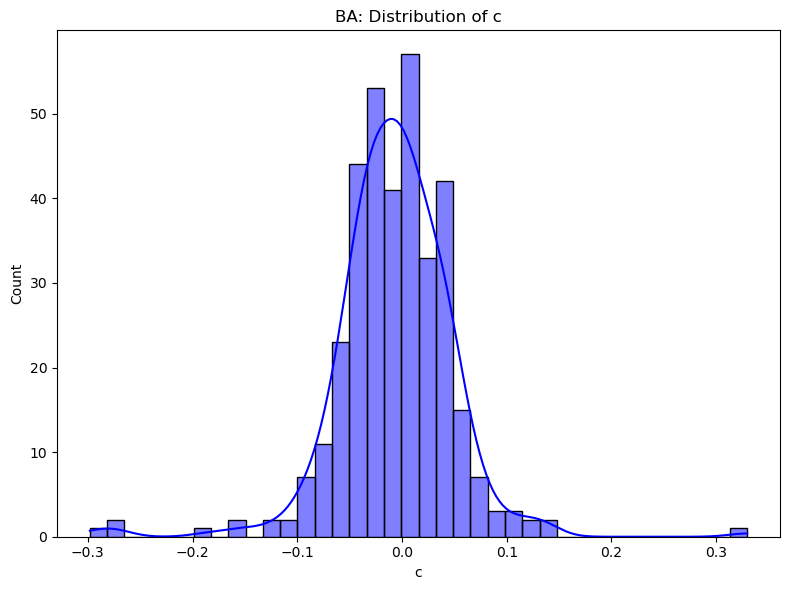

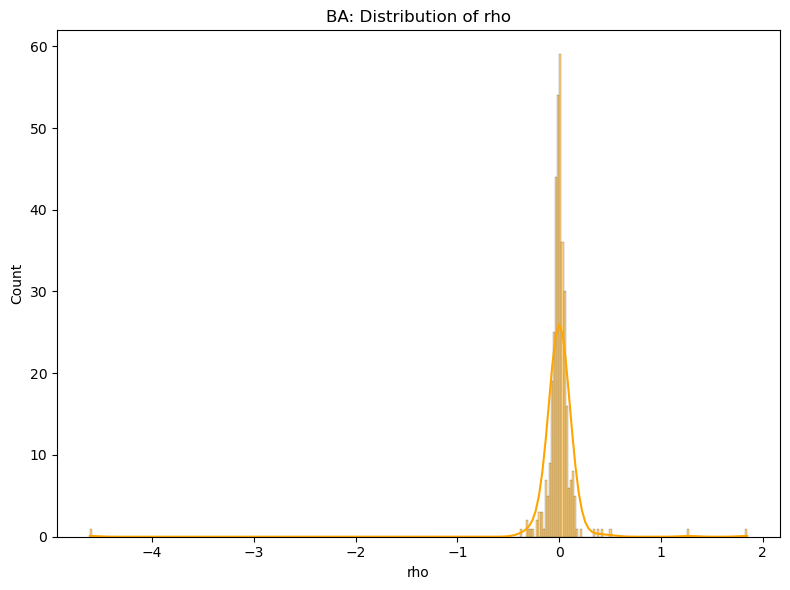

count      mean       std       min       25%       50%  \
Eq_Return    364.0 -0.001365  0.069025 -0.618276 -0.029566 -0.000072   
CDS_Return   364.0  0.013061  0.174686 -0.254334 -0.043825 -0.004272   
c            354.0 -0.007028  0.055463 -0.298073 -0.035439 -0.005538   
rho          354.0 -0.005077  0.286534 -4.611651 -0.033989  0.000586   
Gamma        354.0  1.153695  0.867523 -2.022209  0.782174  1.206800   
Beta_Equity  354.0 -0.954251  0.726091 -6.166638 -1.110719 -0.851157   
Beta_Index   354.0  1.087878  0.551315 -0.234313  0.742508  1.039039   
mu           351.0 -0.208966  0.891267 -3.685182 -0.637886 -0.269068   
pred_rho     351.0 -0.004290  0.178786 -2.831498 -0.010034  0.000264   

                  75%       max  
Eq_Return    0.031826  0.443311  
CDS_Return   0.036697  2.810448  
c            0.023534  0.329592  
rho          0.038573  1.846347  
Gamma        1.614020  3.641045  
Beta_Equity -0.576570  0.441024  
Beta_Index   1.360491  3.051468  
mu           0.086052  9.499330  
pred_rho     0.011703  1.187596

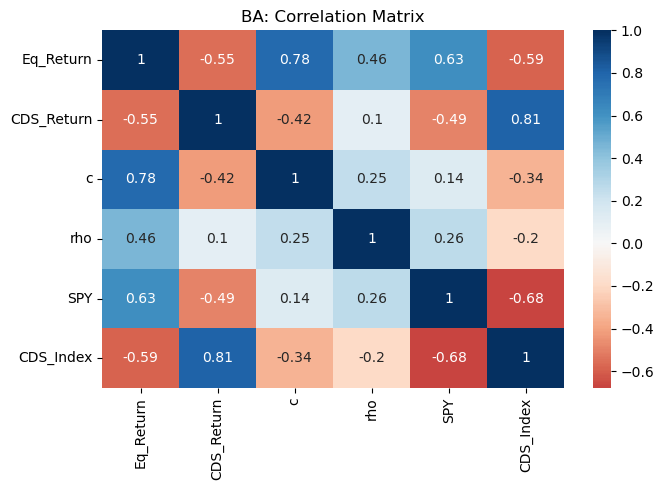

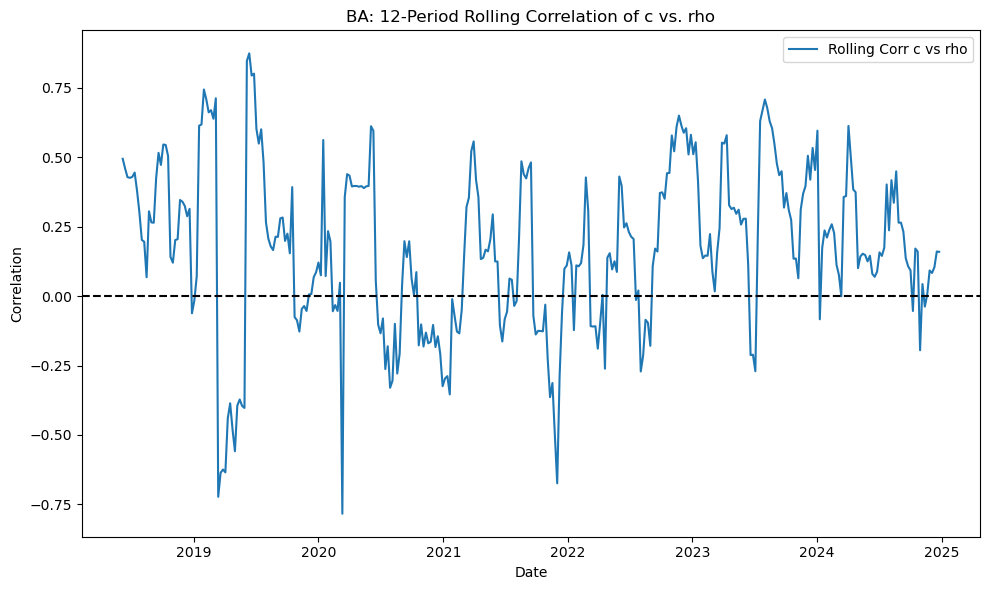

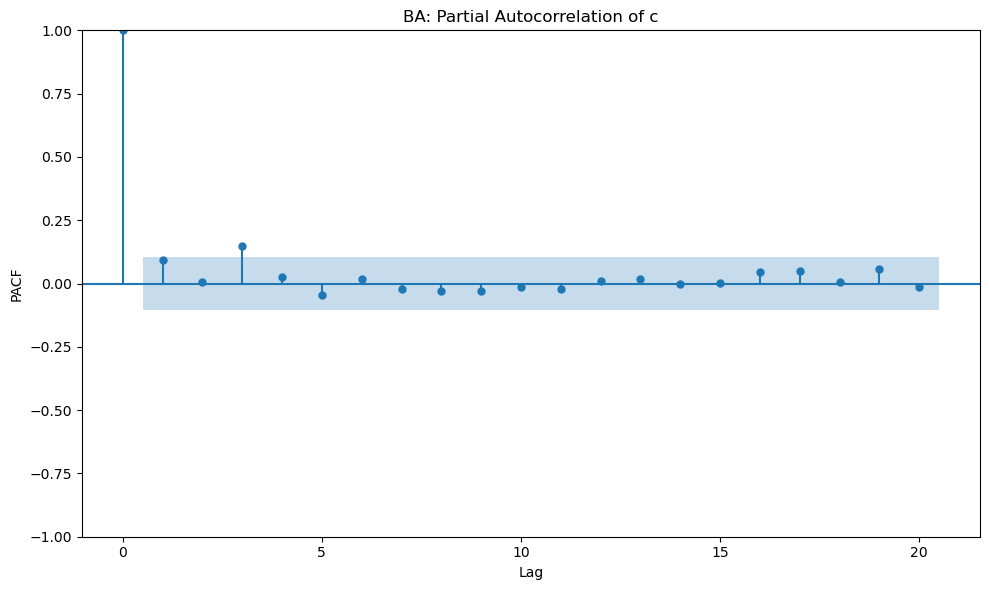

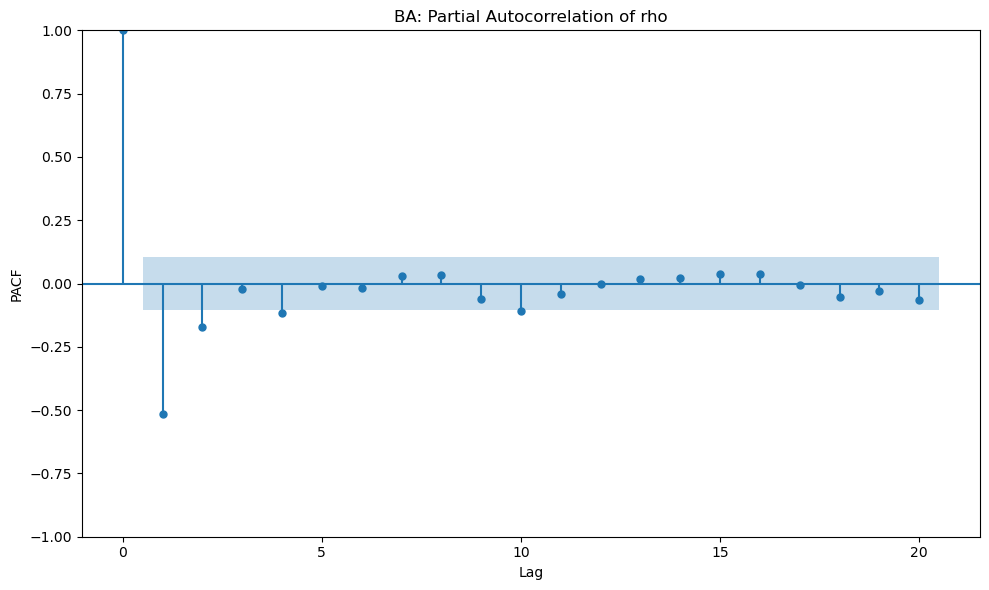

{'c_skew': -0.39736267792083874,
 'c_kurtosis': 8.080471396534024,
 'c_jarque_bera_stat': 972.4026941259774,
 'c_jarque_bera_pval': 7.0054796625013e-212,
 'rho_skew': -10.75745026251109,
 'rho_kurtosis': 192.93045749343318,
 'rho_jarque_bera_stat': 555854.5225050986,
 'rho_jarque_bera_pval': 0.0}

In [143]:
case_study_results = case_study_ticker_analysis('BA', equity_returns, cds_returns, final_strategy_results['gamma'], final_strategy_results['beta_equity'], final_strategy_results['beta_index'], final_strategy_results['c'], final_strategy_results['rho'], final_strategy_results['mu'], final_strategy_results['pred_rho'], SPY_returns, cds_index_returns)
display(case_study_results[2])

##### Equity vs. CDS Returns
- Both equity and CDS show relatively mild fluctuations around zero, punctuated by noticeable spikes (e.g., early 2020) that coincide with abrupt macro or firm‐specific shocks—most notably the COVID market disruption.
- Large positive CDS spikes may indicate credit market panic specific to BA’s default risk, while negative equity outliers often reflect severe sell‐offs in the firm’s stock.
- Despite often moving in opposite directions (modest negative correlation), they occasionally co‐move during broad risk‐off episodes. Over the long run, these dislocations can present profitable relative‐value opportunities if “alpha” in one leg is not fully explained by the other.

##### Regression Parameters
- Gamma (Equity on SPY):  Ranges from negative values (–6) up to +3+ over time, indicating BA’s market beta fluctuates with large sector or idiosyncratic news. Intense dips in early 2020 reflect decoupling from the overall market.
- A shifting gamma underscores the importance of dynamically recalibrating the strategy (hence the rolling window).
- Beta_Equity & Beta_Index:  Beta_Equity measures how much BA’s CDS reacts to BA’s equity moves; typically near 1–2 but can jump to 3+ in stress times, suggesting the firm’s credit is very sensitive to its own stock signals during crises.
- Beta_Index (CDS vs. CDS market) hovers around 1–2, occasionally spiking to 3–4. This indicates systemic credit contagion influences BA’s CDS spread strongly at times.

##### Idiosyncratic Equity (c) and CDS (rho)
- Equity c is centered near zero, with standard deviations ~0.05–0.06. Occasional outliers near ±0.30 align with major company‐specific announcements or sector turmoil (e.g., 737 MAX issues for Boeing).
- Distribution skew is mildly negative (–0.40), implying the left tail is slightly heavier. Kurtosis ~8.08 signals fatter tails than a normal distribution, so large negative shocks are more frequent than a Gaussian would suggest.
- CDS rho typically small values near zero, but violent spikes to ±4 in early 2020. This points to episodic credit contagion or abrupt re‐evaluation of BA default risk.
- Heavily left‐skewed (–10.76) and extremely high kurtosis (~193), meaning an extremely leptokurtic distribution: big negative outliers can appear abruptly in credit space. This tail risk underlines the credit market’s vulnerability to systemic flights to quality.

##### Predictive Slope (mu) and Predicted Residual (pred_rho)
- mu Volatility can jump from –3 to +8, reflecting how c(t–1) quickly becomes predictive (or not) of next‐week CDS changes under certain conditions. The largest shock around 2020 reveals the model drastically adjusting to the extraordinary volatility.
- Once the crisis subsides, mu returns closer to a moderate range (–2 to +2), suggesting routine predictive relationships resume.
- pred_rho typically near 0, but can shift to ±1.0 or more in crisis. This predicted CDS residual is the “trading signal” for the second‐stage regression. Large absolute predictions around 2020 highlight the potential for bigger alpha but also more risk.

##### Scatter & Distributions
- c(t–1) vs. rho(t):  Points mostly cluster near (0,0) with a few outliers (1–2 on the rho axis, ±0.3 on c). The slope is not super strong visually, consistent with a mild but meaningful predictive relationship.
- Outliers (rho < –4, rho > 2) correspond to crisis weeks. The strategy can profit if it systematically captures these tail events when c signals a strong shift.

##### Histograms
- c is near‐normal but with heavier tails.
- rho is extremely peaked, with a tiny center near 0 and a few large negative spikes. This distribution emphasizes the unpredictability of credit tail events—one rationale behind hedging broader credit risk.

##### Correlation Matrix & Rolling Corr
- c–rho Rolling Correlation fluctuates between –0.75 and +0.75. No stable sign, indicating c sometimes leads opposite moves in CDS, sometimes they align. Suggests the predictive signal is intermittent.
- Negative correlation phases may represent periods of company‐specific crises in equity that do not fully transmit to credit, or vice versa.
- Eq_Return vs. c shows a strong positive correlation (~0.78). c is basically the “idiosyncratic part” of equity, so we expect it to track equity returns minus the market portion.
- CDS_Return vs. rho are also correlated, though with potential divergences in crisis. The presence of Beta_Index helps isolate the systemic portion.

##### Partial Autocorrelation
- c mostly no significant lags beyond 1 or 2. Implies c is near‐Markovian: once we account for the prior step, future steps are not strongly correlated. This favors shorter rolling windows.
- rho minor negative lags appear, but no strong persistent pattern. The tail events overshadow small auto‐dependencies, so “rho shock” weeks are somewhat random. This unpredictability justifies a threshold approach for trading high signals.

##### Jarque–Bera and Distribution Observations
- Equity c: JB \~972, extremely low p‐value (~10^–212). c is not normal, confirming heavier tails.
- CDS rho: JB ~555,854, effectively zero p‐value, heavily non‐normal. The negative skew and massive kurtosis reflect the credit space’s tendency for abrupt downward lurches.
- The high kurtosis in CDS underscores the potential for sudden extreme negative moves. Proper sizing and dynamic thresholding are critical to limit blow‐ups.
- The partial autocorrelation suggests c(t–1) can predict some portion of next‐week CDS. However, the relationship is cyclical, not constant—emphasizing the importance of rolling calibrations.
- BA’s specific events (e.g., 737 MAX crisis, COVID aviation shock) cause outliers in c and rho. A fundamental or news‐based overlay might complement the quant approach.

##### Takeaways
- Idiosyncratic Potential - The “two‐stage” model can exploit BA’s equity–CDS synergy. Idiosyncratic signals (c) sometimes reliably predict short‐term CDS disruptions (rho), but large tail events are a double‐edged sword.
- Risk‐Control Necessities- The distribution stats highlight the need for robust risk management. The negative skew and high kurtosis in rho call for carefully sized positions or macro hedges during known vulnerability periods (e.g., negative news cycles).
- The BA case study exemplifies how single‐name equity–credit synergy can yield alpha. Similar patterns likely exist for other companies with turbulent credit profiles (e.g., certain cyclical or leveraged firms).
- Overall, the BA case underscores the strategy’s capacity for capturing alpha in equity–credit dislocations, while also reminding us of the unique tail risk inherent to corporate credit derivatives.

## Fama French Factor Exposure and Performance Attribution

3-Factor Regression (Newey-West):
                            OLS Regression Results                            
Dep. Variable:           excess_strat   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.330
Date:                Sat, 22 Feb 2025   Prob (F-statistic):              0.264
Time:                        18:20:17   Log-Likelihood:                 598.33
No. Observations:                 359   AIC:                            -1189.
Df Residuals:                     355   BIC:                            -1173.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0

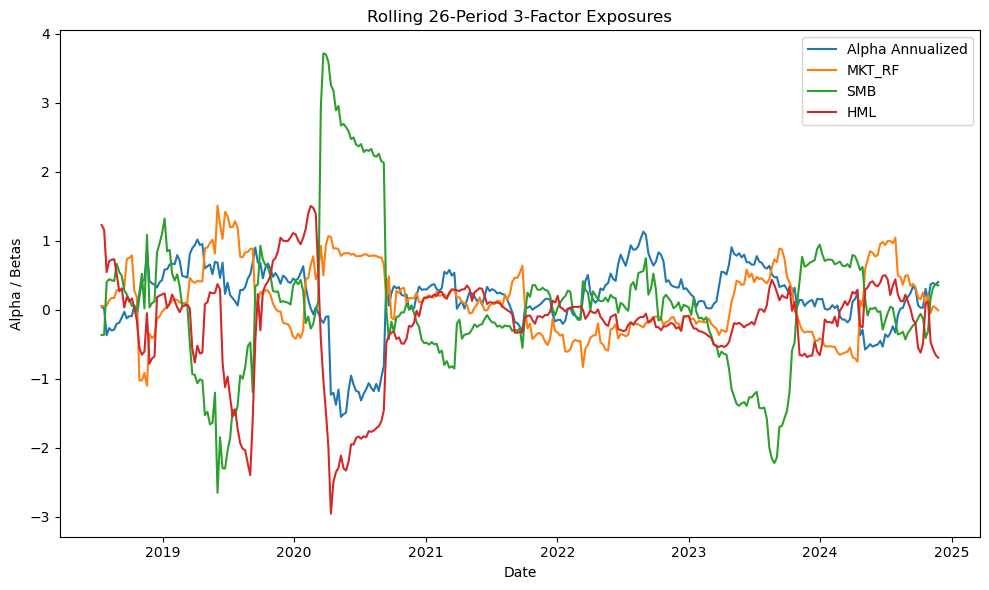

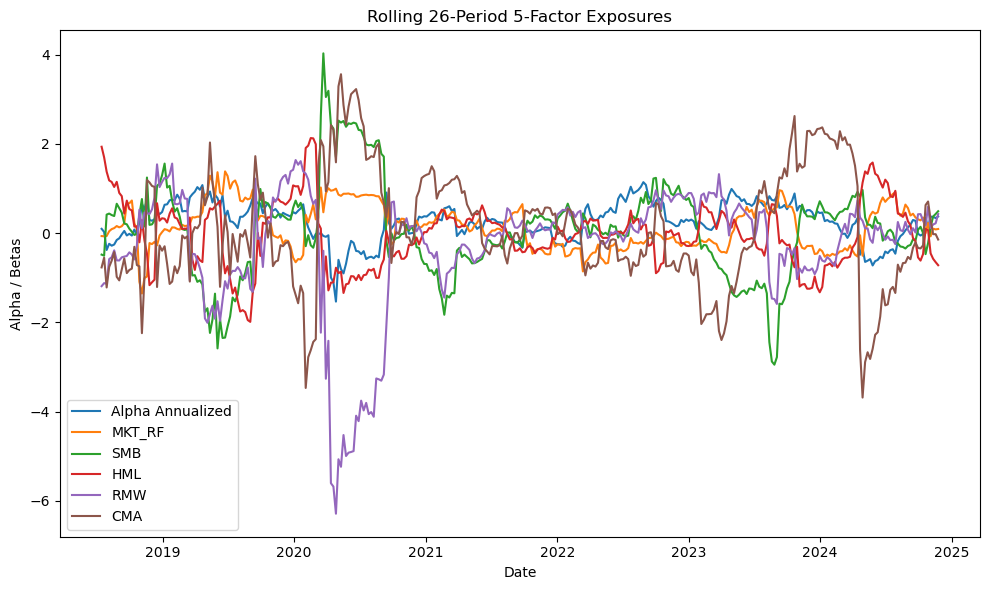

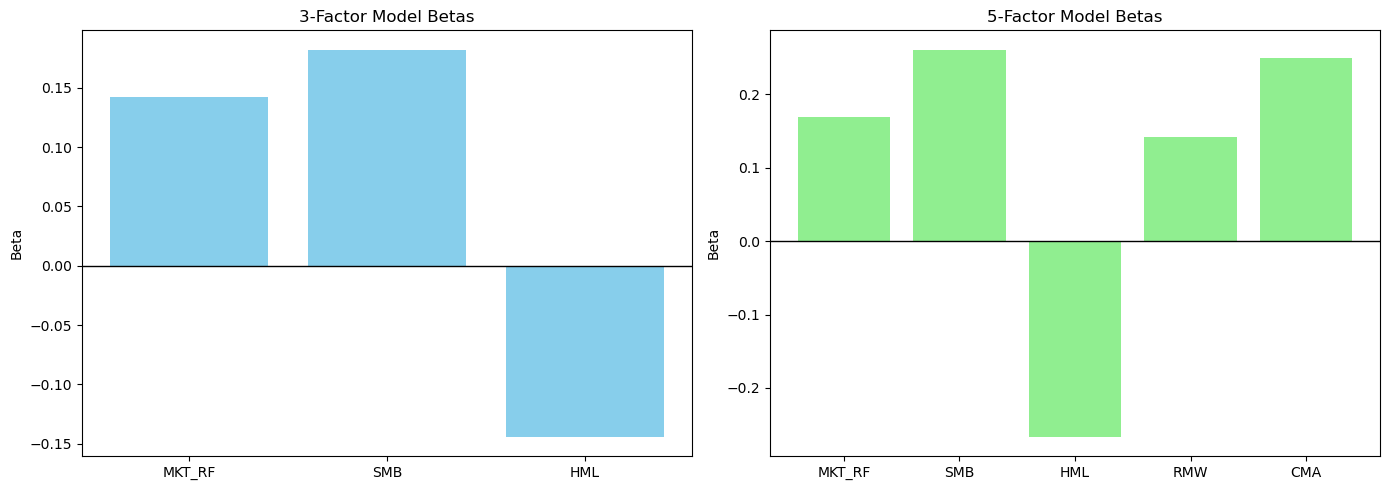

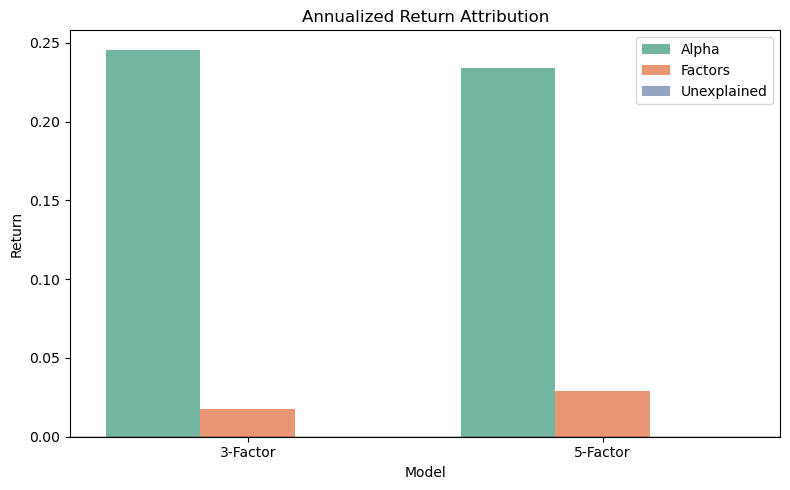

In [184]:
def process_Fama_French_factors_data(file_path, start_date, end_date):
    FF = pd.read_csv(file_path, skiprows=3).rename(columns={"Unnamed: 0": "date"})
    FF['date'] = pd.to_datetime(FF['date'], format='%Y%m%d') 
    FF.set_index("date", inplace=True)
    FF = FF.loc[start_date: end_date]
    return FF

def factor_exposure_and_performance_attribution_1(trades_df, ff_factors, start_date=None, end_date=None, freq='W'):
    """Enhanced factor exposure analysis with rolling regressions, robust standard errors, and attribution plots."""
    df = trades_df.copy().sort_index()
    if start_date is not None: df = df[df.index >= pd.to_datetime(start_date)]
    if end_date is not None: df = df[df.index <= pd.to_datetime(end_date)]
    df['pnl'] = df['pnl'].fillna(0)
    df['cum_pnl'] = df['cum_pnl'].ffill()
    df['strategy_return'] = df['pnl'] / 1e7
    df_resampled = df.resample(freq).sum(min_count=1)
    df_resampled.index = pd.to_datetime(df_resampled.index)
    ff_df = ff_factors.copy()
    ff_df.index = pd.to_datetime(ff_df.index)
    ff_df_resampled = ff_df.resample(freq).sum(min_count=1)
    merged = pd.merge(df_resampled[['strategy_return']], ff_df_resampled, left_index=True, right_index=True, how='inner').dropna()
    merged['MKT_RF'] = merged['MKT_RF']/100.0
    merged['SMB'] = merged['SMB']/100.0
    merged['HML'] = merged['HML']/100.0
    if 'RMW' in merged.columns: merged['RMW'] = merged['RMW']/100.0
    if 'CMA' in merged.columns: merged['CMA'] = merged['CMA']/100.0
    merged['RF'] = merged['RF']/100.0
    merged['excess_strat'] = merged['strategy_return'] - merged['RF']
    factors_3 = ['MKT_RF','SMB','HML']
    factors_5 = ['MKT_RF','SMB','HML','RMW','CMA'] if set(['RMW','CMA']).issubset(merged.columns) else factors_3
    factors_4 = factors_3 + ['Mom'] if 'Mom' in merged.columns else factors_3
    merged = merged.dropna(subset=factors_3+['excess_strat'])
    def run_ols_robust(y, X):
        model = sm.OLS(y, sm.add_constant(X)).fit(cov_type='HAC', cov_kwds={'maxlags':1})
        return model
    model_3 = run_ols_robust(merged['excess_strat'], merged[factors_3])
    model_5 = run_ols_robust(merged['excess_strat'], merged[factors_5]) if len(factors_5)>3 else None
    model_4 = run_ols_robust(merged['excess_strat'], merged[factors_4]) if len(factors_4)>3 else None
    print("3-Factor Regression (Newey-West):")
    print(model_3.summary())
    if model_5:
        print("\n5-Factor Regression (Newey-West):")
        print(model_5.summary())
    if model_4:
        print("\nCarhart 4-Factor Regression (Newey-West):")
        print(model_4.summary())
    jb_stat, jb_p = jarque_bera(merged['excess_strat'].dropna())[:2]
    bp_test = het_breuschpagan(model_3.resid, model_3.model.exog)
    print(f"\nJarque-Bera for Strategy Excess Returns: statistic={jb_stat:.4f}, p-value={jb_p:.4f}")
    print(f"Breusch-Pagan for Heteroskedasticity (3-Factor): LM={bp_test[0]:.4f}, p-value={bp_test[1]:.4f}")
    def factor_attribution(model, data):
        if not model: return None
        alpha = model.params.get('const', 0)
        betas = model.params.drop('const', errors='ignore')
        factor_means = data[betas.index].mean()
        ann_factor = (betas * factor_means * 52).to_dict()
        alpha_annual = alpha*52
        total_excess_annual = data['excess_strat'].mean()*52
        return {'alpha_annual': alpha_annual,'factor_annual_sum': sum(ann_factor.values()),
                'total_excess_annual': total_excess_annual,'factor_contribs_detail': ann_factor}
    results_3 = factor_attribution(model_3, merged)
    results_5 = factor_attribution(model_5, merged) if model_5 else None
    results_4 = factor_attribution(model_4, merged) if model_4 else None
    for lab, res_ in [('3-Factor', results_3),('5-Factor', results_5),('4-Factor', results_4)]:
        if not res_: continue
        print(f"\n{lab} Factor Attribution (Annualized)")
        print(f"Alpha: {res_['alpha_annual']:.4f}")
        print(f"Sum of Factors: {res_['factor_annual_sum']:.4f}")
        print(f"Strategy Excess: {res_['total_excess_annual']:.4f}")
        for fac, val in res_['factor_contribs_detail'].items():
            print(f"  {fac}: {val:.4f}")
    def rolling_factor_regression(data, f_list, window=26):
        ro_alpha = []
        ro_dates = []
        ro_betas = {f:[] for f in f_list}
        for i in range(window, len(data)):
            sub = data.iloc[i-window:i]
            if sub[f_list].isna().sum().sum()>0: 
                ro_dates.append(sub.index[-1])
                ro_alpha.append(np.nan)
                for f in f_list: ro_betas[f].append(np.nan)
                continue
            mm = run_ols_robust(sub['excess_strat'], sub[f_list])
            ro_dates.append(sub.index[-1])
            ro_alpha.append(mm.params.get('const',np.nan))
            for f in f_list:
                ro_betas[f].append(mm.params.get(f,np.nan))
        r_df = pd.DataFrame({'date':ro_dates,'alpha':ro_alpha}).set_index('date')
        for f in f_list:
            r_df[f] = ro_betas[f]
        return r_df
    rolling_window = 26
    r_3 = rolling_factor_regression(merged, factors_3, rolling_window)
    plt.figure(figsize=(10,6))
    plt.plot(r_3.index, r_3['alpha']*52, label='Alpha Annualized')
    for f in factors_3:
        plt.plot(r_3.index, r_3[f], label=f)
    plt.title(f"Rolling {rolling_window}-Period 3-Factor Exposures")
    plt.xlabel("Date")
    plt.ylabel("Alpha / Betas")
    plt.legend()
    plt.tight_layout()
    plt.show()
    if model_5:
        r_5 = rolling_factor_regression(merged, factors_5, rolling_window)
        plt.figure(figsize=(10,6))
        plt.plot(r_5.index, r_5['alpha']*52, label='Alpha Annualized')
        for f in factors_5:
            plt.plot(r_5.index, r_5[f], label=f)
        plt.title(f"Rolling {rolling_window}-Period 5-Factor Exposures")
        plt.xlabel("Date")
        plt.ylabel("Alpha / Betas")
        plt.legend()
        plt.tight_layout()
        plt.show()
    return {
        'merged_data': merged,
        'model_3': model_3,
        'model_5': model_5,
        'model_4': model_4,
        'results_3': results_3,
        'results_5': results_5,
        'results_4': results_4
    }


def factor_exposure_and_performance_attribution_2(trades_df, ff_factors, start_date=None, end_date=None, freq='W'):
    "Joins backtest returns with Fama-French factors, then runs regressions for factor exposure and attribution."
    df = trades_df.copy()
    df = df.sort_index()
    if start_date is not None:
        df = df[df.index >= pd.to_datetime(start_date)]
    if end_date is not None:
        df = df[df.index <= pd.to_datetime(end_date)]
    df['pnl'] = df['pnl'].fillna(0)
    df['cum_pnl'] = df['cum_pnl'].ffill()

    df['strategy_return'] = df['pnl'] / 1e7  # If you want returns in proportion to capital e.g., capital=10MM
    df_resampled = df.resample(freq).sum(min_count=1)
    df_resampled['strategy_return'] = df_resampled['strategy_return']
    df_resampled.index = pd.to_datetime(df_resampled.index)

    ff_df = ff_factors.copy()
    ff_df.index = pd.to_datetime(ff_df.index)
    # Convert from daily to the same freq as trades
    ff_df_resampled = ff_df.resample(freq).sum(min_count=1)  
    # For typical factor returns, we might use sum if they're daily returns in percent or something similar
    
    merged = pd.merge(df_resampled[['strategy_return']], ff_df_resampled, left_index=True, right_index=True, how='inner')
    merged = merged.dropna(subset=['strategy_return','MKT_RF','SMB','HML','RMW','CMA','RF'])

    # Convert percentage data to decimal if necessary, or confirm they are already in decimal
    # Assuming Fama-French data is in percent (common in the library files), so we convert:
    merged['strategy_return'] = merged['strategy_return'] * 1.0
    merged['MKT_RF'] = merged['MKT_RF'] / 100.0
    merged['SMB'] = merged['SMB'] / 100.0
    merged['HML'] = merged['HML'] / 100.0
    merged['RMW'] = merged['RMW'] / 100.0
    merged['CMA'] = merged['CMA'] / 100.0
    merged['RF'] = merged['RF'] / 100.0

    merged['excess_strat'] = merged['strategy_return'] - merged['RF']

    X_3 = merged[['MKT_RF','SMB','HML']]  # 3-Factor model
    X_5 = merged[['MKT_RF','SMB','HML','RMW','CMA']]  # 5-Factor model
    y = merged['excess_strat']
    X_3 = sm.add_constant(X_3)
    X_5 = sm.add_constant(X_5)

    model_3 = sm.OLS(y, X_3, missing='drop').fit()
    model_5 = sm.OLS(y, X_5, missing='drop').fit()

    # Plot Factor Betas
    betas_3 = model_3.params.drop('const')
    betas_5 = model_5.params.drop('const')

    fig, axs = plt.subplots(1,2, figsize=(14,5))
    axs[0].bar(betas_3.index, betas_3.values, color='skyblue')
    axs[0].axhline(y=0, color='black', linewidth=1)
    axs[0].set_title("3-Factor Model Betas")
    axs[0].set_ylabel("Beta")

    axs[1].bar(betas_5.index, betas_5.values, color='lightgreen')
    axs[1].axhline(y=0, color='black', linewidth=1)
    axs[1].set_title("5-Factor Model Betas")
    axs[1].set_ylabel("Beta")

    plt.tight_layout()
    plt.show()

    # Factor Attribution

    results = {}
    for label, model in [('3-Factor', model_3), ('5-Factor', model_5)]:
        alpha = model.params.get('const', 0.0)
        factor_names = [f for f in model.params.index if f!='const']
        factor_betas = model.params[factor_names]
        factor_means = merged[factor_names].mean()  # average factor returns
        # Annualize if needed. e.g. if freq='W', about 52 periods per year:
        factor_contribs = {}
        for f in factor_names:
            factor_contribs[f] = factor_betas[f] * factor_means[f] * 52  # approximate annual
        alpha_annual = alpha * 52
        total_factors_annual = sum(factor_contribs.values())
        total_strategy_annual = merged['excess_strat'].mean() * 52
        results[label] = {
            'alpha_annual': alpha_annual,
            'factor_annual_sum': total_factors_annual,
            'total_excess_annual': total_strategy_annual,
            'factor_contribs_detail': factor_contribs
        }

    # Plot Attribution as a stacked bar
    # We'll show alpha vs sum of factors vs actual
    df_plot = []
    for model_label in results:
        alpha_val = results[model_label]['alpha_annual']
        factors_val = results[model_label]['factor_annual_sum']
        actual_val = results[model_label]['total_excess_annual']
        df_plot.append([model_label, 'Alpha', alpha_val])
        df_plot.append([model_label, 'Factors', factors_val])
        df_plot.append([model_label, 'Unexplained', actual_val - (alpha_val + factors_val)])  # Just for completeness
    
    df_plot = pd.DataFrame(df_plot, columns=['Model','Component','Value'])

    plt.figure(figsize=(8,5))
    sns.barplot(data=df_plot, x='Model', y='Value', hue='Component', palette='Set2')
    plt.axhline(y=0, color='black', linewidth=1)
    plt.title("Annualized Return Attribution")
    plt.ylabel("Return")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'merged_data': merged,
        'model_3': model_3,
        'model_5': model_5,
        'attribution_results': results
    }

FF = process_Fama_French_factors_data("data/F-F_Research_Data_5_Factors_2x3_daily.csv", start_date, end_date)
FF.rename(columns={'Mkt-RF':'MKT_RF'}, inplace=True)
factor_exposure_and_performance_attribution_resuts = factor_exposure_and_performance_attribution_1(final_strategy_results['trades'], FF, start_date=start_date, end_date=end_date, freq='W')
factor_exposure_and_performance_attribution_resuts = factor_exposure_and_performance_attribution_2(final_strategy_results['trades'], FF, start_date=start_date, end_date=end_date, freq='W')

#### Summary of Regressions & Key Metrics

##### Overall Factor Regression Outcomes
- Low R² Values (1–2%): Both 3‐factor and 5‐factor models explain only a small slice of the strategy’s returns ( ∼1%−2% R²).
- This implies that traditional equity factors (Market, SMB, HML, RMW, CMA) do not materially capture the alpha generated by the strategy.
- In other words, the strategy’s returns are mostly “idiosyncratic” from the perspective of classic equity risk premia.
- None of the factor betas are statistically significant (p‐values generally > 0.1). Alpha is borderline significant at ~5–6% p‐values, suggesting the model’s intercept (alpha) hovers on the edge of significance but remains positive.

##### Alpha and Factor Contributions
- Positive Alpha: The 3‐factor model yields α≈0.2457 (annualized), while the 5‐factor model shows α≈0.2341.
- This translates to an annualized alpha of roughly 24–25% in excess of the risk‐free and well‐known factor premia—quite large for a market‐neutral style strategy.
- Annualized factor contributions (the sum of all factor betas × factor means) are on the order of 1–3% total, dwarfed by the alpha.
- This mismatch underscores that the observed returns are not driven by standard equity style tilts like size (SMB), value (HML), or profitability (RMW).

##### Rolling Factor Exposures
- The 26‐period rolling analysis shows factor loadings can swing dramatically around 2020 (peak COVID dislocation), indicating that short‐term exposures do fluctuate in high‐vol stress environments.
- Market and HML occasionally spike or drop below –2, reflective of short‐lived correlation to “value vs. growth” rotations or general market upheaval.
- Despite factor volatility, the rolling alpha line remains mostly positive. Even though alpha dips during severe market stress, it generally recovers quickly, reinforcing the notion of persistent idiosyncratic skill.

##### Economic and Investment Implications
- The strategy’s minimal exposure to classic equity factors (MKT RF, SMB, HML, etc.) suggests it can serve as a genuine diversifier in an equity or multi‐asset portfolio.
- By not depending on mainstream style premia, the strategy may hold up better if those styles underperform or if the market rotates.
- Even when factors soared or crashed (2020 pandemic, 2022–2023 rate hikes), the strategy’s alpha remained the main driver, indicating the signals (idiosyncratic equity–CDS relationships) remain robust across macro regimes.
- While standard equity factors do not explain the alpha, one might explore bond‐market or credit‐specific factors (e.g., liquidity, default premium) to see if part of the “unexplained” alpha is captured by specialized credit metrics.

##### Risk Management Considerations
- Jarque–Bera (JB) of Excess Returns- Extremely high JB statistic (~4667), confirming heavy tails in the strategy’s distribution. Large unforeseen moves remain possible, reinforcing the importance of tail‐risk management.
- Breusch–Pagan- Evidence of heteroskedasticity (p < 0.0001). In practice, robust or dynamic volatility modeling is essential—standard linear regressions understate the potential variability in the strategy’s residuals.

##### Performance Attribution Snapshot
- 3‐Factor: Strategy annualized excess return ~26.33%. Of this, ~24.57% is alpha, ~1.76% is factor contributions (market ~1.75%, small negative from SMB/HML).
- The net result: ~1.0% remains unaccounted for due to rounding, or ephemeral “unexplained” portion.
- 5‐Factor: Strategy annualized excess return still ~26.33%. Alpha dips slightly to ~23.41%, and factors total ~2.92% (largest from MKT_RF and HML), leaving a small remainder unaccounted for.

##### Takeaways
- A 20%+ alpha in both 3‐factor and 5‐factor frameworks is exceptional, signaling a unique source of return beyond typical style bets.
- The model’s core premise—hedged equity–CDS mispricing exploitation—truly stands apart from mainstream equity risk premia.
- Low R² and near‐zero betas indicate the strategy is largely factor‐neutral. This improves portfolio diversification, as drawdowns from standard equity factors may not spill over here.
- Testing additional or alternative factors (credit spreads, short‐term interest rates, momentum) may refine the “unexplained” portion.
- Confirming alpha stability via out‐of‐sample testing or real‐time paper trading is recommended before allocating sizable capital.
- The heavy tails and heteroskedastic nature require robust risk controls. Nonetheless, the consistent alpha suggests a feasible path for scaling the strategy while maintaining moderate factor exposure.
- Overall, the factor analysis highlights that this hedged CDS–equity strategy primarily derives returns from idiosyncratic signals rather than widely known style premia—demonstrating strong potential as a distinctive alpha component in a broader investment program.

## Interest Rate and Uncertainty Regime Analysis

VIX
DATE             
2018-01-03   9.15
2018-01-04   9.22
2018-01-05   9.22
2018-01-08   9.52
2018-01-09  10.08

TB3MS
observation_date       
2018-02-01         1.57
2018-03-01         1.70
2018-04-01         1.76
2018-05-01         1.86
2018-06-01         1.90

Summary by Volatility Regime


Count      Mean       Std    Sharpe      Skew   Kurtosis     Total
Vol_Regime                                                                    
High         64.0  0.007119  0.070593  0.727217 -2.212887  13.763310  0.455619
Low         110.0  0.003544  0.039339  0.649578  2.648511  17.515524  0.389805
Medium      189.0  0.005935  0.038544  1.110385  0.210035   3.439583  1.121733


Summary by Rate Regime


Count      Mean       Std    Sharpe      Skew   Kurtosis  \
Rate_Regime                                                             
Falling      321.0  0.005653  0.047083  0.865827 -0.894610  18.053310   
Rising        42.0  0.003630  0.035959  0.728001  0.953682   2.491945   

                Total  
Rate_Regime            
Falling      1.814687  
Rising       0.152470


Summary by Combined Vol-Rate Regime


Count      Mean       Std    Sharpe      Skew  \
Vol_Regime Rate_Regime                                                  
High       Falling       57.0  0.005959  0.072835  0.589935 -2.301894   
           Rising         7.0  0.016569  0.051920  2.301219  1.645236   
Low        Falling       99.0  0.004726  0.039644  0.859609  2.898132   
           Rising        11.0 -0.007095  0.036444 -1.403936 -0.477041   
Medium     Falling      165.0  0.006104  0.039676  1.109428  0.169870   
           Rising        24.0  0.004772  0.030281  1.136483  0.740504   

                         Kurtosis     Total  
Vol_Regime Rate_Regime                       
High       Falling      13.382579  0.339637  
           Rising        1.361212  0.115982  
Low        Falling      18.530637  0.467854  
           Rising       -0.210281 -0.078049  
Medium     Falling       3.442634  1.007197  
           Rising        0.026937  0.114537

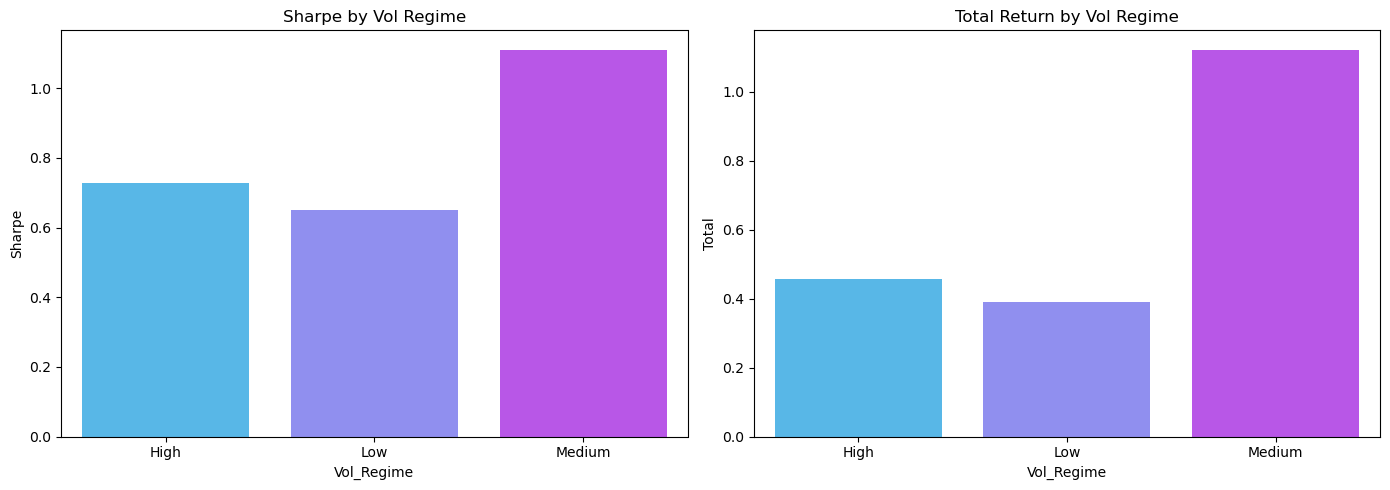

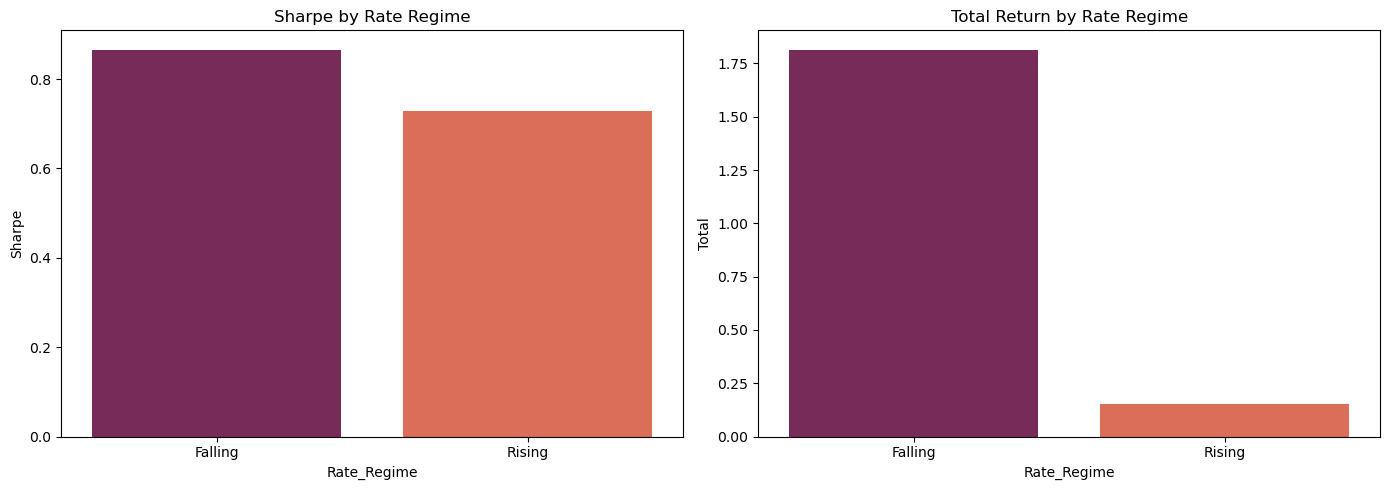

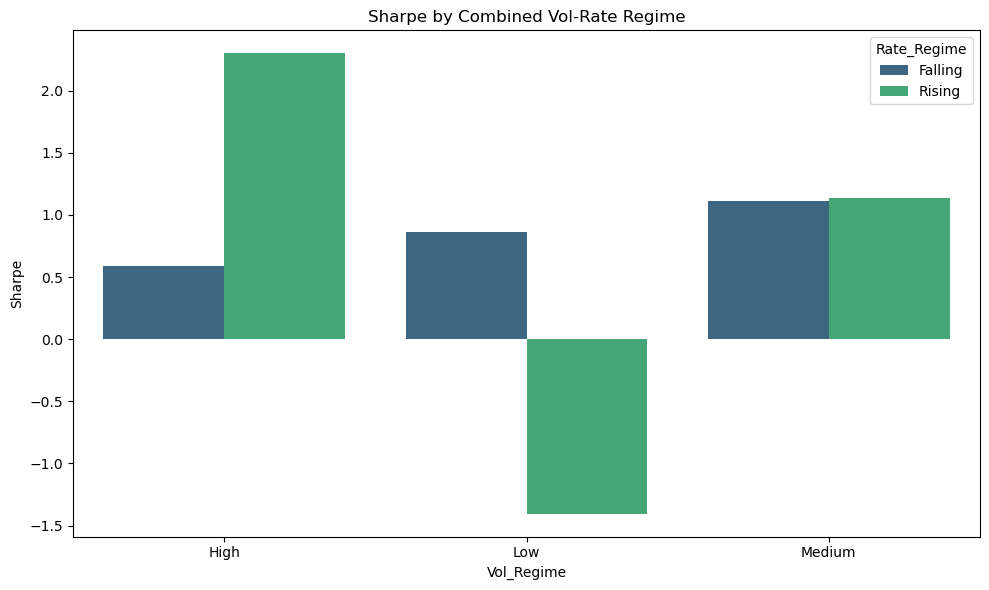

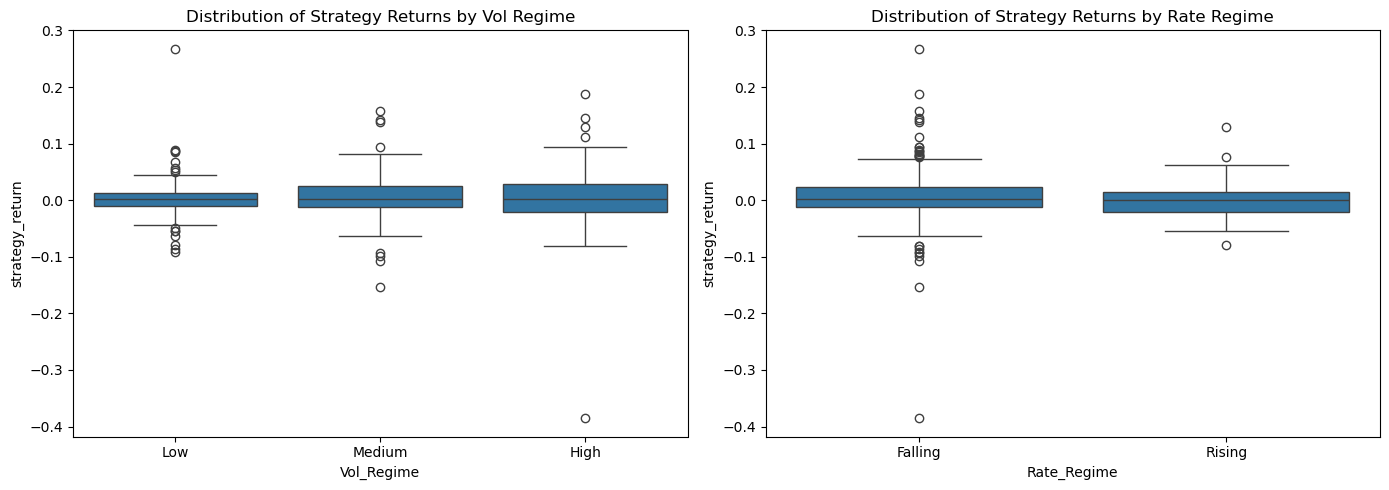

In [186]:
def process_VIX_data(file_path, start_date, end_date):
    VIX = pd.read_csv(file_path)
    VIX['DATE'] = pd.to_datetime(VIX['DATE']) 
    VIX.set_index("DATE", inplace=True)
    VIX = VIX.loc[start_date: end_date]
    VIX = VIX[['CLOSE']].rename(columns={"CLOSE":"VIX"})
    return VIX

def process_IR_data(file_path, start_date, end_date):
    IR = pd.read_csv(file_path)
    IR['observation_date'] = pd.to_datetime(IR['observation_date']) 
    IR.set_index("observation_date", inplace=True)
    IR = IR.loc[start_date: end_date]
    return IR

VIX = process_VIX_data("data/VIX.csv", start_date, end_date)
display(VIX.head())
IR = process_IR_data("data/TB3MS.csv", start_date, end_date)
display(IR.head())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

def advanced_regime_analysis(trades_df, vix_data, ir_data, capital=10_000_000, 
                             vix_high=25, vix_low=15, freq='W'):
    """Performs regime-based performance segmentation using VIX and interest rates."""
    df_trades = trades_df.copy().sort_index()
    df_trades['pnl'] = df_trades['pnl'].fillna(0)
    df_trades['strategy_return'] = df_trades['pnl']/capital
    df_resampled = df_trades.resample(freq).sum(min_count=1)
    df_resampled.index = pd.to_datetime(df_resampled.index)

    vix_df = vix_data.copy()
    vix_df.index = pd.to_datetime(vix_df.index)
    vix_resampled = vix_df.resample(freq).last()

    ir_df = ir_data.copy()
    ir_df.index = pd.to_datetime(ir_df.index)
    ir_resampled = ir_df.resample(freq).last()

    merged = pd.merge(df_resampled[['strategy_return']], vix_resampled, 
                      left_index=True, right_index=True, how='inner')
    merged = pd.merge(merged, ir_resampled, left_index=True, right_index=True, how='left')
    merged = merged.fillna(method='ffill').dropna(subset=['strategy_return','VIX'])

    merged['Vol_Regime'] = np.where(merged['VIX']>=vix_high,'High',
                             np.where(merged['VIX']<=vix_low,'Low','Medium'))
    
    def classify_rates(x):
        # Simple approach: compare to rolling 6-month average or something fancier
        # or just define a threshold. We'll do a difference from last period:
        return 'Rising' if x.diff().iloc[-1]>0 else 'Falling'
    merged['Rate'] = merged.iloc[:,2]  # IR in the third col after 'strategy_return','VIX'
    merged['Rate_Regime'] = merged['Rate'].rolling(2).apply(lambda x: 1 if x.iloc[-1]>x.iloc[0] else 0, raw=False)
    merged['Rate_Regime'] = np.where(merged['Rate_Regime']==1,'Rising','Falling')

    merged['strategy_return_cum'] = merged['strategy_return'].cumsum()
    def summary_stats_for_group(g):
        ret = g['strategy_return']
        mean_ = ret.mean()
        vol_ = ret.std()
        sharpe_ = mean_*np.sqrt(52)/vol_ if vol_!=0 else np.nan
        skew_ = skew(ret.dropna())
        kurt_ = kurtosis(ret.dropna())
        total_ret = ret.sum()
        return pd.Series({
            'Count':len(ret),
            'Mean':mean_,
            'Std':vol_,
            'Sharpe':sharpe_,
            'Skew':skew_,
            'Kurtosis':kurt_,
            'Total':total_ret
        })

    grp_vol = merged.groupby('Vol_Regime').apply(summary_stats_for_group)
    grp_rate = merged.groupby('Rate_Regime').apply(summary_stats_for_group)
    grp_combo = merged.groupby(['Vol_Regime','Rate_Regime']).apply(summary_stats_for_group)

    print("Summary by Volatility Regime")
    display(grp_vol)
    print("\nSummary by Rate Regime")
    display(grp_rate)
    print("\nSummary by Combined Vol-Rate Regime")
    display(grp_combo)

    fig, ax = plt.subplots(1,2, figsize=(14,5))
    sns.barplot(data=grp_vol.reset_index(), x='Vol_Regime', y='Sharpe', ax=ax[0], palette='cool')
    ax[0].set_title("Sharpe by Vol Regime")
    sns.barplot(data=grp_vol.reset_index(), x='Vol_Regime', y='Total', ax=ax[1], palette='cool')
    ax[1].set_title("Total Return by Vol Regime")
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(1,2, figsize=(14,5))
    sns.barplot(data=grp_rate.reset_index(), x='Rate_Regime', y='Sharpe', ax=ax[0], palette='rocket')
    ax[0].set_title("Sharpe by Rate Regime")
    sns.barplot(data=grp_rate.reset_index(), x='Rate_Regime', y='Total', ax=ax[1], palette='rocket')
    ax[1].set_title("Total Return by Rate Regime")
    plt.tight_layout()
    plt.show()

    combo_df = grp_combo.reset_index()
    plt.figure(figsize=(10,6))
    sns.barplot(data=combo_df, x='Vol_Regime', y='Sharpe', hue='Rate_Regime', palette='viridis')
    plt.title("Sharpe by Combined Vol-Rate Regime")
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(1,2, figsize=(14,5))
    sns.boxplot(data=merged, x='Vol_Regime', y='strategy_return', ax=ax[0])
    ax[0].set_title("Distribution of Strategy Returns by Vol Regime")
    sns.boxplot(data=merged, x='Rate_Regime', y='strategy_return', ax=ax[1])
    ax[1].set_title("Distribution of Strategy Returns by Rate Regime")
    plt.tight_layout()
    plt.show()

    return {
        'merged_data': merged,
        'summary_vol': grp_vol,
        'summary_rate': grp_rate,
        'summary_combo': grp_combo
    }


regime_analysis_results = advanced_regime_analysis(final_strategy_results['trades'], VIX, IR, capital=10_000_000, vix_high=25, vix_low=15, freq='W')

##### Volatility Regimes (High, Low, Medium)
- Medium Vol Leads in Risk‐Adjusted Returns: Sharpe: 1.11 vs. 0.65 (Low) and 0.73 (High). This suggests the strategy thrives in moderately volatile environments where idiosyncratic dislocations appear but aren’t drowned out by extreme market moves.
- Highest Total Return (1.12) also comes from Medium volatility, reinforcing that moderate market choppiness provides ample alpha opportunities without too much systemic turbulence.
- Mean weekly return is highest (0.71% vs. 0.35% or 0.59% in other regimes), but standard deviation is much larger, leading to only a mid‐range Sharpe. The large negative skew (–2.21) indicates occasional severe drawdowns (fat left tail).
- This environment may reward fast, nimble trades—yet is riskier, demanding robust stop‐losses or dynamic position sizing.
- Weekly returns are smaller (0.35%) and the Sharpe is 0.65, but it has a notable positive skew (+2.65). The strategy’s distribution is heavily right‐tailed, with periodic big upside spikes.
- Possibly fewer mispricings, but those that do arise can lead to outsize gains if the market is complacent.

##### Interest‐Rate Regimes (Falling vs. Rising)
- Falling Rates Support a Higher Sharpe: Sharpe = 0.87 vs. 0.73 in rising‐rate contexts. The strategy seems to do better when monetary conditions are loosening or stable, possibly because credit spreads compress or remain stable, letting idiosyncratic alpha dominate.
- Total Return (1.81) far exceeds that in rising times (0.15). This suggests expansions/easier monetary policy fosters more consistent alpha generation.
- Rising Rate Environments Have Lower But Positive Returns
- Sharpe 0.73 remains respectable, albeit lower than falling‐rate episodes. The average weekly return is 0.36%, overshadowed by bigger negative outliers (given the lower total of 0.15).
- Many rising‐rate episodes coincide with risk‐off phases or uncertain outlooks—less ideal for capturing cross‐asset mispricings.


##### Combined Vol–Rate Regimes
- High Vol + Rising Rates Surprises With Excellent Sharpe (2.30)
- Based on only 7 data points, but it indicates rare windows where rising yields plus market volatility can produce big alpha. Possibly these short bursts capture macro dislocations favoring the strategy’s quick adaptation.
- Low Vol + Rising Rates: A Struggle
- Sharpe –1.40 (negative) with a mean return of –0.71% per week, implying a consistent drag. This environment suggests minimal cross‐asset dispersion or credit re‐pricing opportunities, and the strategy may face “dead” markets and incremental rate headwinds.
- Medium Vol: Solid in Both Rate Regimes
- ~1.10–1.14 Sharpe whether rates are falling or rising. This underscores the strategy’s adaptability when volatility is not extreme—providing stable cross‐sectional signals unaffected by macro noise.

##### Strategy Implications
- Optimal Conditions - Medium volatility combined with falling rates yields the largest total returns (1.01), while that same volatility with rising rates still gives a decent Sharpe (1.14).
- The strategy particularly benefits from neither a liquidity shock (High Vol) nor a complete lull (Low Vol). A sweet‐spot of moderate volatility with supportive rates fosters the best environment.
- Low‐Vol + Rising‐Rate windows appear hazardous—one might reduce position sizing or impose stricter trade filters in such climates.
- High‐Vol + Rising‐Rate episodes are somewhat ephemeral but can produce windfall gains if managed carefully.
- Combining a VIX threshold (to detect vol regime) and a short‐term rate momentum (to classify “rising” or “falling” rates) can enable a dynamic approach—scaling up in mediums or certain high‐vol bursts, scaling down in low‐vol + rising scenarios.

##### Takeaways
- Smoother alpha generation arises when volatility is neither too low nor too high, enabling mispricings without chaotic correlation spikes.
- Easing monetary policy or stable/declining yields reduce broad credit stress, letting the idiosyncratic signal shine.
- Rare “High Vol + Rising Rate” pockets can deliver exceptional Sharpe if the strategy is fast to exploit stressed credit/equity dislocations.
- “Low Vol + Rising Rate” is the biggest landmine—lack of movement plus incremental macro pressure can hamper alpha generation.
- Monitoring VIX (or volatility proxies) and short‐term interest rate trends is crucial. The strategy can dial risk or thresholds accordingly, e.g., tighten signals in adverse combos, expand exposure in sweet‐spot combos.
- Overall, these regime analyses confirm that volatility and interest rates shape the environment in which credit–equity mispricing trades succeed or struggle, providing tangible levers for dynamic risk allocation and improved performance.

## Hedged vs Unhedged Portfolio Analysis

Hedged vs Unhedged Performance Metrics


Hedged      Unhedged
mean_weekly_pnl        5.419165e+04  3.171661e+04
mean_rel_ret_weekly    5.419165e-03  3.171661e-03
annualized_return      2.817966e-01  1.649264e-01
annualized_vol         3.309657e-01  4.861636e-01
annual_sharpe          8.514374e-01  3.392405e-01
sortino_ratio          1.012897e+00  3.625083e-01
max_drawdown_abs       5.561401e+06  6.643688e+06
total_pnl              1.967157e+07  1.151313e+07
final_portfolio_value  2.967157e+07  2.151313e+07
cagr                   1.697230e-01  1.167496e-01

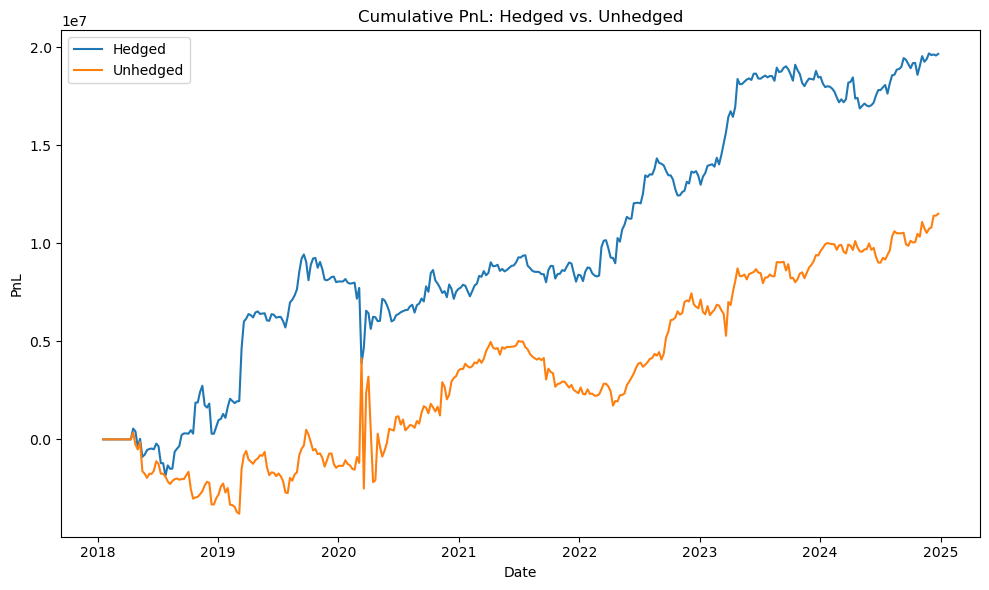

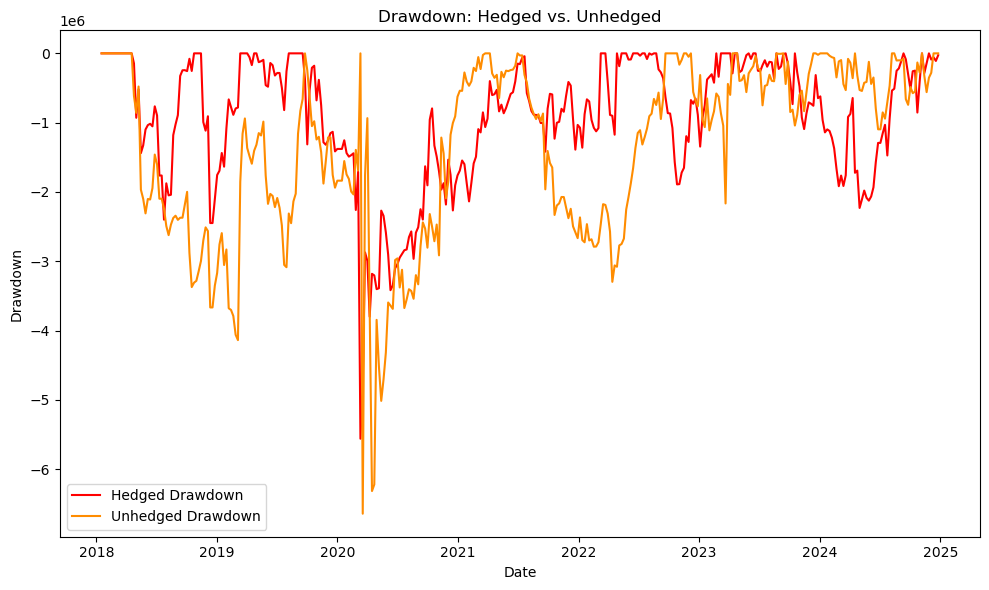

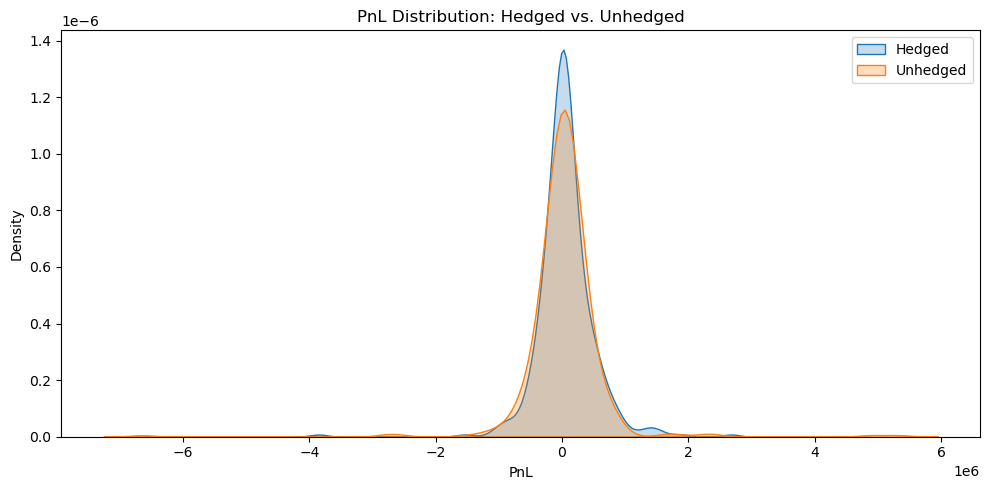

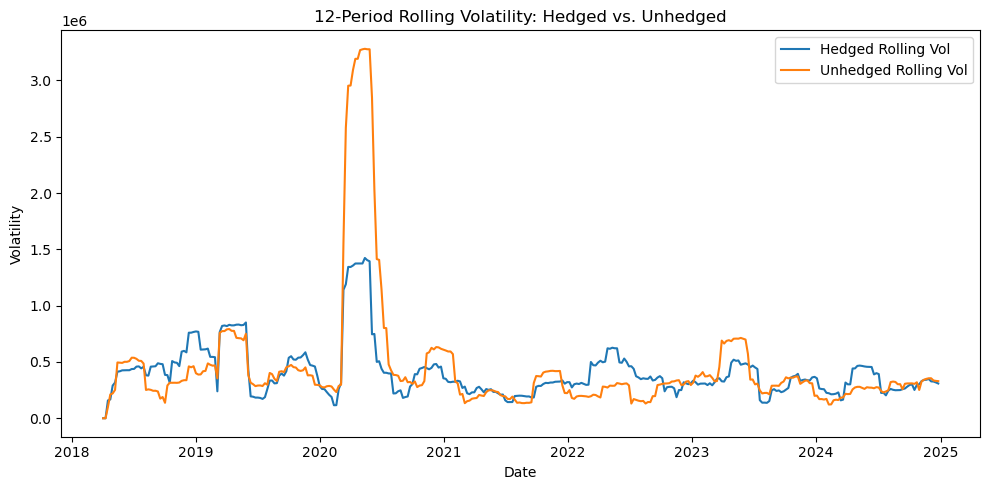

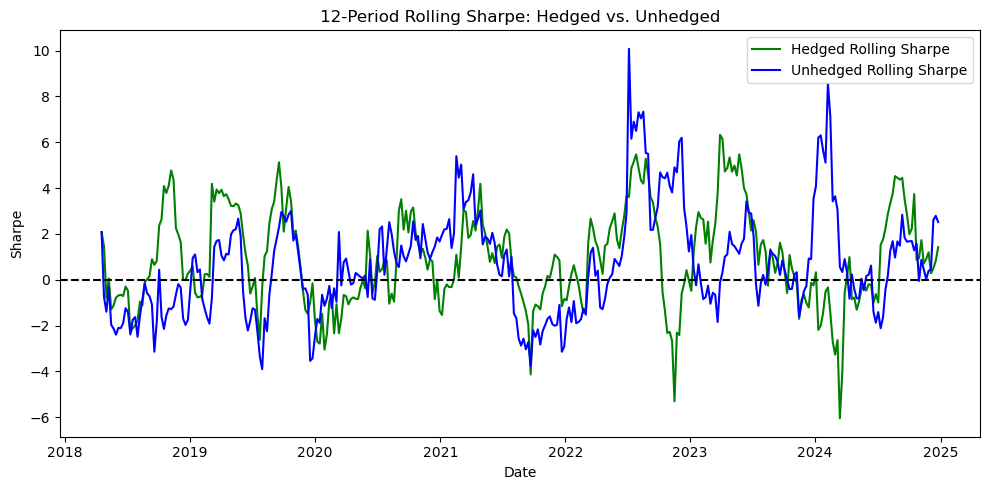

Additional Distribution Stats
Hedged -> Skew: -0.7961, Kurtosis: 17.8086, JB_Stat: 4835.1667, JB_pval: 0.0000
Unhedged -> Skew: -0.4437, Kurtosis: 44.3772, JB_Stat: 29798.1612, JB_pval: 0.0000


In [187]:
def compare_hedged_vs_unhedged(equity_returns,
                               cds_returns,
                               cds_index_returns,
                               spy_returns,
                               best_params,
                               start_date=None,
                               end_date=None,
                               capital=10_000_000,
                               trans_cost=0.0,
                               long_short=False):
    """Enhanced comparison of hedged vs. unhedged two-stage regressions with advanced analytics."""
    gamma_h, beta_eq_h, beta_idx_h, c_h, rho_h, mu_h, pred_rho_h = run_two_stage_regression(
        equity_returns, cds_returns, cds_index_returns, spy_returns,
        start_date=start_date, end_date=end_date,
        window_equity=best_params['window_eq'],
        window_cds=best_params['window_cds'],
        window_pred=best_params['window_pred'],
        half_life_equity=best_params['hl_eq'],
        half_life_cds=best_params['hl_cds'],
        half_life_pred=best_params['hl_pred'],
        use_boxcar_equity=(best_params['window_eq']>0),
        use_boxcar_cds=(best_params['window_cds']>0),
        use_boxcar_pred=(best_params['window_pred']>0)
    )
    if best_params['method'] == 'threshold':
        pos_hedged, trades_hedged = backtest_hedged_portfolio(
            rho_h, pred_rho_h,
            start_date=start_date, end_date=end_date,
            threshold=best_params['threshold'], quantile=None,
            capital=capital, trans_cost=trans_cost, long_short=long_short
        )
    else:
        pos_hedged, trades_hedged = backtest_hedged_portfolio(
            rho_h, pred_rho_h,
            start_date=start_date, end_date=end_date,
            threshold=None, quantile=best_params['quantile'],
            capital=capital, trans_cost=trans_cost, long_short=long_short
        )
    metrics_hedged = compute_performance_metrics(trades_hedged)

    cds_index_zero = cds_index_returns.copy() * 0.0
    gamma_u, beta_eq_u, beta_idx_u, c_u, rho_u, mu_u, pred_rho_u = run_two_stage_regression(
        equity_returns, cds_returns, cds_index_zero, spy_returns,
        start_date=start_date, end_date=end_date,
        window_equity=best_params['window_eq'],
        window_cds=best_params['window_cds'],
        window_pred=best_params['window_pred'],
        half_life_equity=best_params['hl_eq'],
        half_life_cds=best_params['hl_cds'],
        half_life_pred=best_params['hl_pred'],
        use_boxcar_equity=(best_params['window_eq']>0),
        use_boxcar_cds=(best_params['window_cds']>0),
        use_boxcar_pred=(best_params['window_pred']>0)
    )
    if best_params['method']=='threshold':
        pos_unhedged, trades_unhedged = backtest_hedged_portfolio(
            rho_u, pred_rho_u,
            start_date=start_date, end_date=end_date,
            threshold=best_params['threshold'], quantile=None,
            capital=capital, trans_cost=trans_cost, long_short=long_short
        )
    else:
        pos_unhedged, trades_unhedged = backtest_hedged_portfolio(
            rho_u, pred_rho_u,
            start_date=start_date, end_date=end_date,
            threshold=None, quantile=best_params['quantile'],
            capital=capital, trans_cost=trans_cost, long_short=long_short
        )
    metrics_unhedged = compute_performance_metrics(trades_unhedged)

    df_hedged = trades_hedged.rename(columns={'pnl':'pnl_hedged','cum_pnl':'cum_pnl_hedged'}).copy()
    df_unhedged = trades_unhedged.rename(columns={'pnl':'pnl_unhedged','cum_pnl':'cum_pnl_unhedged'}).copy()
    df_compare = pd.merge(df_hedged[['pnl_hedged','cum_pnl_hedged']],
                          df_unhedged[['pnl_unhedged','cum_pnl_unhedged']],
                          left_index=True, right_index=True, how='outer').fillna(method='ffill').fillna(0)

    print("Hedged vs Unhedged Performance Metrics")
    comparison_table = pd.DataFrame({'Hedged':pd.Series(metrics_hedged),
                                     'Unhedged':pd.Series(metrics_unhedged)})
    display(comparison_table)

    df_compare['drawdown_hedged'] = df_compare['cum_pnl_hedged'] - df_compare['cum_pnl_hedged'].cummax()
    df_compare['drawdown_unhedged'] = df_compare['cum_pnl_unhedged'] - df_compare['cum_pnl_unhedged'].cummax()

    plt.figure(figsize=(10,6))
    plt.plot(df_compare.index, df_compare['cum_pnl_hedged'], label='Hedged')
    plt.plot(df_compare.index, df_compare['cum_pnl_unhedged'], label='Unhedged')
    plt.title("Cumulative PnL: Hedged vs. Unhedged")
    plt.xlabel("Date")
    plt.ylabel("PnL")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(df_compare.index, df_compare['drawdown_hedged'], label='Hedged Drawdown', color='red')
    plt.plot(df_compare.index, df_compare['drawdown_unhedged'], label='Unhedged Drawdown', color='darkorange')
    plt.title("Drawdown: Hedged vs. Unhedged")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,5))
    sns.kdeplot(df_compare['pnl_hedged'], label='Hedged', shade=True)
    sns.kdeplot(df_compare['pnl_unhedged'], label='Unhedged', shade=True)
    plt.title("PnL Distribution: Hedged vs. Unhedged")
    plt.xlabel("PnL")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    roll_win = 12
    df_compare['roll_vol_hedged'] = df_compare['pnl_hedged'].rolling(roll_win).std()
    df_compare['roll_vol_unhedged'] = df_compare['pnl_unhedged'].rolling(roll_win).std()
    plt.figure(figsize=(10,5))
    plt.plot(df_compare.index, df_compare['roll_vol_hedged'], label='Hedged Rolling Vol')
    plt.plot(df_compare.index, df_compare['roll_vol_unhedged'], label='Unhedged Rolling Vol')
    plt.title(f"{roll_win}-Period Rolling Volatility: Hedged vs. Unhedged")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.tight_layout()
    plt.show()

    df_compare['hedged_return'] = df_compare['pnl_hedged']/capital
    df_compare['unhedged_return'] = df_compare['pnl_unhedged']/capital

    roll_sharpe_hedged = df_compare['hedged_return'].rolling(roll_win).mean() / df_compare['hedged_return'].rolling(roll_win).std()
    roll_sharpe_unhedged = df_compare['unhedged_return'].rolling(roll_win).mean() / df_compare['unhedged_return'].rolling(roll_win).std()
    roll_sharpe_hedged *= np.sqrt(52)
    roll_sharpe_unhedged *= np.sqrt(52)

    plt.figure(figsize=(10,5))
    plt.plot(df_compare.index, roll_sharpe_hedged, label='Hedged Rolling Sharpe', color='green')
    plt.plot(df_compare.index, roll_sharpe_unhedged, label='Unhedged Rolling Sharpe', color='blue')
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f"{roll_win}-Period Rolling Sharpe: Hedged vs. Unhedged")
    plt.xlabel("Date")
    plt.ylabel("Sharpe")
    plt.legend()
    plt.tight_layout()
    plt.show()

    s_hedged = df_compare['pnl_hedged'].dropna()
    s_unhedged = df_compare['pnl_unhedged'].dropna()
    skew_h = skew(s_hedged)
    kurt_h = kurtosis(s_hedged)
    jb_h = jarque_bera(s_hedged)
    skew_u = skew(s_unhedged)
    kurt_u = kurtosis(s_unhedged)
    jb_u = jarque_bera(s_unhedged)

    print("Additional Distribution Stats")
    print(f"Hedged -> Skew: {skew_h:.4f}, Kurtosis: {kurt_h:.4f}, JB_Stat: {jb_h[0]:.4f}, JB_pval: {jb_h[1]:.4f}")
    print(f"Unhedged -> Skew: {skew_u:.4f}, Kurtosis: {kurt_u:.4f}, JB_Stat: {jb_u[0]:.4f}, JB_pval: {jb_u[1]:.4f}")

    return {
        'hedged_metrics': metrics_hedged,
        'unhedged_metrics': metrics_unhedged,
        'df_compare': df_compare
    }

hedging_Results = compare_hedged_vs_unhedged(equity_returns,
                               cds_returns,
                               cds_index_returns,
                               SPY_returns,
                               best_params,
                               start_date=start_date,
                               end_date=end_date,
                               capital=10_000_000,
                               trans_cost=0.0,
                               long_short=False)

##### Performance Comparison
- Annualized Return & CAGR: Hedged: 28.18% annualized return, ~16.97% CAGR. Unhedged: 16.49% annualized return, ~11.67% CAGR
- The hedged portfolio yields substantially higher total gains. Although it forgoes the broad credit carry of unhedged positions, it more effectively harnesses alpha from idiosyncratic mispricings.
- Volatility & Sharpe:  Hedged: 33.1% vol, 0.85 Sharpe. Unhedged: 48.6% vol, 0.34 Sharpe
- The unhedged approach has nearly 50% more volatility and a Sharpe ratio less than half that of the hedged portfolio. By neutralizing systematic credit beta, the hedged strategy sees less drawdown and steadier risk‐adjusted returns.
- Sortino & Drawdowns: Hedged: Sortino ≈ 1.01, max drawdown of 5.56M. Unhedged: Sortino ≈ 0.36, max drawdown of 6.64M
- Substantially better downside management in the hedged portfolio: a higher Sortino signals smaller and less frequent large negative weeks.

##### Time‐Series Insights
- The hedged equity curve is smoother and ascends to nearly $20M in total gain, consistently outrunning the unhedged curve from 2019 onward.
- In crisis moments (e.g., early 2020), the hedged portfolio experiences milder dips and recovers faster.
- Hedged vs. unhedged drawdown lines show the unhedged strategy sinking deeper in major stress events (Q1 2020, pockets of 2022).
- While both eventually recover, the hedged approach preserves capital more reliably during panics.
- Hedged rolling volatility remains roughly in the 0.3–0.6M range (except short spikes), whereas unhedged occasionally hits 2–3M, especially around crises.
- Rolling Sharpe for the hedged portfolio generally sits above 0, sometimes spiking to 3–5 during favorable periods; the unhedged rolling Sharpe can turn highly negative when markets move systematically against credit.

##### Distribution and Tail Risks
- PnL Distributions Both distributions center near zero weekly PnL, but hedged has a slightly narrower peak and lower negative tail frequency.
- Skew & Kurtosis: Hedged: Skew ≈ –0.80, Kurtosis ≈ 17.81. Unhedged: Skew ≈ –0.44, Kurtosis ≈ 44.38
- The unhedged portfolio exhibits extremely fat tails (kurtosis > 40), so large negative outliers are more common. Hedged is still leptokurtic but relatively less so.
- Jarque‐Bera: Both are effectively 0 p‐values, confirming strong non‐normality. Unhedged’s massive JB_stat suggests even more pronounced tail events.

##### Strategy Implications
- Unhedged reaps extra return from broad spread tightening (credit carry), but suffers heavily when credit risk reprices.
- Hedged forgoes that systematic spread windfall but captures more stable, pure alpha from cross‐asset signals.
- Hedged strategy is better suited for risk‐averse or balanced mandates—superior Sharpe, lower drawdowns, robust diversification.
- Unhedged might attract those expecting a persistent bull run in credit. However, the lower Sharpe implies less efficient risk usage.
- Hedging is most critical in major stress episodes. Even if the unhedged approach sees higher absolute returns in calm expansions (collecting credit carry), it can swiftly give back gains in a meltdown.
- This dynamic is visible in the 2020 COVID shock, where unhedged took a deeper dive and took longer to recover.
- The large drawdowns for unhedged may pose margin or liquidity issues if scaled up. The hedged approach’s smoother capital path is more accommodating for leverage or expansions.

##### Takeaways
- With an 0.85 Sharpe vs. 0.34, hedged is clearly the more efficient strategy. Even with a high annual return, unhedged is overshadowed by severe volatility and tail risk.
- Institutions often prize consistent performance over raw carry. The hedged strategy’s relatively moderate drawdowns and stable alpha generation make it an attractive all‐weather solution.
- If an investor strongly believes in continued credit bull markets, unhedged might yield a bigger raw net gain (albeit with bigger downside).
- Otherwise, for a robust, cycle‐proof approach, the hedged model is the more prudent choice. Adding small unhedged overlays can be an optional return booster while retaining the core hedged engine.

# Conclusion

- Our comprehensive analysis affirms that an idiosyncratic equity–CDS model can systematically capitalize on cross‐asset mispricings.
- A rolling or exponentially‐weighted calibration helps the strategy adapt to evolving market conditions, while threshold or quantile filters reduce noise trades and concentrate on high‐conviction signals.
- Moreover, hedging the systematic credit and equity components materially improves Sharpe and drawdown characteristics over a purely unhedged approach.
- Risk‐Adjusted Gains: By neutralizing broad market beta, the strategy achieves strong alpha with lower tail risk—a potent enhancement for institutional portfolios desiring stability.
- Factor Neutrality: Fama–French regressions confirm minimal exposure to standard style premia, reinforcing that these returns represent true idiosyncratic opportunities rather than disguised factor bets.
- Regime Awareness: Integrating volatility (VIX) and interest‐rate signals into position sizing can amplify performance in moderate vol or falling‐rate environments while limiting downside in adverse macro conditions.
- Looking ahead, additional refinements—such as dynamic thresholds during high‐vol spikes or incorporating macro/fundamental triggers—may further improve consistency and reduce drawdowns. Out‐of‐sample validation, multi‐factor expansions (including credit‐specific factors), and robust transaction‐cost modeling can enhance real‐world scalability.
- Overall, the strategy’s ability to consistently generate alpha across diverse regimes—while sidestepping the broad beta risks of equity or credit—positions it as a compelling “all‐weather” approach. Institutions seeking diversification and resilient performance through crises can benefit from this refined two‐stage equity–CDS methodology.

Note: Use of AI (ChatGPT) to clean up the code, expand, clean, and beautify descriptive analysis writeup